In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import preps, opts, params, feats, strats
importlib.reload(preps)
importlib.reload(opts)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strats)

<module 'libs.strats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/strats.py'>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.samplers import TPESampler
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

from datetime import time
import json
import re
from re import findall

from IPython.display import display, clear_output, update_display, HTML
import io
import os
import json
import contextlib
from tqdm import tqdm

pd.set_option('display.max_columns', None)


,open,high,low,close,volume,trade_count,vwap,ask,bid,rsi_6,atr_14,adx_14,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,97.117392,0.053679,19.072892,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,97.117392,0.049844,23.632803,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,94.266696,0.046998,27.633299,152.307813
2021-09-01 08:03:00,152.290,152.290,152.290,152.290,637.0,53.0,152.290000,152.3205,152.2595,91.059251,0.044356,31.105532,152.305425
2021-09-01 08:04:00,152.310,152.310,152.290,152.290,582.0,20.0,152.298281,152.3205,152.2595,91.059251,0.042616,34.396121,152.303742
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 23:55:00,146.925,146.925,146.925,146.925,420.0,15.5,146.925000,146.9544,146.8956,41.862048,0.031785,20.469780,147.712166
2023-02-28 23:56:00,146.890,146.890,146.890,146.890,296.0,14.0,146.890000,146.9194,146.8606,33.559533,0.032014,20.411414,147.712162
2023-02-28 23:57:00,146.910,146.910,146.910,146.910,326.0,20.0,146.910000,146.9394,146.8806,41.513568,0.031156,19.854952,147.712158
2023-02-28 23:58:00,146.900,146.920,146.900,146.900,7297.0,29.0,146.900371,146.9294,146.8706,38.731484,0.030359,19.338237,147.712062


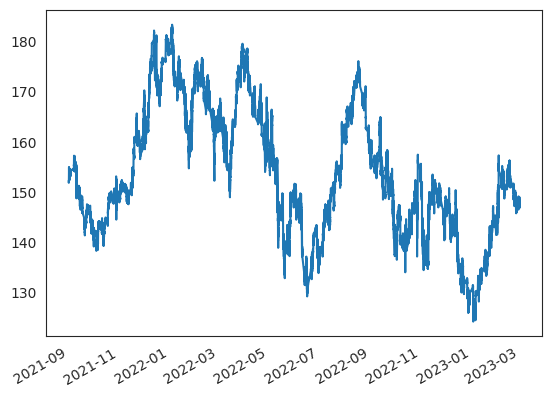

In [3]:
# loading csv with indicators unscaled

hdr = pd.read_csv(params.indunsc_csv, nrows=0).columns.tolist()
index_name = hdr[0]   # first column header, whatever it is

cols_needed = [
    "open","high","low","close","volume","trade_count","vwap","ask","bid",
    params.col_atr_tick, params.col_adx_tick, params.col_rsi_tick, params.col_vwap_tick,
]

usecols = [index_name] + cols_needed

df_inds = pd.read_csv(params.indunsc_csv, usecols=usecols, index_col=index_name, parse_dates=True)
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################
df_inds.close.plot()
df_inds

In [4]:
# # ##### 1.73e12 ######
# {'min_prof_thr': (0.00162, 0.00162),
#  'max_down_prop': (0.00448, 0.00448),
#  'gain_tightfact': (0.02824, 0.02824),
#  'tau_time': (5.50162, 5.50162),
#  'tau_dur': (6.45505, 6.45505),
#  'thresh_choice': {'categorical': ['median_nonzero']},
#  'reset_peak': (0, 0),
#  'rsi_min_thresh': (2, 2),
#  'rsi_max_thresh': (83, 83),
#  'adx_thresh': (8.04501, 8.04501),
#  'atr_mult': (0.09344, 0.09344),
#  'vwap_atr_mult': (2.79554, 2.79554),
#  'buy_factor': (0.00698, 0.00698),
#  'sell_factor': (0.0062, 0.0062),
#  'trailstop_pct': (0.00295, 0.00295)}

# # ##### 1.7e12 ######
# {'min_prof_thr': (1.602393636068798e-05, 0.003023976063639312),
#  'max_down_prop': (0.0038248057217431224, 0.005055194278256877),
#  'gain_tightfact': (0.03396321338777029, 0.04361678661222971),
#  'tau_time': (5.499786849218062, 5.503083150781937),
#  'tau_dur': (6.353872465551873, 6.513467534448126),
#  'thresh_choice': {'categorical': ['median_nonzero']},
#  'reset_peak': (0, 0),
#  'rsi_min_thresh': (1, 3),
#  'rsi_max_thresh': (76, 92),
#  'adx_thresh': (7.7874912718650195, 8.392478728134982),
#  'atr_mult': (0.0896175234154521, 0.0977424765845479),
#  'vwap_atr_mult': (-4.914678141392759, 0.08226814139275929),
#  'buy_factor': (0.005559091782229434, 0.007650908217770565),
#  'sell_factor': (0.005189692373869816, 0.006620307626130185),
#  'trailstop_pct': (-6.641867784973903, 11.102117784973903)}

{'min_prof_thr': (1.602393636068798e-05, 0.003023976063639312),
 'max_down_prop': (0.0038248057217431224, 0.005055194278256877),
 'gain_tightfact': (0.03396321338777029, 0.04361678661222971),
 'tau_time': (5.499786849218062, 5.503083150781937),
 'tau_dur': (6.353872465551873, 6.513467534448126),
 'thresh_choice': {'categorical': ['median_nonzero']},
 'reset_peak': (0, 0),
 'rsi_min_thresh': (1, 3),
 'rsi_max_thresh': (76, 92),
 'adx_thresh': (7.7874912718650195, 8.392478728134982),
 'atr_mult': (0.0896175234154521, 0.0977424765845479),
 'vwap_atr_mult': (-4.914678141392759, 0.08226814139275929),
 'buy_factor': (0.005559091782229434, 0.007650908217770565),
 'sell_factor': (0.005189692373869816, 0.006620307626130185),
 'trailstop_pct': (-6.641867784973903, 11.102117784973903)}

In [5]:
prun_perc       = 80
report_interval = 50

col_signal = "targ_signal"

def objective(trial: optuna.Trial) -> float:
    min_prof_thr    = trial.suggest_float("min_prof_thr", 0.001, 0.002)
    max_down_prop   = trial.suggest_float("max_down_prop", 0.003, 0.005)
    gain_tightfact  = trial.suggest_float("gain_tightfact", 0.025, 0.035)
    tau_time        = trial.suggest_float("tau_time", 5.4, 5.6)
    tau_dur         = trial.suggest_float("tau_dur", 6.3, 6.55)
    
    thresh_choice = trial.suggest_categorical("thresh_choice",
        ["median_nonzero"])

    if thresh_choice == "numeric":
        thresh_mode = trial.suggest_float("thresh_value", 0.01, 1.0)
        thresh_window = None
    else: # signal threshold
        thresh_mode = thresh_choice
        thresh_window = trial.suggest_int("thresh_window", 5, 200) if thresh_choice.startswith("roll") else None

    reset_peak     = trial.suggest_categorical("reset_peak", [False])
    rsi_min_thresh = trial.suggest_int("rsi_min_thresh", 1, 3)
    rsi_max_thresh = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 80), 87)
    adx_thresh     = trial.suggest_float("adx_thresh", 7.8, 8.2)
    atr_mult       = trial.suggest_float("atr_mult", 0.08, 0.1)
    vwap_atr_mult  = trial.suggest_float("vwap_atr_mult", -5, 5)
    buy_factor     = trial.suggest_float("buy_factor", 0.006, 0.008)
    sell_factor    = trial.suggest_float("sell_factor", 0.005, 0.007)
    trailstop_pct  = trial.suggest_float("trailstop_pct", 0, 10)

    print("-" * 160)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    # 1) detect swings / build raw signal columns (no thresholding)
    df_detect = preps.build_signal_per_day(
        df              = df_inds.copy(),
        min_prof_thr    = min_prof_thr,
        max_down_prop   = max_down_prop,
        gain_tightfact  = gain_tightfact,
        tau_time        = tau_time,
        tau_dur         = tau_dur,
        col_close       = "close",
    )

    # 2) compute per-day thresholds and gap_to_thresh
    df_thresh = preps.apply_thresholds_per_day(
        df              = df_detect,
        thresh_mode     = thresh_mode,
        thresh_window   = thresh_window,
        col_signal      = col_signal
    )

    # Group per-day for this trial
    groups = list(df_thresh.groupby(df_thresh.index.normalize()))

    # Reset globals
    start_ask = df_thresh.loc[df_thresh.index.normalize() == df_thresh.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)

    daily_pnls, daily_bh_pnls = [], []
    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}

    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)
    for step, (day, df_day) in enumerate(pbar, 1):
        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_signal      = col_signal,
            sign_thresh     = "signal_thresh",
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
        )

        sim_results = strats.simulate_trading(
            day         = day,
            df          = df_actions,
            buy_factor  = buy_factor,
            sell_factor = sell_factor,
        )

        df_sim, trades, stats = next(iter(sim_results.values()))

        trial_action_counts["Buy"]  += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        daily_pnls.append(strats._parse_eq_value(stats["STRATEGY"]))
        daily_bh_pnls.append(strats._parse_eq_value(stats["BUYNHOLD"]))

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))

            trial.set_user_attr("mean_pnl",      float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls",  float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})

            trial.report(prun_val, report_step)
            if trial.should_prune():
                vals = [
                    t.intermediate_values[report_step]
                    for t in trial.study.get_trials(deepcopy=False)
                    if t.state == TrialState.COMPLETE and report_step in t.intermediate_values
                ]
                thr = np.percentile(vals, prun_perc) if vals else prun_val
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    trial.set_user_attr("mean_pnl",     float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts",{k: int(v) for k, v in trial_action_counts.items()})

    mean_excess = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))
    return mean_excess


Baseline mean daily B&H: -9.5162


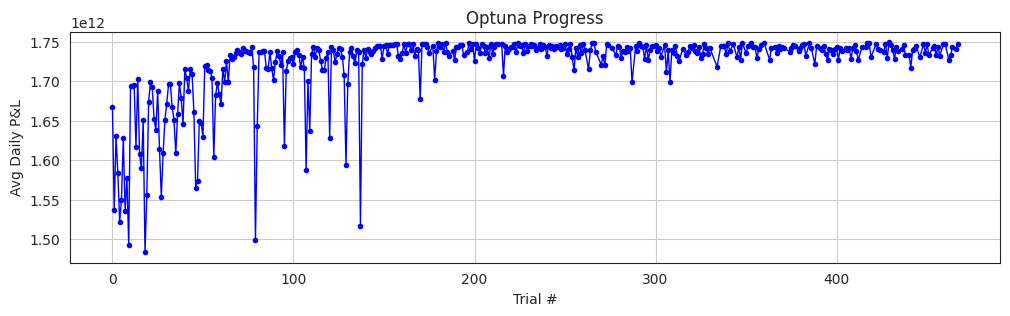

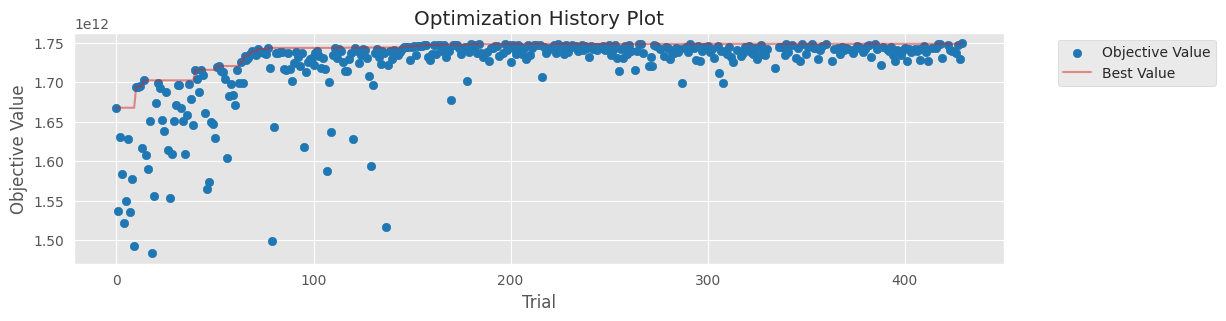

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0014906918008852073; max_down_prop=0.0031014200904185074; gain_tightfact=0.028594124680951974; tau_time=5.419663372256808; tau_dur=6.357949061167275; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=81; adx_thresh=8.189258217948497; atr_mult=0.08296733391967971; vwap_atr_mult=-0.891909706134876; buy_factor=0.007630148803841816; sell_factor=0.005641109111247413; trailstop_pct=4.056946117180597


Trial 0: 100%|██████████| 375/375 [02:53<00:00,  2.17it/s]


[Results] mean_pnl:1667847184445.1042 mean_bh:-8.7491 mean_excess:1667847184453.8533 improv_vs_bh:19063091788592.62%
Action counts: {'Buy': 44896, 'Sell': 39224, 'Hold': 266591}
Best trial is: 0 with best_val: 1667847184453.8533
[save_results] wrote optuna_results/AAPL_1667847184453.8533_target.csv
[save_best_json] wrote optuna_results/AAPL_1667847184453.8533_target.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012198481289617561; max_down_prop=0.003407860883620074; gain_tightfact=0.03431845175414978; tau_time=5.535466412559663; tau_dur=6.431699829881623; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.903791546717872; atr_mult=0.09823837126648326; vwap_atr_mult=2.62428741370326; buy_factor=0.0062277605732079765; sell_factor=0.005321350131185785; trailstop_pct=2.5462332011028597


Trial 1: 100%|██████████| 375/375 [01:44<00:00,  3.57it/s]


[Results] mean_pnl:1537385770470.3577 mean_bh:-8.7491 mean_excess:1537385770479.1064 improv_vs_bh:17571949235095.10%
Action counts: {'Buy': 44789, 'Sell': 39247, 'Hold': 266675}
Best trial is: 0 with best_val: 1667847184453.8533
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0017732711536013355; max_down_prop=0.00357722758839356; gain_tightfact=0.02613370813276203; tau_time=5.42339079379; tau_dur=6.348903664792703; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=80; adx_thresh=8.096512904535942; atr_mult=0.09169630686579025; vwap_atr_mult=-1.8935144327362927; buy_factor=0.006469532737825622; sell_factor=0.00681392356442487; trailstop_pct=2.09676342218462


Trial 2: 100%|██████████| 375/375 [01:51<00:00,  3.37it/s]


[Results] mean_pnl:1630764497279.3206 mean_bh:-8.7491 mean_excess:1630764497288.0693 improv_vs_bh:18639245601844.72%
Action counts: {'Buy': 44887, 'Sell': 39213, 'Hold': 266611}
Best trial is: 0 with best_val: 1667847184453.8533
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001256243216577031; max_down_prop=0.0031137721595377622; gain_tightfact=0.031831626818119796; tau_time=5.448157538966985; tau_dur=6.549124338260926; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=80; adx_thresh=8.142156108430813; atr_mult=0.08666950859901937; vwap_atr_mult=0.4517248720962179; buy_factor=0.007160992255493632; sell_factor=0.006868537369284082; trailstop_pct=5.222620973316347


Trial 3: 100%|██████████| 375/375 [02:10<00:00,  2.88it/s]


[Results] mean_pnl:1583786370487.1658 mean_bh:-8.7491 mean_excess:1583786370495.9146 improv_vs_bh:18102296922467.81%
Action counts: {'Buy': 44724, 'Sell': 39226, 'Hold': 266761}
Best trial is: 0 with best_val: 1667847184453.8533
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018641370407448661; max_down_prop=0.0035480737593696454; gain_tightfact=0.0293947811078666; tau_time=5.530926411160192; tau_dur=6.398882627851107; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=80; adx_thresh=7.804887179891893; atr_mult=0.08060156225784464; vwap_atr_mult=0.5145476998501515; buy_factor=0.006584776824741692; sell_factor=0.006932383305324241; trailstop_pct=1.4950663105534812


Trial 4: 100%|██████████| 375/375 [02:31<00:00,  2.47it/s]


[Results] mean_pnl:1522448571641.2041 mean_bh:-8.7491 mean_excess:1522448571649.9529 improv_vs_bh:17401220648568.24%
Action counts: {'Buy': 44678, 'Sell': 39198, 'Hold': 266835}
Best trial is: 0 with best_val: 1667847184453.8533
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001771345550542066; max_down_prop=0.004907815690468565; gain_tightfact=0.026026661403738584; tau_time=5.517684925206173; tau_dur=6.421188715444917; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=86; adx_thresh=7.909993363827559; atr_mult=0.08792466464439772; vwap_atr_mult=-2.2349102262083753; buy_factor=0.0077582765379049946; sell_factor=0.0063327817169508; trailstop_pct=7.520343678115358


Trial 5: 100%|██████████| 375/375 [02:26<00:00,  2.56it/s]


[Results] mean_pnl:1550225040486.7009 mean_bh:-8.7491 mean_excess:1550225040495.4500 improv_vs_bh:17718699000362.25%
Action counts: {'Buy': 44922, 'Sell': 39273, 'Hold': 266516}
Best trial is: 0 with best_val: 1667847184453.8533
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010022425264658054; max_down_prop=0.004500327712933518; gain_tightfact=0.029343756990843406; tau_time=5.479791613155081; tau_dur=6.544533222340969; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.83399629094619; atr_mult=0.08326447652790744; vwap_atr_mult=-4.938897493834274; buy_factor=0.007800527671160987; sell_factor=0.005257263930687034; trailstop_pct=4.810648834849973


Trial 6: 100%|██████████| 375/375 [01:32<00:00,  4.04it/s]


[Results] mean_pnl:1628056347682.9834 mean_bh:-8.7491 mean_excess:1628056347691.7327 improv_vs_bh:18608292103938.30%
Action counts: {'Buy': 45017, 'Sell': 39335, 'Hold': 266359}
Best trial is: 0 with best_val: 1667847184453.8533
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012204525839707423; max_down_prop=0.0036019430773834783; gain_tightfact=0.03074075933734617; tau_time=5.553038148881199; tau_dur=6.360023106624276; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=82; adx_thresh=7.947874629500049; atr_mult=0.08428753166351943; vwap_atr_mult=-2.551037024423538; buy_factor=0.006430937705233784; sell_factor=0.005001094160527691; trailstop_pct=4.811573545807572


Trial 7: 100%|██████████| 375/375 [01:50<00:00,  3.38it/s]


[Results] mean_pnl:1536014588755.7993 mean_bh:-8.7491 mean_excess:1536014588764.5483 improv_vs_bh:17556276958206.00%
Action counts: {'Buy': 44879, 'Sell': 39272, 'Hold': 266560}
Best trial is: 0 with best_val: 1667847184453.8533
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013542807061096315; max_down_prop=0.003920647588852139; gain_tightfact=0.030161078596577136; tau_time=5.470053548063708; tau_dur=6.350218958037676; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=81; adx_thresh=7.836028589033605; atr_mult=0.09347195673867614; vwap_atr_mult=-4.444423013328906; buy_factor=0.007824462950362614; sell_factor=0.006639798110959358; trailstop_pct=6.1871732689425905


Trial 8: 100%|██████████| 375/375 [01:49<00:00,  3.44it/s]


[Results] mean_pnl:1578163358498.0503 mean_bh:-8.7491 mean_excess:1578163358506.7993 improv_vs_bh:18038027249157.21%
Action counts: {'Buy': 44915, 'Sell': 39286, 'Hold': 266510}
Best trial is: 0 with best_val: 1667847184453.8533
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013383673395146096; max_down_prop=0.0047487090767000684; gain_tightfact=0.03438076890082948; tau_time=5.575960580895739; tau_dur=6.459608181227444; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=80; adx_thresh=7.982264096982019; atr_mult=0.0948071895331717; vwap_atr_mult=-1.8899559182518888; buy_factor=0.006149635422255639; sell_factor=0.006341480364595786; trailstop_pct=0.9535043183853886


Trial 9: 100%|██████████| 375/375 [02:02<00:00,  3.07it/s]


[Results] mean_pnl:1493121510082.1484 mean_bh:-8.7491 mean_excess:1493121510090.8975 improv_vs_bh:17066019395359.27%
Action counts: {'Buy': 44879, 'Sell': 39250, 'Hold': 266582}
Best trial is: 0 with best_val: 1667847184453.8533
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015585399397794386; max_down_prop=0.004259236799407694; gain_tightfact=0.02734371549343667; tau_time=5.402780183010043; tau_dur=6.301659507005385; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=84; adx_thresh=8.062794092401333; atr_mult=0.08016476450954024; vwap_atr_mult=4.533345527651332; buy_factor=0.007339467165653602; sell_factor=0.005697760190560707; trailstop_pct=9.638321498271768


Trial 10: 100%|██████████| 375/375 [01:52<00:00,  3.34it/s]


[Results] mean_pnl:1693980603505.4160 mean_bh:-8.7491 mean_excess:1693980603514.1650 improv_vs_bh:19361790476901.78%
Action counts: {'Buy': 44796, 'Sell': 39230, 'Hold': 266685}
Best trial is: 10 with best_val: 1693980603514.1650
[save_results] wrote optuna_results/AAPL_1693980603514.165_target.csv
[save_best_json] wrote optuna_results/AAPL_1693980603514.165_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016017289339891644; max_down_prop=0.0042145585038030845; gain_tightfact=0.02754878184847777; tau_time=5.40549165880567; tau_dur=6.301070194651299; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=84; adx_thresh=8.194497013878847; atr_mult=0.08007799539655831; vwap_atr_mult=3.5020798759575267; buy_factor=0.0072982235262147544; sell_factor=0.005669586756064425; trailstop_pct=9.912367871283566


Trial 11: 100%|██████████| 375/375 [03:12<00:00,  1.95it/s]


[Results] mean_pnl:1694107720898.8774 mean_bh:-8.7491 mean_excess:1694107720907.6267 improv_vs_bh:19363243398105.87%
Action counts: {'Buy': 44796, 'Sell': 39220, 'Hold': 266695}
Best trial is: 11 with best_val: 1694107720907.6267
[save_results] wrote optuna_results/AAPL_1694107720907.6267_target.csv
[save_best_json] wrote optuna_results/AAPL_1694107720907.6267_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016188478123925682; max_down_prop=0.004278357492298827; gain_tightfact=0.02740427295718771; tau_time=5.402121586170044; tau_dur=6.301391743348206; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=84; adx_thresh=8.052880339620426; atr_mult=0.08030871076420135; vwap_atr_mult=4.66188972308163; buy_factor=0.007274685655622037; sell_factor=0.0058237432926016835; trailstop_pct=9.970888491563233


Trial 12: 100%|██████████| 375/375 [02:24<00:00,  2.60it/s]


[Results] mean_pnl:1695119027175.1050 mean_bh:-8.7491 mean_excess:1695119027183.8540 improv_vs_bh:19374802385373.89%
Action counts: {'Buy': 44794, 'Sell': 39233, 'Hold': 266684}
Best trial is: 12 with best_val: 1695119027183.8540
[save_results] wrote optuna_results/AAPL_1695119027183.854_target.csv
[save_best_json] wrote optuna_results/AAPL_1695119027183.854_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015991984794464346; max_down_prop=0.00408048491480167; gain_tightfact=0.02768952928807149; tau_time=5.447063073256405; tau_dur=6.306267148533588; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=84; adx_thresh=8.051830609090727; atr_mult=0.08613000657212683; vwap_atr_mult=4.738669566146523; buy_factor=0.006851169835764936; sell_factor=0.005937620809052644; trailstop_pct=9.649646762601375


Trial 13: 100%|██████████| 375/375 [02:12<00:00,  2.83it/s]


[Results] mean_pnl:1616721432734.0757 mean_bh:-8.7491 mean_excess:1616721432742.8247 improv_vs_bh:18478736754922.51%
Action counts: {'Buy': 44686, 'Sell': 39224, 'Hold': 266801}
Best trial is: 12 with best_val: 1695119027183.8540
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019901990615716443; max_down_prop=0.0043638388687309545; gain_tightfact=0.026875779437235292; tau_time=5.404194376328569; tau_dur=6.322573613827539; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=83; adx_thresh=8.166541113733345; atr_mult=0.08034308896296279; vwap_atr_mult=2.7363195440975274; buy_factor=0.007391090789509097; sell_factor=0.005961982222018271; trailstop_pct=7.681107613158855


Trial 14: 100%|██████████| 375/375 [01:53<00:00,  3.31it/s]


[Results] mean_pnl:1702478402822.6106 mean_bh:-8.7491 mean_excess:1702478402831.3601 improv_vs_bh:19458918277275.03%
Action counts: {'Buy': 44837, 'Sell': 39249, 'Hold': 266625}
Best trial is: 14 with best_val: 1702478402831.3601
[save_results] wrote optuna_results/AAPL_1702478402831.36_target.csv
[save_best_json] wrote optuna_results/AAPL_1702478402831.36_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019752620845613555; max_down_prop=0.00453524361787035; gain_tightfact=0.02521183246410745; tau_time=5.447945103522628; tau_dur=6.497107597541777; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=83; adx_thresh=8.131912529598692; atr_mult=0.08909378509290479; vwap_atr_mult=2.0845256006949615; buy_factor=0.006954450494883955; sell_factor=0.006100503840400186; trailstop_pct=8.063689183887814


Trial 15: 100%|██████████| 375/375 [01:48<00:00,  3.44it/s]


[Results] mean_pnl:1607439004232.0767 mean_bh:-8.7491 mean_excess:1607439004240.8259 improv_vs_bh:18372640831864.31%
Action counts: {'Buy': 44754, 'Sell': 39239, 'Hold': 266718}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019525778195392867; max_down_prop=0.003933164873003446; gain_tightfact=0.026510470004987973; tau_time=5.493024111993886; tau_dur=6.32884701793484; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=85; adx_thresh=8.02664112032029; atr_mult=0.08443526729280493; vwap_atr_mult=2.145559318178284; buy_factor=0.007528864864981341; sell_factor=0.006074872861364026; trailstop_pct=7.8188887925829755


Trial 16: 100%|██████████| 375/375 [01:43<00:00,  3.61it/s]


[Results] mean_pnl:1590043789579.4888 mean_bh:-8.7491 mean_excess:1590043789588.2380 improv_vs_bh:18173817716236.28%
Action counts: {'Buy': 44841, 'Sell': 39272, 'Hold': 266598}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0017088023370771875; max_down_prop=0.004450755575809905; gain_tightfact=0.03220186751132991; tau_time=5.436372646444952; tau_dur=6.388863384631396; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=83; adx_thresh=8.117556751606953; atr_mult=0.08275619373545746; vwap_atr_mult=3.6875551816729955; buy_factor=0.007446652541918206; sell_factor=0.00585218974637581; trailstop_pct=8.466398211236779


Trial 17: 100%|██████████| 375/375 [01:47<00:00,  3.48it/s]


[Results] mean_pnl:1650452799338.2327 mean_bh:-8.7491 mean_excess:1650452799346.9817 improv_vs_bh:18864278154472.42%
Action counts: {'Buy': 44784, 'Sell': 39221, 'Hold': 266706}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0014537778961691192; max_down_prop=0.004770487343727264; gain_tightfact=0.025155187129235555; tau_time=5.596234050959477; tau_dur=6.325197925439118; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.990012399794793; atr_mult=0.09092380665829446; vwap_atr_mult=1.4069840989905669; buy_factor=0.00799787325047605; sell_factor=0.006336210684141589; trailstop_pct=6.740049413152189


Trial 18: 100%|██████████| 375/375 [03:48<00:00,  1.64it/s]


[Results] mean_pnl:1483646677569.0891 mean_bh:-8.7491 mean_excess:1483646677577.8384 improv_vs_bh:16957724340775.39%
Action counts: {'Buy': 44945, 'Sell': 39283, 'Hold': 266483}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018796509538946892; max_down_prop=0.004327302119036953; gain_tightfact=0.028034575938308878; tau_time=5.46881980692109; tau_dur=6.3768030670236815; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=82; adx_thresh=8.160780633905219; atr_mult=0.09863285204800704; vwap_atr_mult=3.432931553747796; buy_factor=0.007107099273492893; sell_factor=0.00546257589546565; trailstop_pct=8.867380153711107


Trial 19: 100%|██████████| 375/375 [05:07<00:00,  1.22it/s]


[Results] mean_pnl:1555787591579.0347 mean_bh:-8.7491 mean_excess:1555787591587.7837 improv_vs_bh:17782277620178.44%
Action counts: {'Buy': 44670, 'Sell': 39220, 'Hold': 266821}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016904433252874418; max_down_prop=0.004060236486553307; gain_tightfact=0.02664120821478563; tau_time=5.422781918504364; tau_dur=6.33214508112345; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=85; adx_thresh=8.094111858556657; atr_mult=0.08231321156176913; vwap_atr_mult=4.818488682531801; buy_factor=0.006781491084372063; sell_factor=0.006192371050587598; trailstop_pct=6.767263457404473


Trial 20: 100%|██████████| 375/375 [03:35<00:00,  1.74it/s]


[Results] mean_pnl:1674160576623.9756 mean_bh:-8.7491 mean_excess:1674160576632.7244 improv_vs_bh:19135252341264.97%
Action counts: {'Buy': 44863, 'Sell': 39234, 'Hold': 266614}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015993024674901414; max_down_prop=0.004186861038150306; gain_tightfact=0.028609710889852882; tau_time=5.400351846746794; tau_dur=6.3017217280878395; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=84; adx_thresh=8.19156339718362; atr_mult=0.08029482315534708; vwap_atr_mult=3.376543318350528; buy_factor=0.00726436950138447; sell_factor=0.005815660683167704; trailstop_pct=9.98905608124733


Trial 21: 100%|██████████| 375/375 [04:28<00:00,  1.40it/s]


[Results] mean_pnl:1698776312735.0222 mean_bh:-8.7491 mean_excess:1698776312743.7717 improv_vs_bh:19416604278842.11%
Action counts: {'Buy': 44791, 'Sell': 39219, 'Hold': 266701}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016786027864895228; max_down_prop=0.0038250640582193508; gain_tightfact=0.028490844299445164; tau_time=5.400820674088749; tau_dur=6.322489028773186; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=83; adx_thresh=8.16716963758454; atr_mult=0.08154419412829747; vwap_atr_mult=3.1958720065264985; buy_factor=0.007253558634624901; sell_factor=0.005790657050473286; trailstop_pct=8.993704114473385


Trial 22: 100%|██████████| 375/375 [03:01<00:00,  2.06it/s]


[Results] mean_pnl:1692208643688.6399 mean_bh:-8.7491 mean_excess:1692208643697.3889 improv_vs_bh:19341537402790.58%
Action counts: {'Buy': 44765, 'Sell': 39207, 'Hold': 266739}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001423946040745273; max_down_prop=0.0046416362251357835; gain_tightfact=0.029151339476407585; tau_time=5.4225618268836255; tau_dur=6.319893372528311; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=85; adx_thresh=8.081711465736282; atr_mult=0.08550010818354677; vwap_atr_mult=1.455843497696276; buy_factor=0.007488488443313296; sell_factor=0.005520413249571002; trailstop_pct=8.995813802938802


Trial 23: 100%|██████████| 375/375 [03:25<00:00,  1.82it/s]


[Results] mean_pnl:1652585730495.2502 mean_bh:-8.7491 mean_excess:1652585730504.0000 improv_vs_bh:18888657044099.70%
Action counts: {'Buy': 44868, 'Sell': 39193, 'Hold': 266650}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018420126065687103; max_down_prop=0.004324313030553378; gain_tightfact=0.02708594309219888; tau_time=5.4357722996121005; tau_dur=6.338418743369487; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=82; adx_thresh=8.197225887812877; atr_mult=0.0811804292472325; vwap_atr_mult=4.008176602468788; buy_factor=0.007041266730738776; sell_factor=0.005926159141001771; trailstop_pct=9.983097664081935


Trial 24: 100%|██████████| 375/375 [03:20<00:00,  1.87it/s]


[Results] mean_pnl:1638731036688.7046 mean_bh:-8.7491 mean_excess:1638731036697.4536 improv_vs_bh:18730301229371.09%
Action counts: {'Buy': 44666, 'Sell': 39171, 'Hold': 266874}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001548379566638435; max_down_prop=0.004184130033111821; gain_tightfact=0.031515286930113545; tau_time=5.408901618817186; tau_dur=6.377287579873224; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=84; adx_thresh=8.039536446817865; atr_mult=0.08449825548940322; vwap_atr_mult=2.6795212231439667; buy_factor=0.00738775207384424; sell_factor=0.006215946879764815; trailstop_pct=7.1813967300193395


Trial 25: 100%|██████████| 375/375 [03:06<00:00,  2.01it/s]


[Results] mean_pnl:1687350364216.4417 mean_bh:-8.7491 mean_excess:1687350364225.1907 improv_vs_bh:19286008438041.04%
Action counts: {'Buy': 44893, 'Sell': 39254, 'Hold': 266564}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010693135576807927; max_down_prop=0.0037901399672958585; gain_tightfact=0.02874489632762498; tau_time=5.461338556662456; tau_dur=6.301594347081467; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=83; adx_thresh=8.147923471924065; atr_mult=0.08212714324700394; vwap_atr_mult=4.192137237543005; buy_factor=0.007603744771465702; sell_factor=0.006561400008745596; trailstop_pct=8.618657117371095


Trial 26: 100%|██████████| 375/375 [01:34<00:00,  3.98it/s]


[Results] mean_pnl:1614067224073.3806 mean_bh:-8.7491 mean_excess:1614067224082.1299 improv_vs_bh:18448399788924.35%
Action counts: {'Buy': 44680, 'Sell': 39227, 'Hold': 266804}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016518184768837603; max_down_prop=0.004400888031327844; gain_tightfact=0.03025851874701585; tau_time=5.500927575088117; tau_dur=6.475885386777494; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=85; adx_thresh=8.1103622494743; atr_mult=0.0877338546843111; vwap_atr_mult=1.1400432529493134; buy_factor=0.0071926232078068095; sell_factor=0.006009068261960768; trailstop_pct=6.325498847618453


Trial 27: 100%|██████████| 375/375 [01:26<00:00,  4.34it/s]


[Results] mean_pnl:1553737481378.6423 mean_bh:-8.7491 mean_excess:1553737481387.3916 improv_vs_bh:17758845354146.46%
Action counts: {'Buy': 44818, 'Sell': 39243, 'Hold': 266650}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0017631199987104057; max_down_prop=0.0041199238840549345; gain_tightfact=0.02590133063005874; tau_time=5.4312675856619625; tau_dur=6.410720774818477; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=84; adx_thresh=8.169476293506685; atr_mult=0.0959199452886568; vwap_atr_mult=-0.5615854217033873; buy_factor=0.006886039500609646; sell_factor=0.005520874431208878; trailstop_pct=8.031025024978268


Trial 28: 100%|██████████| 375/375 [01:42<00:00,  3.66it/s]


[Results] mean_pnl:1608949129832.2773 mean_bh:-8.7491 mean_excess:1608949129841.0264 improv_vs_bh:18389901203915.94%
Action counts: {'Buy': 44892, 'Sell': 39187, 'Hold': 266632}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0014994068714158503; max_down_prop=0.004977378689195519; gain_tightfact=0.028276291606802492; tau_time=5.418330805689629; tau_dur=6.363526384298837; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=82; adx_thresh=8.014107717470619; atr_mult=0.08355358466567961; vwap_atr_mult=2.632580370714667; buy_factor=0.007654253642956426; sell_factor=0.0057533449559190545; trailstop_pct=5.616100584882102


Trial 29: 100%|██████████| 375/375 [01:54<00:00,  3.27it/s]


[Results] mean_pnl:1651145745237.6125 mean_bh:-8.7491 mean_excess:1651145745246.3616 improv_vs_bh:18872198359277.48%
Action counts: {'Buy': 44774, 'Sell': 39194, 'Hold': 266743}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019019853089840358; max_down_prop=0.004624418080465445; gain_tightfact=0.028898589622783636; tau_time=5.412837505451711; tau_dur=6.314599505635848; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=81; adx_thresh=8.177696856052696; atr_mult=0.08148216328726932; vwap_atr_mult=4.118002894308523; buy_factor=0.006741902042481292; sell_factor=0.005576350481007128; trailstop_pct=3.6519116014085693


Trial 30: 100%|██████████| 375/375 [01:46<00:00,  3.53it/s]


[Results] mean_pnl:1671518196987.6521 mean_bh:-8.7491 mean_excess:1671518196996.4014 improv_vs_bh:19105050578167.57%
Action counts: {'Buy': 44701, 'Sell': 39231, 'Hold': 266779}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016066944130317938; max_down_prop=0.004225035915092029; gain_tightfact=0.027212040103468876; tau_time=5.40228923115085; tau_dur=6.340434030085798; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=84; adx_thresh=8.173128254651711; atr_mult=0.08021621566589524; vwap_atr_mult=3.1426097765488996; buy_factor=0.007289215939409619; sell_factor=0.005667303161907638; trailstop_pct=9.389727638147653


Trial 31: 100%|██████████| 375/375 [01:31<00:00,  4.10it/s]


[Results] mean_pnl:1696032819245.2854 mean_bh:-8.7491 mean_excess:1696032819254.0347 improv_vs_bh:19385246808743.07%
Action counts: {'Buy': 44803, 'Sell': 39215, 'Hold': 266693}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013989081808948626; max_down_prop=0.004368014596588957; gain_tightfact=0.02699511932800616; tau_time=5.401495589136545; tau_dur=6.345221809536142; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=83; adx_thresh=8.127267520749735; atr_mult=0.08004462198383272; vwap_atr_mult=3.0223599123636364; buy_factor=0.007057222563822846; sell_factor=0.005324838209268051; trailstop_pct=9.319435070338129


Trial 32: 100%|██████████| 375/375 [01:32<00:00,  4.06it/s]


[Results] mean_pnl:1697057464498.4854 mean_bh:-8.7491 mean_excess:1697057464507.2339 improv_vs_bh:19396958257306.57%
Action counts: {'Buy': 44788, 'Sell': 39219, 'Hold': 266704}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001377901960231876; max_down_prop=0.003971823621081003; gain_tightfact=0.026754454548826214; tau_time=5.4183675062929195; tau_dur=6.343070813082231; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=83; adx_thresh=8.19884323694021; atr_mult=0.08225008559916933; vwap_atr_mult=2.896129983998932; buy_factor=0.007017325843594119; sell_factor=0.0053387936067409245; trailstop_pct=9.168074574398167


Trial 33: 100%|██████████| 375/375 [01:39<00:00,  3.78it/s]


[Results] mean_pnl:1667166660163.7627 mean_bh:-8.7491 mean_excess:1667166660172.5117 improv_vs_bh:19055313559891.28%
Action counts: {'Buy': 44781, 'Sell': 39191, 'Hold': 266739}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012767780842849459; max_down_prop=0.004401125608189312; gain_tightfact=0.025643726555633076; tau_time=5.435576256825853; tau_dur=6.369737862187225; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=83; adx_thresh=8.13051266419852; atr_mult=0.08002307112972934; vwap_atr_mult=1.494406230038374; buy_factor=0.007183179568663074; sell_factor=0.005175790417401577; trailstop_pct=9.345276993854734


Trial 34: 100%|██████████| 375/375 [01:49<00:00,  3.41it/s]


[Results] mean_pnl:1651159802255.7314 mean_bh:-8.7491 mean_excess:1651159802264.4807 improv_vs_bh:18872359027610.39%
Action counts: {'Buy': 44802, 'Sell': 39189, 'Hold': 266720}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011630910201509614; max_down_prop=0.0037477686909116116; gain_tightfact=0.02797245898970075; tau_time=5.455242975858846; tau_dur=6.344551409033019; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=82; adx_thresh=8.143935683769136; atr_mult=0.08346215636787901; vwap_atr_mult=1.9849016987481227; buy_factor=0.007098577965821534; sell_factor=0.005451524993879314; trailstop_pct=8.388047720616491


Trial 35: 100%|██████████| 375/375 [01:44<00:00,  3.60it/s]


[Results] mean_pnl:1609214351981.7217 mean_bh:-8.7491 mean_excess:1609214351990.4707 improv_vs_bh:18392932629232.57%
Action counts: {'Buy': 44696, 'Sell': 39206, 'Hold': 266809}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001448540133527874; max_down_prop=0.003067655443816183; gain_tightfact=0.02634945207722621; tau_time=5.415464348601056; tau_dur=6.39400977689097; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=85; adx_thresh=8.079718147026293; atr_mult=0.08162668827440024; vwap_atr_mult=0.4216745255458876; buy_factor=0.006688157078527443; sell_factor=0.005091204295588018; trailstop_pct=3.6746239979628053


Trial 36: 100%|██████████| 375/375 [01:24<00:00,  4.45it/s]


[Results] mean_pnl:1658275184152.7029 mean_bh:-8.7491 mean_excess:1658275184161.4519 improv_vs_bh:18953686129683.75%
Action counts: {'Buy': 44929, 'Sell': 39217, 'Hold': 266565}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001525699306825931; max_down_prop=0.00411338802311788; gain_tightfact=0.027116040577066625; tau_time=5.427643398690415; tau_dur=6.440209807976517; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.157359260150589; atr_mult=0.0811527300742438; vwap_atr_mult=2.1157265698402776; buy_factor=0.007379045982647905; sell_factor=0.005353627359824117; trailstop_pct=7.267190184174494


Trial 37: 100%|██████████| 375/375 [01:51<00:00,  3.36it/s]


[Results] mean_pnl:1698083034625.9509 mean_bh:-8.7491 mean_excess:1698083034634.7000 improv_vs_bh:19408680276960.26%
Action counts: {'Buy': 44908, 'Sell': 39265, 'Hold': 266538}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015270371131484765; max_down_prop=0.004597909847381071; gain_tightfact=0.029553556750815013; tau_time=5.42868714064035; tau_dur=6.432531351023367; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.1116321270669; atr_mult=0.08542255428305874; vwap_atr_mult=2.2797954264336906; buy_factor=0.007683693850584482; sell_factor=0.005386580978819007; trailstop_pct=7.418213730183971


Trial 38: 100%|██████████| 375/375 [02:06<00:00,  2.97it/s]


[Results] mean_pnl:1678471438090.5303 mean_bh:-8.7491 mean_excess:1678471438099.2798 improv_vs_bh:19184524449999.41%
Action counts: {'Buy': 44865, 'Sell': 39263, 'Hold': 266583}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001282537243345295; max_down_prop=0.003262344571324397; gain_tightfact=0.034905136769490294; tau_time=5.440740343807426; tau_dur=6.445269420455519; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.15104491016459; atr_mult=0.08720580703033405; vwap_atr_mult=0.9023207533611708; buy_factor=0.007554522820856561; sell_factor=0.005162849690190972; trailstop_pct=5.673321647687253


Trial 39: 100%|██████████| 375/375 [01:42<00:00,  3.65it/s]


[Results] mean_pnl:1646526427324.0381 mean_bh:-8.7491 mean_excess:1646526427332.7871 improv_vs_bh:18819400667613.66%
Action counts: {'Buy': 44905, 'Sell': 39285, 'Hold': 266521}
Best trial is: 14 with best_val: 1702478402831.3601
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018097351891508753; max_down_prop=0.0036811117818478793; gain_tightfact=0.02566169246575364; tau_time=5.4128561604959895; tau_dur=6.504595584804706; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=8.125605912189972; atr_mult=0.0812231780854866; vwap_atr_mult=-0.02819075696321116; buy_factor=0.006323354858501849; sell_factor=0.005305246082450565; trailstop_pct=0.08581756174629973


Trial 40: 100%|██████████| 375/375 [01:30<00:00,  4.16it/s]


[Results] mean_pnl:1715230312823.2649 mean_bh:-8.7491 mean_excess:1715230312832.0139 improv_vs_bh:19604669538594.54%
Action counts: {'Buy': 44978, 'Sell': 39275, 'Hold': 266458}
Best trial is: 40 with best_val: 1715230312832.0139
[save_results] wrote optuna_results/AAPL_1715230312832.014_target.csv
[save_best_json] wrote optuna_results/AAPL_1715230312832.014_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018171830784397764; max_down_prop=0.00365668569488491; gain_tightfact=0.025731066095699674; tau_time=5.417389024394033; tau_dur=6.502233842691618; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=8.130857956806711; atr_mult=0.08124995007571884; vwap_atr_mult=-0.5102107163434471; buy_factor=0.006413139563266011; sell_factor=0.005251715022973654; trailstop_pct=2.604253564691092


Trial 41: 100%|██████████| 375/375 [01:52<00:00,  3.33it/s]


[Results] mean_pnl:1704240345438.0544 mean_bh:-8.7491 mean_excess:1704240345446.8032 improv_vs_bh:19479056857186.61%
Action counts: {'Buy': 44976, 'Sell': 39286, 'Hold': 266449}
Best trial is: 40 with best_val: 1715230312832.0139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018277754105527923; max_down_prop=0.00344154736381638; gain_tightfact=0.02568968032837563; tau_time=5.427176822322839; tau_dur=6.516288297917845; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=81; adx_thresh=8.17954145325986; atr_mult=0.08326594717097394; vwap_atr_mult=-0.45043173828988836; buy_factor=0.006275972298044024; sell_factor=0.005237979717549562; trailstop_pct=2.595860480871579


Trial 42: 100%|██████████| 375/375 [01:57<00:00,  3.19it/s]


[Results] mean_pnl:1688123646335.3862 mean_bh:-8.7491 mean_excess:1688123646344.1350 improv_vs_bh:19294846866494.99%
Action counts: {'Buy': 44903, 'Sell': 39267, 'Hold': 266541}
Best trial is: 40 with best_val: 1715230312832.0139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0017429993394287523; max_down_prop=0.0036678255765666837; gain_tightfact=0.026280784388339765; tau_time=5.412504646784321; tau_dur=6.519607671707745; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=8.09309926725195; atr_mult=0.08115403158268364; vwap_atr_mult=-0.9573372314728108; buy_factor=0.006474882354820271; sell_factor=0.0050033510623452284; trailstop_pct=0.13319493960560358


Trial 43: 100%|██████████| 375/375 [01:40<00:00,  3.75it/s]


[Results] mean_pnl:1715777146630.3413 mean_bh:-8.7491 mean_excess:1715777146639.0903 improv_vs_bh:19610919717360.66%
Action counts: {'Buy': 45010, 'Sell': 39287, 'Hold': 266414}
Best trial is: 43 with best_val: 1715777146639.0903
[save_results] wrote optuna_results/AAPL_1715777146639.0903_target.csv
[save_best_json] wrote optuna_results/AAPL_1715777146639.0903_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0017875862523225293; max_down_prop=0.0036176248437870926; gain_tightfact=0.025443463167735617; tau_time=5.4124116110858385; tau_dur=6.531133110372321; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=8.09405766186965; atr_mult=0.08408639406566361; vwap_atr_mult=-1.1272359659164315; buy_factor=0.0063549332552988854; sell_factor=0.005000563616870313; trailstop_pct=0.3643436627065908


Trial 44: 100%|██████████| 375/375 [01:40<00:00,  3.75it/s]


[Results] mean_pnl:1709324664974.9924 mean_bh:-8.7491 mean_excess:1709324664983.7415 improv_vs_bh:19537169405457.59%
Action counts: {'Buy': 44998, 'Sell': 39282, 'Hold': 266431}
Best trial is: 43 with best_val: 1715777146639.0903
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0017915898758487736; max_down_prop=0.003703363007905167; gain_tightfact=0.025444936684287746; tau_time=5.413018321566394; tau_dur=6.532921292336121; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=81; adx_thresh=8.09614301619047; atr_mult=0.09977724786232221; vwap_atr_mult=-1.3968133801593074; buy_factor=0.0060171485496442745; sell_factor=0.005040309710499238; trailstop_pct=0.18592879118620598


Trial 45: 100%|██████████| 375/375 [03:17<00:00,  1.90it/s]


[Results] mean_pnl:1661507752835.0273 mean_bh:-8.7491 mean_excess:1661507752843.7759 improv_vs_bh:18990633611490.52%
Action counts: {'Buy': 44944, 'Sell': 39242, 'Hold': 266525}
Best trial is: 43 with best_val: 1715777146639.0903
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019311423257552072; max_down_prop=0.003552537690961989; gain_tightfact=0.02608752176854113; tau_time=5.546930734006526; tau_dur=6.502098026653819; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=8.07172482060794; atr_mult=0.08374174052857368; vwap_atr_mult=-2.8088140710734883; buy_factor=0.006448630137804996; sell_factor=0.005103446963414292; trailstop_pct=0.12665263917277705


Trial 46: 100%|██████████| 375/375 [01:47<00:00,  3.49it/s]


[Results] mean_pnl:1565435905422.4629 mean_bh:-8.7491 mean_excess:1565435905431.2124 improv_vs_bh:17892555524603.27%
Action counts: {'Buy': 44889, 'Sell': 39293, 'Hold': 266529}
Best trial is: 43 with best_val: 1715777146639.0903
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001985518658325397; max_down_prop=0.0036242538944601258; gain_tightfact=0.026123994355236924; tau_time=5.519197696268008; tau_dur=6.529944010237688; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=81; adx_thresh=7.956290857536733; atr_mult=0.08872416344089987; vwap_atr_mult=-1.0578651843350406; buy_factor=0.006316747191880455; sell_factor=0.005232716324104601; trailstop_pct=1.023216614444625


Trial 47: 100%|██████████| 375/375 [01:35<00:00,  3.93it/s]


[Results] mean_pnl:1573983762377.5449 mean_bh:-8.7491 mean_excess:1573983762386.2944 improv_vs_bh:17990255471726.33%
Action counts: {'Buy': 44819, 'Sell': 39296, 'Hold': 266596}
Best trial is: 43 with best_val: 1715777146639.0903
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0017219451058265365; max_down_prop=0.0033678611638218226; gain_tightfact=0.025234463966683215; tau_time=5.442870144451762; tau_dur=6.4810825115086566; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=7.888015886176201; atr_mult=0.0849512032014327; vwap_atr_mult=0.01744791729837336; buy_factor=0.006554343874083026; sell_factor=0.005053117495808539; trailstop_pct=1.9815359800478274


Trial 48: 100%|██████████| 375/375 [01:41<00:00,  3.69it/s]


[Results] mean_pnl:1649673616091.2546 mean_bh:-8.7491 mean_excess:1649673616100.0044 improv_vs_bh:18855372277545.73%
Action counts: {'Buy': 44891, 'Sell': 39306, 'Hold': 266514}
Best trial is: 43 with best_val: 1715777146639.0903
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0017976447672032663; max_down_prop=0.003430936974212367; gain_tightfact=0.02577162023651879; tau_time=5.459103462183081; tau_dur=6.509473630660767; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=80; adx_thresh=8.103925140402719; atr_mult=0.08247394248280526; vwap_atr_mult=-1.6505204104744153; buy_factor=0.006161752292828332; sell_factor=0.005016722660424938; trailstop_pct=0.6365087987856669


Trial 49: 100%|██████████| 375/375 [01:58<00:00,  3.17it/s]


[Results] mean_pnl:1647129882193.3181 mean_bh:-8.7491 mean_excess:1647129882202.0669 improv_vs_bh:18826298011489.39%
Action counts: {'Buy': 44874, 'Sell': 39306, 'Hold': 266531}
Best trial is: 43 with best_val: 1715777146639.0903
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001748430465332421; max_down_prop=0.0038788089637016364; gain_tightfact=0.026384556313324696; tau_time=5.482037024659177; tau_dur=6.541991350858567; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=81; adx_thresh=8.12520618651519; atr_mult=0.08113229788401634; vwap_atr_mult=-2.795003090673892; buy_factor=0.006343801151814712; sell_factor=0.0069927941409241405; trailstop_pct=1.6163739738137397


Trial 50: 100%|██████████| 375/375 [01:42<00:00,  3.68it/s]


[Results] mean_pnl:1629844967564.2671 mean_bh:-8.7491 mean_excess:1629844967573.0166 improv_vs_bh:18628735598575.96%
Action counts: {'Buy': 44932, 'Sell': 39302, 'Hold': 266477}
Best trial is: 43 with best_val: 1715777146639.0903
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019024206275157997; max_down_prop=0.0036583372937355647; gain_tightfact=0.025026903013822467; tau_time=5.410726909860841; tau_dur=6.488258969112236; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=8.138969243739846; atr_mult=0.08083015675180781; vwap_atr_mult=-0.22299966778112085; buy_factor=0.006572128053505862; sell_factor=0.005142610647538588; trailstop_pct=2.612928227589707


Trial 51: 100%|██████████| 375/375 [01:50<00:00,  3.39it/s]


[Results] mean_pnl:1719663228743.7456 mean_bh:-8.7491 mean_excess:1719663228752.4951 improv_vs_bh:19655336700353.07%
Action counts: {'Buy': 44980, 'Sell': 39267, 'Hold': 266464}
Best trial is: 51 with best_val: 1719663228752.4951
[save_results] wrote optuna_results/AAPL_1719663228752.495_target.csv
[save_best_json] wrote optuna_results/AAPL_1719663228752.495_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019097885763511284; max_down_prop=0.003716569811391078; gain_tightfact=0.025088711680132558; tau_time=5.408130769188517; tau_dur=6.488055951269983; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=8.138265270691669; atr_mult=0.08098018837209942; vwap_atr_mult=-0.016219956056776983; buy_factor=0.006643086415565582; sell_factor=0.005179984666659391; trailstop_pct=0.6650504307843828


Trial 52: 100%|██████████| 375/375 [04:39<00:00,  1.34it/s]


[Results] mean_pnl:1720667006143.2061 mean_bh:-8.7491 mean_excess:1720667006151.9546 improv_vs_bh:19666809634372.20%
Action counts: {'Buy': 44992, 'Sell': 39280, 'Hold': 266439}
Best trial is: 52 with best_val: 1720667006151.9546
[save_results] wrote optuna_results/AAPL_1720667006151.9546_target.csv
[save_best_json] wrote optuna_results/AAPL_1720667006151.9546_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018984028188635492; max_down_prop=0.0036707065384146828; gain_tightfact=0.025132098652006423; tau_time=5.411259860354152; tau_dur=6.484296201736891; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=8.089707414309443; atr_mult=0.08272196970155703; vwap_atr_mult=-0.11654215186799566; buy_factor=0.006563371945710363; sell_factor=0.005181254054783224; trailstop_pct=0.7793207076153158


Trial 53: 100%|██████████| 375/375 [02:15<00:00,  2.77it/s]


[Results] mean_pnl:1714272985531.6477 mean_bh:-8.7491 mean_excess:1714272985540.3960 improv_vs_bh:19593727518125.32%
Action counts: {'Buy': 44984, 'Sell': 39272, 'Hold': 266455}
Best trial is: 52 with best_val: 1720667006151.9546
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019027313190009812; max_down_prop=0.003504571524087741; gain_tightfact=0.02545767732040062; tau_time=5.4104803608460115; tau_dur=6.480910810610047; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=8.06155548556647; atr_mult=0.0827003421685877; vwap_atr_mult=-0.02096325150055979; buy_factor=0.006579368434285453; sell_factor=0.005155456274963461; trailstop_pct=0.661592522969213


Trial 54: 100%|██████████| 375/375 [02:00<00:00,  3.11it/s]


[Results] mean_pnl:1712890900859.3835 mean_bh:-8.7491 mean_excess:1712890900868.1326 improv_vs_bh:19577930623054.50%
Action counts: {'Buy': 44991, 'Sell': 39281, 'Hold': 266439}
Best trial is: 52 with best_val: 1720667006151.9546
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019166431391850526; max_down_prop=0.003492071608279455; gain_tightfact=0.02503957929947992; tau_time=5.409395087503015; tau_dur=6.4809794881454765; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=81; adx_thresh=8.04263744431032; atr_mult=0.08282988539736366; vwap_atr_mult=0.08522593578163504; buy_factor=0.006562493495663614; sell_factor=0.005146217579864577; trailstop_pct=1.1806091423238818


Trial 55: 100%|██████████| 375/375 [02:54<00:00,  2.15it/s]


[Results] mean_pnl:1704587655162.7244 mean_bh:-8.7491 mean_excess:1704587655171.4736 improv_vs_bh:19483026523725.71%
Action counts: {'Buy': 44953, 'Sell': 39285, 'Hold': 266473}
Best trial is: 52 with best_val: 1720667006151.9546
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019420971789303107; max_down_prop=0.0032901531492678703; gain_tightfact=0.03290857886619177; tau_time=5.450986804646498; tau_dur=6.469262751988026; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=8.024380255035732; atr_mult=0.09276152001809237; vwap_atr_mult=0.7384509400654748; buy_factor=0.006642559275843334; sell_factor=0.005180089701659195; trailstop_pct=0.5860092960043612


Trial 56: 100%|██████████| 375/375 [02:40<00:00,  2.34it/s]


[Results] mean_pnl:1604350749454.8193 mean_bh:-8.7491 mean_excess:1604350749463.5693 improv_vs_bh:18337342823249.27%
Action counts: {'Buy': 44829, 'Sell': 39274, 'Hold': 266608}
Best trial is: 52 with best_val: 1720667006151.9546
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018626571493259867; max_down_prop=0.0035122960873458916; gain_tightfact=0.02505113733826491; tau_time=5.422592686384531; tau_dur=6.490144051005723; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=8.06825900185116; atr_mult=0.08616362079684041; vwap_atr_mult=-2.1576782258469125; buy_factor=0.006511510124140719; sell_factor=0.005250287845239368; trailstop_pct=1.512212364257107


Trial 57: 100%|██████████| 375/375 [02:44<00:00,  2.28it/s]


[Results] mean_pnl:1682636658912.2996 mean_bh:-8.7491 mean_excess:1682636658921.0481 improv_vs_bh:19232131921226.55%
Action counts: {'Buy': 44995, 'Sell': 39290, 'Hold': 266426}
Best trial is: 52 with best_val: 1720667006151.9546
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018740378029856446; max_down_prop=0.0038653011138153714; gain_tightfact=0.02544397281719352; tau_time=5.408999533290886; tau_dur=6.453436254473731; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=80; adx_thresh=8.057061608408228; atr_mult=0.08198569511593994; vwap_atr_mult=0.33065131735624875; buy_factor=0.0066184665774257885; sell_factor=0.005406587089829726; trailstop_pct=2.2571780114868827


Trial 58: 100%|██████████| 375/375 [04:38<00:00,  1.35it/s]


[Results] mean_pnl:1697691705203.1387 mean_bh:-8.7491 mean_excess:1697691705211.8875 improv_vs_bh:19404207475869.02%
Action counts: {'Buy': 44903, 'Sell': 39270, 'Hold': 266538}
Best trial is: 52 with best_val: 1720667006151.9546
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018869150517436058; max_down_prop=0.0031618178141113356; gain_tightfact=0.026326839453079388; tau_time=5.43256527513663; tau_dur=6.514874943613877; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=8.07928970784583; atr_mult=0.08296062843456582; vwap_atr_mult=-0.17292114221543178; buy_factor=0.0061841006629412346; sell_factor=0.005110870596504005; trailstop_pct=0.838846032146831


Trial 59: 100%|██████████| 375/375 [02:29<00:00,  2.51it/s]


[Results] mean_pnl:1684473413313.3469 mean_bh:-8.7491 mean_excess:1684473413322.0957 improv_vs_bh:19253125581836.85%
Action counts: {'Buy': 44941, 'Sell': 39282, 'Hold': 266488}
Best trial is: 52 with best_val: 1720667006151.9546
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018435263612643796; max_down_prop=0.0037135166876725383; gain_tightfact=0.025943811997533702; tau_time=5.441544357073283; tau_dur=6.49060113201153; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=81; adx_thresh=8.09116820675667; atr_mult=0.08101821842670168; vwap_atr_mult=-0.8452088095378801; buy_factor=0.006777039917376291; sell_factor=0.005294299621616746; trailstop_pct=1.2700390103064625


Trial 60: 100%|██████████| 375/375 [02:34<00:00,  2.42it/s]


[Results] mean_pnl:1670960154421.9199 mean_bh:-8.7491 mean_excess:1670960154430.6689 improv_vs_bh:19098672285988.50%
Action counts: {'Buy': 44891, 'Sell': 39313, 'Hold': 266507}
Best trial is: 52 with best_val: 1720667006151.9546
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0017416577129906016; max_down_prop=0.0035987928666979217; gain_tightfact=0.025392951858825008; tau_time=5.410102993973033; tau_dur=6.524047032393738; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=8.115374561785188; atr_mult=0.08401127019111942; vwap_atr_mult=-1.2570873655801023; buy_factor=0.006400409360328771; sell_factor=0.005019455872453182; trailstop_pct=0.38281670553947844


Trial 61: 100%|██████████| 375/375 [01:40<00:00,  3.74it/s]


[Results] mean_pnl:1715827808835.0647 mean_bh:-8.7491 mean_excess:1715827808843.8137 improv_vs_bh:19611498774163.86%
Action counts: {'Buy': 45015, 'Sell': 39279, 'Hold': 266417}
Best trial is: 52 with best_val: 1720667006151.9546
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001969879340465677; max_down_prop=0.003781101354200722; gain_tightfact=0.025387630029809673; tau_time=5.421066384305952; tau_dur=6.518334986574313; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=8.117174045468367; atr_mult=0.0820990055724076; vwap_atr_mult=-0.22066908415560782; buy_factor=0.006493547103774466; sell_factor=0.005202742917713107; trailstop_pct=0.42781179547558157


Trial 62: 100%|██████████| 375/375 [02:04<00:00,  3.01it/s]


[Results] mean_pnl:1698791010784.6687 mean_bh:-8.7491 mean_excess:1698791010793.4177 improv_vs_bh:19416772274011.05%
Action counts: {'Buy': 44947, 'Sell': 39283, 'Hold': 266481}
Best trial is: 52 with best_val: 1720667006151.9546
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0017462017807015917; max_down_prop=0.0035768945367460102; gain_tightfact=0.0266592750765142; tau_time=5.407891990635335; tau_dur=6.460519502846501; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=8.142465657708865; atr_mult=0.08078554932488058; vwap_atr_mult=-0.8720985384250861; buy_factor=0.006412518411948917; sell_factor=0.005099797138357017; trailstop_pct=3.077865598671501


Trial 63: 100%|██████████| 375/375 [03:11<00:00,  1.96it/s]


[Results] mean_pnl:1725586171960.5647 mean_bh:-8.7491 mean_excess:1725586171969.3137 improv_vs_bh:19723034515388.70%
Action counts: {'Buy': 45008, 'Sell': 39301, 'Hold': 266402}
Best trial is: 63 with best_val: 1725586171969.3137
[save_results] wrote optuna_results/AAPL_1725586171969.3137_target.csv
[save_best_json] wrote optuna_results/AAPL_1725586171969.3137_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0017238001823323072; max_down_prop=0.0036506976786097028; gain_tightfact=0.026571594867158203; tau_time=5.426361512499696; tau_dur=6.466247358900209; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=81; adx_thresh=8.140162549038743; atr_mult=0.08178277881036844; vwap_atr_mult=-1.4075126113693295; buy_factor=0.0060787317031945785; sell_factor=0.005086028613393376; trailstop_pct=1.8790671600866549


Trial 64: 100%|██████████| 375/375 [03:44<00:00,  1.67it/s]


[Results] mean_pnl:1698920592983.2427 mean_bh:-8.7491 mean_excess:1698920592991.9915 improv_vs_bh:19418253367344.18%
Action counts: {'Buy': 44969, 'Sell': 39277, 'Hold': 266465}
Best trial is: 63 with best_val: 1725586171969.3137
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016475945728612873; max_down_prop=0.0033557540277636844; gain_tightfact=0.025052989085969285; tau_time=5.404017787416811; tau_dur=6.489016631875133; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.104854244052431; atr_mult=0.08053750012234152; vwap_atr_mult=-0.7563821485179435; buy_factor=0.006260823434774367; sell_factor=0.005280808657058998; trailstop_pct=3.0113333324637255


Trial 65: 100%|██████████| 375/375 [04:03<00:00,  1.54it/s]


[Results] mean_pnl:1733676311614.3506 mean_bh:-8.7491 mean_excess:1733676311623.0994 improv_vs_bh:19815502863952.15%
Action counts: {'Buy': 45041, 'Sell': 39313, 'Hold': 266357}
Best trial is: 65 with best_val: 1733676311623.0994
[save_results] wrote optuna_results/AAPL_1733676311623.0994_target.csv
[save_best_json] wrote optuna_results/AAPL_1733676311623.0994_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016564777517790942; max_down_prop=0.0033317681091683034; gain_tightfact=0.027730999590133792; tau_time=5.405977703200912; tau_dur=6.4946300665927525; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.105316616050173; atr_mult=0.08057520821059116; vwap_atr_mult=-0.8066079635288397; buy_factor=0.006395863615568685; sell_factor=0.005278654798249151; trailstop_pct=2.9986078971098897


Trial 66: 100%|██████████| 375/375 [03:34<00:00,  1.75it/s]


[Results] mean_pnl:1728055836624.2266 mean_bh:-8.7491 mean_excess:1728055836632.9761 improv_vs_bh:19751262187929.24%
Action counts: {'Buy': 45033, 'Sell': 39307, 'Hold': 266371}
Best trial is: 65 with best_val: 1733676311623.0994
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016730967534004174; max_down_prop=0.0032904484451911275; gain_tightfact=0.027707819692346446; tau_time=5.4062124408231105; tau_dur=6.494218172520025; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.108115300890839; atr_mult=0.08069860338628565; vwap_atr_mult=-3.500469339846747; buy_factor=0.006407652154452084; sell_factor=0.005001653767846347; trailstop_pct=2.969475968749648


Trial 67: 100%|██████████| 375/375 [03:29<00:00,  1.79it/s]


[Results] mean_pnl:1730873748556.7026 mean_bh:-8.7491 mean_excess:1730873748565.4514 improv_vs_bh:19783470242912.74%
Action counts: {'Buy': 45076, 'Sell': 39320, 'Hold': 266315}
Best trial is: 65 with best_val: 1733676311623.0994
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016495252360429196; max_down_prop=0.0031683959860192234; gain_tightfact=0.02787401878212258; tau_time=5.4045504893391385; tau_dur=6.494201993769023; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.141016500833123; atr_mult=0.08071713257591112; vwap_atr_mult=-3.964683031989124; buy_factor=0.006241116244484223; sell_factor=0.0055728291161481515; trailstop_pct=3.1363826124860377


Trial 68: 100%|██████████| 375/375 [04:20<00:00,  1.44it/s]


[Results] mean_pnl:1736415749442.5459 mean_bh:-8.7491 mean_excess:1736415749451.2947 improv_vs_bh:19846813978816.15%
Action counts: {'Buy': 45069, 'Sell': 39307, 'Hold': 266335}
Best trial is: 68 with best_val: 1736415749451.2947
[save_results] wrote optuna_results/AAPL_1736415749451.2947_target.csv
[save_best_json] wrote optuna_results/AAPL_1736415749451.2947_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016498726687702088; max_down_prop=0.003182900822395647; gain_tightfact=0.027654042394924236; tau_time=5.400071664254384; tau_dur=6.495331423800688; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.141749753984005; atr_mult=0.0806565649470627; vwap_atr_mult=-3.3517338746257033; buy_factor=0.0062410389087218555; sell_factor=0.005567527995130041; trailstop_pct=3.1055548040778422


Trial 69: 100%|██████████| 375/375 [03:17<00:00,  1.90it/s]


[Results] mean_pnl:1739403303227.7373 mean_bh:-8.7491 mean_excess:1739403303236.4866 improv_vs_bh:19880960999335.36%
Action counts: {'Buy': 45056, 'Sell': 39311, 'Hold': 266344}
Best trial is: 69 with best_val: 1739403303236.4866
[save_results] wrote optuna_results/AAPL_1739403303236.4866_target.csv
[save_best_json] wrote optuna_results/AAPL_1739403303236.4866_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016438584417800789; max_down_prop=0.003012332559718375; gain_tightfact=0.02746789504498217; tau_time=5.403179790741124; tau_dur=6.470795279300637; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.156664079066175; atr_mult=0.08065153498518662; vwap_atr_mult=-3.735842867752004; buy_factor=0.006253261989287723; sell_factor=0.005624509258419295; trailstop_pct=3.2834439960617154


Trial 70: 100%|██████████| 375/375 [02:56<00:00,  2.13it/s]


[Results] mean_pnl:1737218651353.1777 mean_bh:-8.7491 mean_excess:1737218651361.9263 improv_vs_bh:19855990954358.20%
Action counts: {'Buy': 45063, 'Sell': 39313, 'Hold': 266335}
Best trial is: 69 with best_val: 1739403303236.4866
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016441760350671083; max_down_prop=0.0031733743388305796; gain_tightfact=0.02775642838778943; tau_time=5.404578069226357; tau_dur=6.495279175173397; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.15593717116754; atr_mult=0.08072959422321882; vwap_atr_mult=-3.5677811090903147; buy_factor=0.006255023353827547; sell_factor=0.005617355779051793; trailstop_pct=3.283428521395647


Trial 71: 100%|██████████| 375/375 [01:34<00:00,  3.95it/s]


[Results] mean_pnl:1734520273377.7390 mean_bh:-8.7491 mean_excess:1734520273386.4875 improv_vs_bh:19825149143726.16%
Action counts: {'Buy': 45066, 'Sell': 39307, 'Hold': 266338}
Best trial is: 69 with best_val: 1739403303236.4866
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016553454889817127; max_down_prop=0.0030079894762393834; gain_tightfact=0.027979486231611256; tau_time=5.400961161744759; tau_dur=6.472100919903567; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.157920933133012; atr_mult=0.0804599144023436; vwap_atr_mult=-3.552480274931351; buy_factor=0.006227072497171102; sell_factor=0.005573234657922766; trailstop_pct=3.102569926710703


Trial 72: 100%|██████████| 375/375 [01:18<00:00,  4.75it/s]


[Results] mean_pnl:1742317368138.2070 mean_bh:-8.7491 mean_excess:1742317368146.9556 improv_vs_bh:19914268059708.76%
Action counts: {'Buy': 45059, 'Sell': 39320, 'Hold': 266332}
Best trial is: 72 with best_val: 1742317368146.9556
[save_results] wrote optuna_results/AAPL_1742317368146.9556_target.csv
[save_best_json] wrote optuna_results/AAPL_1742317368146.9556_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016395143780626332; max_down_prop=0.0030177737076785894; gain_tightfact=0.027713051557253773; tau_time=5.400793718373626; tau_dur=6.495789316558331; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.15734129143241; atr_mult=0.08055835878544637; vwap_atr_mult=-3.6178404476208; buy_factor=0.00623379276019074; sell_factor=0.005607405743942436; trailstop_pct=4.393424114091307


Trial 73: 100%|██████████| 375/375 [00:47<00:00,  7.96it/s]


[Results] mean_pnl:1738631434801.9790 mean_bh:-8.7491 mean_excess:1738631434810.7280 improv_vs_bh:19872138729054.19%
Action counts: {'Buy': 45056, 'Sell': 39316, 'Hold': 266339}
Best trial is: 72 with best_val: 1742317368146.9556
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016394245375912838; max_down_prop=0.003011528939300519; gain_tightfact=0.027889391656769777; tau_time=5.4016797869476045; tau_dur=6.466947130819468; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.184068889123962; atr_mult=0.08062403340626233; vwap_atr_mult=-3.731812522557594; buy_factor=0.006239621933096858; sell_factor=0.005592784614363417; trailstop_pct=4.352396503082948


Trial 74: 100%|██████████| 375/375 [00:54<00:00,  6.92it/s]


[Results] mean_pnl:1737910569762.5229 mean_bh:-8.7491 mean_excess:1737910569771.2717 improv_vs_bh:19863899415199.52%
Action counts: {'Buy': 45057, 'Sell': 39317, 'Hold': 266337}
Best trial is: 72 with best_val: 1742317368146.9556
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016268409333811413; max_down_prop=0.003005048144585686; gain_tightfact=0.02830605689763888; tau_time=5.400466213016252; tau_dur=6.473736731169958; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.183540988570828; atr_mult=0.08170329131990146; vwap_atr_mult=-4.112737622148385; buy_factor=0.006222572623049785; sell_factor=0.005599532592005899; trailstop_pct=4.225928748655924


Trial 75: 100%|██████████| 375/375 [01:01<00:00,  6.07it/s]


[Results] mean_pnl:1737042421433.8977 mean_bh:-8.7491 mean_excess:1737042421442.6462 improv_vs_bh:19853976688807.71%
Action counts: {'Buy': 45053, 'Sell': 39315, 'Hold': 266343}
Best trial is: 72 with best_val: 1742317368146.9556
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015745279667837362; max_down_prop=0.003000986246942951; gain_tightfact=0.028193421636443467; tau_time=5.401036620665713; tau_dur=6.472431767783538; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.183333129361525; atr_mult=0.0820760613126769; vwap_atr_mult=-4.043471896679736; buy_factor=0.006088573676771043; sell_factor=0.005599961287695663; trailstop_pct=4.417657563953016


Trial 76: 100%|██████████| 375/375 [01:18<00:00,  4.75it/s]


[Results] mean_pnl:1736140759878.8123 mean_bh:-8.7491 mean_excess:1736140759887.5613 improv_vs_bh:19843670914305.67%
Action counts: {'Buy': 45053, 'Sell': 39313, 'Hold': 266345}
Best trial is: 72 with best_val: 1742317368146.9556
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015801322554079655; max_down_prop=0.0030049521665675093; gain_tightfact=0.028277360266147755; tau_time=5.400484258010579; tau_dur=6.471305943598808; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.185885659509653; atr_mult=0.08001313730626711; vwap_atr_mult=-4.632076648965352; buy_factor=0.006107022071520251; sell_factor=0.005726477826883686; trailstop_pct=4.594038156413183


Trial 77: 100%|██████████| 375/375 [01:40<00:00,  3.72it/s]


[Results] mean_pnl:1743599465109.5061 mean_bh:-8.7491 mean_excess:1743599465118.2549 improv_vs_bh:19928922119429.32%
Action counts: {'Buy': 45075, 'Sell': 39333, 'Hold': 266303}
Best trial is: 77 with best_val: 1743599465118.2549
[save_results] wrote optuna_results/AAPL_1743599465118.255_target.csv
[save_best_json] wrote optuna_results/AAPL_1743599465118.255_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015841227399698472; max_down_prop=0.003020018886749482; gain_tightfact=0.029067161142233754; tau_time=5.41948481445649; tau_dur=6.454156475352764; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.190491742301537; atr_mult=0.08000800969753742; vwap_atr_mult=-4.765403661829801; buy_factor=0.006204230400265234; sell_factor=0.0057071685348505955; trailstop_pct=4.307434862075232


Trial 78: 100%|██████████| 375/375 [01:08<00:00,  5.48it/s]


[Results] mean_pnl:1718241850859.2207 mean_bh:-8.7491 mean_excess:1718241850867.9697 improv_vs_bh:19639090693325.85%
Action counts: {'Buy': 45053, 'Sell': 39314, 'Hold': 266344}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00162659419322655; max_down_prop=0.0030995794154022338; gain_tightfact=0.028495953713208465; tau_time=5.579685000786807; tau_dur=6.4623188641522065; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.164938689766363; atr_mult=0.09626814251473921; vwap_atr_mult=-4.164434737627976; buy_factor=0.00612835197728399; sell_factor=0.00553419798890178; trailstop_pct=4.851860027415074


Trial 79: 100%|██████████| 375/375 [00:52<00:00,  7.08it/s]


[Results] mean_pnl:1498758771603.8591 mean_bh:-8.7491 mean_excess:1498758771612.6082 improv_vs_bh:17130451937396.90%
Action counts: {'Buy': 44952, 'Sell': 39254, 'Hold': 266505}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016936126933573292; max_down_prop=0.0031884899488314722; gain_tightfact=0.02741750990954224; tau_time=5.418132415553574; tau_dur=6.475739153429788; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=83; adx_thresh=8.18333102880714; atr_mult=0.09058376287849428; vwap_atr_mult=-3.5510127924498582; buy_factor=0.006012909244883477; sell_factor=0.0058626335358115695; trailstop_pct=3.876548908352666


Trial 80: 100%|██████████| 375/375 [02:05<00:00,  2.98it/s]


[Results] mean_pnl:1643700747577.3552 mean_bh:-8.7491 mean_excess:1643700747586.1042 improv_vs_bh:18787103828383.86%
Action counts: {'Buy': 44985, 'Sell': 39253, 'Hold': 266473}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015791304141530335; max_down_prop=0.0030102986687763292; gain_tightfact=0.02807408165592738; tau_time=5.401382148538849; tau_dur=6.448125600474383; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.183102603727585; atr_mult=0.08191467048352376; vwap_atr_mult=-3.994268791073414; buy_factor=0.006085046405472954; sell_factor=0.005609924783081629; trailstop_pct=4.42398671302385


Trial 81: 100%|██████████| 375/375 [01:05<00:00,  5.75it/s]


[Results] mean_pnl:1737370007983.6863 mean_bh:-8.7491 mean_excess:1737370007992.4353 improv_vs_bh:19857720924206.21%
Action counts: {'Buy': 45057, 'Sell': 39319, 'Hold': 266335}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015480507381561777; max_down_prop=0.003051870302728763; gain_tightfact=0.029723246558639053; tau_time=5.400024481653535; tau_dur=6.420787477458188; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.199335558571956; atr_mult=0.08160378832008125; vwap_atr_mult=-3.201061662149135; buy_factor=0.00610478656804559; sell_factor=0.00574229016258512; trailstop_pct=5.284214423221963


Trial 82: 100%|██████████| 375/375 [01:04<00:00,  5.79it/s]


[Results] mean_pnl:1737469320597.3291 mean_bh:-8.7491 mean_excess:1737469320606.0776 improv_vs_bh:19858856043470.91%
Action counts: {'Buy': 45059, 'Sell': 39320, 'Hold': 266332}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015351184770206773; max_down_prop=0.0030646439653133446; gain_tightfact=0.02825254112349615; tau_time=5.400090658502982; tau_dur=6.419323738165689; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.198868722292111; atr_mult=0.08166184544326051; vwap_atr_mult=-3.0904658389815562; buy_factor=0.006095978669250369; sell_factor=0.0057723410056047305; trailstop_pct=4.371209267371585


Trial 83: 100%|██████████| 375/375 [01:38<00:00,  3.79it/s]


[Results] mean_pnl:1738159049159.1533 mean_bh:-8.7491 mean_excess:1738159049167.9021 improv_vs_bh:19866739474882.26%
Action counts: {'Buy': 45079, 'Sell': 39325, 'Hold': 266307}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0014787079620472582; max_down_prop=0.003054685726270444; gain_tightfact=0.02974923216464276; tau_time=5.400421529022814; tau_dur=6.4229686892066145; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.199978667151923; atr_mult=0.08173635499348446; vwap_atr_mult=-3.1080637865056984; buy_factor=0.006100009769336802; sell_factor=0.005717875255634004; trailstop_pct=5.380820220712291


Trial 84: 100%|██████████| 375/375 [00:54<00:00,  6.92it/s]


[Results] mean_pnl:1738559160737.4331 mean_bh:-8.7491 mean_excess:1738559160746.1819 improv_vs_bh:19871312653896.21%
Action counts: {'Buy': 45070, 'Sell': 39321, 'Hold': 266320}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0014882509729679072; max_down_prop=0.003082369395122386; gain_tightfact=0.02966721502200221; tau_time=5.416637835421461; tau_dur=6.4174270109516955; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.198016990213109; atr_mult=0.08158691446114169; vwap_atr_mult=-3.1516733326505237; buy_factor=0.006073741713875521; sell_factor=0.0057142000964365645; trailstop_pct=4.6291285773699915


Trial 85: 100%|██████████| 375/375 [01:15<00:00,  4.95it/s]


[Results] mean_pnl:1716655813810.1396 mean_bh:-8.7491 mean_excess:1716655813818.8884 improv_vs_bh:19620962671689.00%
Action counts: {'Buy': 45048, 'Sell': 39299, 'Hold': 266364}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0014716207988521518; max_down_prop=0.0032170908315270943; gain_tightfact=0.030494938007447785; tau_time=5.4245358797639; tau_dur=6.404380243779661; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.171879632956173; atr_mult=0.08002245448179997; vwap_atr_mult=-4.508508970541548; buy_factor=0.006124507119281413; sell_factor=0.0057625590101133915; trailstop_pct=5.382519996217523


Trial 86: 100%|██████████| 375/375 [02:10<00:00,  2.86it/s]


[Results] mean_pnl:1715044842639.0474 mean_bh:-8.7491 mean_excess:1715044842647.7964 improv_vs_bh:19602549659040.38%
Action counts: {'Buy': 45047, 'Sell': 39314, 'Hold': 266350}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001552811728327969; max_down_prop=0.0031169759876168686; gain_tightfact=0.029833849167506105; tau_time=5.400342284461962; tau_dur=6.428495727731409; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.18927142838628; atr_mult=0.08324262689332637; vwap_atr_mult=-3.181242657333262; buy_factor=0.0060618689078799064; sell_factor=0.005887627944486111; trailstop_pct=5.2374026818011306


Trial 87: 100%|██████████| 375/375 [01:22<00:00,  4.56it/s]


[Results] mean_pnl:1736935770686.3997 mean_bh:-8.7491 mean_excess:1736935770695.1487 improv_vs_bh:19852757696439.68%
Action counts: {'Buy': 45066, 'Sell': 39322, 'Hold': 266323}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015272706707034948; max_down_prop=0.003056201157162563; gain_tightfact=0.029427970392901202; tau_time=5.41600881992482; tau_dur=6.4390570888942715; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.166289539849814; atr_mult=0.08228631699130859; vwap_atr_mult=-2.443648207826221; buy_factor=0.006152935127596053; sell_factor=0.005475730626095969; trailstop_pct=6.12001685847234


Trial 88: 100%|██████████| 375/375 [01:12<00:00,  5.15it/s]


[Results] mean_pnl:1716605095449.1143 mean_bh:-8.7491 mean_excess:1716605095457.8633 improv_vs_bh:19620382973032.79%
Action counts: {'Buy': 45054, 'Sell': 39302, 'Hold': 266355}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015746682147283573; max_down_prop=0.0031343034621789823; gain_tightfact=0.0313071723042363; tau_time=5.431417860183046; tau_dur=6.4170338646703735; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.19846508374231; atr_mult=0.08151594097723691; vwap_atr_mult=-4.925693821719465; buy_factor=0.0060282290618877835; sell_factor=0.005666954815636317; trailstop_pct=3.909530244282732


Trial 89: 100%|██████████| 375/375 [00:57<00:00,  6.51it/s]


[Results] mean_pnl:1701153814902.8738 mean_bh:-8.7491 mean_excess:1701153814911.6230 improv_vs_bh:19443778556243.41%
Action counts: {'Buy': 45049, 'Sell': 39304, 'Hold': 266358}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015216099736237692; max_down_prop=0.0032191101778820076; gain_tightfact=0.02874753425239525; tau_time=5.40035436517546; tau_dur=6.449810449005054; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.176437014112095; atr_mult=0.08481982564194865; vwap_atr_mult=-3.0745102641376927; buy_factor=0.00618485154353766; sell_factor=0.005995019046141424; trailstop_pct=4.942306507413579


Trial 90: 100%|██████████| 375/375 [00:55<00:00,  6.75it/s]


[Results] mean_pnl:1725046954191.0618 mean_bh:-8.7491 mean_excess:1725046954199.8103 improv_vs_bh:19716871386098.50%
Action counts: {'Buy': 45041, 'Sell': 39316, 'Hold': 266354}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015981923533096825; max_down_prop=0.0030513436294107776; gain_tightfact=0.02741715363316319; tau_time=5.406143481013409; tau_dur=6.434331317820331; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.155425081607511; atr_mult=0.08052280662838934; vwap_atr_mult=-3.6667787682064046; buy_factor=0.006102780496307697; sell_factor=0.005799965714875715; trailstop_pct=3.5518524199886117


Trial 91: 100%|██████████| 375/375 [00:58<00:00,  6.38it/s]


[Results] mean_pnl:1737968452119.7000 mean_bh:-8.7491 mean_excess:1737968452128.4487 improv_vs_bh:19864560996607.04%
Action counts: {'Buy': 45071, 'Sell': 39320, 'Hold': 266320}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016048647567051544; max_down_prop=0.0030808737910732256; gain_tightfact=0.02808627241182237; tau_time=5.40695733149143; tau_dur=6.436816168071927; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.161965440566046; atr_mult=0.08167001260355071; vwap_atr_mult=-4.34252851637588; buy_factor=0.0061307422193882695; sell_factor=0.005804990687007135; trailstop_pct=4.613493951319349


Trial 92: 100%|██████████| 375/375 [00:54<00:00,  6.82it/s]


[Results] mean_pnl:1732361957529.1633 mean_bh:-8.7491 mean_excess:1732361957537.9124 improv_vs_bh:19800480113185.66%
Action counts: {'Buy': 45075, 'Sell': 39319, 'Hold': 266317}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0014522555358912953; max_down_prop=0.0030394742389878385; gain_tightfact=0.028367495982727062; tau_time=5.415337443827592; tau_dur=6.423763500950841; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.176178640244501; atr_mult=0.08143973188577715; vwap_atr_mult=-3.8017357754741514; buy_factor=0.0061057102774705295; sell_factor=0.005730530643053417; trailstop_pct=3.5705391123378454


Trial 93: 100%|██████████| 375/375 [01:10<00:00,  5.35it/s]


[Results] mean_pnl:1720447298237.9836 mean_bh:-8.7491 mean_excess:1720447298246.7329 improv_vs_bh:19664298425909.59%
Action counts: {'Buy': 45046, 'Sell': 39299, 'Hold': 266366}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015777513505328613; max_down_prop=0.00312467637711354; gain_tightfact=0.029251740553356817; tau_time=5.400094985871056; tau_dur=6.410507036243799; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.189472693921246; atr_mult=0.08250938816462026; vwap_atr_mult=-2.8490632571654135; buy_factor=0.006302812610601058; sell_factor=0.005664495978660407; trailstop_pct=5.796925743963186


Trial 94: 100%|██████████| 375/375 [01:07<00:00,  5.57it/s]


[Results] mean_pnl:1736525991258.8223 mean_bh:-8.7491 mean_excess:1736525991267.5713 improv_vs_bh:19848074016235.77%
Action counts: {'Buy': 45047, 'Sell': 39317, 'Hold': 266347}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015424668046634207; max_down_prop=0.00322080463361085; gain_tightfact=0.02723270557966052; tau_time=5.505542821186475; tau_dur=6.443725667982889; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.149756497123686; atr_mult=0.0803062781531809; vwap_atr_mult=-3.3087323405746325; buy_factor=0.006004568259645217; sell_factor=0.00554006919351542; trailstop_pct=5.074055311393847


Trial 95: 100%|██████████| 375/375 [01:50<00:00,  3.39it/s]


[Results] mean_pnl:1617712867126.3794 mean_bh:-8.7491 mean_excess:1617712867135.1287 improv_vs_bh:18490068611341.39%
Action counts: {'Buy': 44958, 'Sell': 39312, 'Hold': 266441}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015007912141718162; max_down_prop=0.0030446428370263802; gain_tightfact=0.028955834715989507; tau_time=5.421659218091639; tau_dur=6.433281377709313; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.199476144086043; atr_mult=0.08122852191313526; vwap_atr_mult=-4.607211223854372; buy_factor=0.00604713975485032; sell_factor=0.005916271682393797; trailstop_pct=4.095917116290647


Trial 96: 100%|██████████| 375/375 [01:32<00:00,  4.06it/s]


[Results] mean_pnl:1713521695612.1060 mean_bh:-8.7491 mean_excess:1713521695620.8557 improv_vs_bh:19585140455215.98%
Action counts: {'Buy': 45057, 'Sell': 39319, 'Hold': 266335}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016787225904498885; max_down_prop=0.0031258708691071038; gain_tightfact=0.027007665560456553; tau_time=5.41434273531781; tau_dur=6.387860186875866; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=7.800011502055537; atr_mult=0.0803118672483671; vwap_atr_mult=-2.575183012033336; buy_factor=0.00620961074242902; sell_factor=0.005452353813122913; trailstop_pct=5.433732362830175


Trial 97: 100%|██████████| 375/375 [02:09<00:00,  2.90it/s]


[Results] mean_pnl:1725244338005.4233 mean_bh:-8.7491 mean_excess:1725244338014.1724 improv_vs_bh:19719127435577.04%
Action counts: {'Buy': 45094, 'Sell': 39335, 'Hold': 266282}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016220008744180245; max_down_prop=0.003076088920332584; gain_tightfact=0.028736438464613025; tau_time=5.405537959342514; tau_dur=6.455742564285573; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.171261416798194; atr_mult=0.08317467172296719; vwap_atr_mult=-3.370692728727863; buy_factor=0.006159158633970995; sell_factor=0.005764869486555975; trailstop_pct=4.583129919735562


Trial 98: 100%|██████████| 375/375 [01:30<00:00,  4.16it/s]


[Results] mean_pnl:1729672781411.1978 mean_bh:-8.7491 mean_excess:1729672781419.9470 improv_vs_bh:19769743477569.22%
Action counts: {'Buy': 45065, 'Sell': 39306, 'Hold': 266340}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015940029191037004; max_down_prop=0.0030599467202252835; gain_tightfact=0.03020219577013214; tau_time=5.4069251884126555; tau_dur=6.445450720234543; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.184130370991305; atr_mult=0.08224071152678936; vwap_atr_mult=-4.288799993878181; buy_factor=0.006353772317655856; sell_factor=0.005490001775288068; trailstop_pct=3.9050507765849956


Trial 99: 100%|██████████| 375/375 [01:16<00:00,  4.88it/s]


[Results] mean_pnl:1730970144869.7817 mean_bh:-8.7491 mean_excess:1730970144878.5303 improv_vs_bh:19784572029564.08%
Action counts: {'Buy': 45069, 'Sell': 39314, 'Hold': 266328}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015557606723812796; max_down_prop=0.00327727385885049; gain_tightfact=0.028536410065588942; tau_time=5.411974281062436; tau_dur=6.426077969985022; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.15145601990185; atr_mult=0.08187623467365072; vwap_atr_mult=-3.8298295298835505; buy_factor=0.006298532404216558; sell_factor=0.005833005852571857; trailstop_pct=3.4894999209284925


Trial 100: 100%|██████████| 375/375 [01:17<00:00,  4.81it/s]


[Results] mean_pnl:1721928961168.8916 mean_bh:-8.7491 mean_excess:1721928961177.6404 improv_vs_bh:19681233476503.52%
Action counts: {'Buy': 45054, 'Sell': 39306, 'Hold': 266351}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0014128939285242554; max_down_prop=0.0030152641169368223; gain_tightfact=0.028056631638258965; tau_time=5.40465985451652; tau_dur=6.468469236909974; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.154389020700863; atr_mult=0.08048120801397636; vwap_atr_mult=-3.63446864388272; buy_factor=0.006228965430090248; sell_factor=0.005647108275147832; trailstop_pct=3.3849629636487766


Trial 101: 100%|██████████| 375/375 [01:03<00:00,  5.93it/s]


[Results] mean_pnl:1737511052542.5112 mean_bh:-8.7491 mean_excess:1737511052551.2598 improv_vs_bh:19859333029557.48%
Action counts: {'Buy': 45068, 'Sell': 39316, 'Hold': 266327}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0014266304442130601; max_down_prop=0.003153024491058266; gain_tightfact=0.02785644217746956; tau_time=5.404380101805465; tau_dur=6.409524288602813; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.159678257881414; atr_mult=0.08046843034472953; vwap_atr_mult=-2.9275823144051327; buy_factor=0.0061788027125700695; sell_factor=0.005649421146954495; trailstop_pct=2.750208063727807


Trial 102: 100%|██████████| 375/375 [01:18<00:00,  4.78it/s]


[Results] mean_pnl:1739497419144.0410 mean_bh:-8.7491 mean_excess:1739497419152.7900 improv_vs_bh:19882036721600.56%
Action counts: {'Buy': 45067, 'Sell': 39323, 'Hold': 266321}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00141578695090812; max_down_prop=0.0031424467147618995; gain_tightfact=0.027896219749103984; tau_time=5.408384142926816; tau_dur=6.400245214080723; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.162530922541356; atr_mult=0.0804012212449247; vwap_atr_mult=-3.0069785985063877; buy_factor=0.006202185240610036; sell_factor=0.005683490542061201; trailstop_pct=3.7320561680562294


Trial 103: 100%|██████████| 375/375 [01:34<00:00,  3.96it/s]


[Results] mean_pnl:1733716224354.0686 mean_bh:-8.7491 mean_excess:1733716224362.8174 improv_vs_bh:19815959056958.24%
Action counts: {'Buy': 45061, 'Sell': 39318, 'Hold': 266332}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013309284311969658; max_down_prop=0.0032414627965065912; gain_tightfact=0.02758686820342632; tau_time=5.41523271782216; tau_dur=6.406476659366027; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.171289724041852; atr_mult=0.08091971134666079; vwap_atr_mult=-2.3196858020288964; buy_factor=0.006162671753807652; sell_factor=0.005792001130296856; trailstop_pct=2.7071469315130305


Trial 104: 100%|██████████| 375/375 [01:14<00:00,  5.05it/s]


[Results] mean_pnl:1718123869522.0430 mean_bh:-8.7491 mean_excess:1718123869530.7920 improv_vs_bh:19637742195045.60%
Action counts: {'Buy': 45029, 'Sell': 39292, 'Hold': 266390}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013689574481440786; max_down_prop=0.0031144003547464716; gain_tightfact=0.02726568070295704; tau_time=5.405382507237924; tau_dur=6.463981110177126; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.155278698445093; atr_mult=0.0812315438212995; vwap_atr_mult=-2.693716781618707; buy_factor=0.006295699257988038; sell_factor=0.005419345782179151; trailstop_pct=2.431424827893486


Trial 105: 100%|██████████| 375/375 [01:17<00:00,  4.82it/s]


[Results] mean_pnl:1731289748807.1079 mean_bh:-8.7491 mean_excess:1731289748815.8569 improv_vs_bh:19788225025623.93%
Action counts: {'Buy': 45065, 'Sell': 39314, 'Hold': 266332}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0014339109785825137; max_down_prop=0.0031973507670010246; gain_tightfact=0.026888929642449926; tau_time=5.420686107529711; tau_dur=6.415766279913509; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=7.872982684801719; atr_mult=0.08000942521857903; vwap_atr_mult=-3.336973493221339; buy_factor=0.006126147527241486; sell_factor=0.00556732856391666; trailstop_pct=3.407208715111645


Trial 106: 100%|██████████| 375/375 [01:02<00:00,  5.99it/s]


[Results] mean_pnl:1716791423787.6169 mean_bh:-8.7491 mean_excess:1716791423796.3660 improv_vs_bh:19622512661083.82%
Action counts: {'Buy': 45065, 'Sell': 39319, 'Hold': 266327}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001482870163299802; max_down_prop=0.0030453562749386876; gain_tightfact=0.03084656570329287; tau_time=5.533477334336744; tau_dur=6.3879800773522035; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.190273812960339; atr_mult=0.08045940370463314; vwap_atr_mult=-1.921487387454425; buy_factor=0.006047491656660107; sell_factor=0.0056480410066914715; trailstop_pct=2.7811140572108672


Trial 107: 100%|██████████| 375/375 [01:19<00:00,  4.75it/s]


[Results] mean_pnl:1588224347286.9971 mean_bh:-8.7491 mean_excess:1588224347295.7461 improv_vs_bh:18153021928858.93%
Action counts: {'Buy': 44880, 'Sell': 39295, 'Hold': 266536}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015057330323849088; max_down_prop=0.0030914333942412505; gain_tightfact=0.027532034651032305; tau_time=5.41085859260796; tau_dur=6.395496347478427; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=84; adx_thresh=8.13275079524584; atr_mult=0.08106518372753524; vwap_atr_mult=-3.684141855933959; buy_factor=0.006359423070309304; sell_factor=0.00606592114183185; trailstop_pct=4.124660295489739


Trial 108: 100%|██████████| 375/375 [01:21<00:00,  4.59it/s]


[Results] mean_pnl:1700923460433.1631 mean_bh:-8.7491 mean_excess:1700923460441.9121 improv_vs_bh:19441145660111.83%
Action counts: {'Buy': 45063, 'Sell': 39302, 'Hold': 266346}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0014053685462893284; max_down_prop=0.003161743003120047; gain_tightfact=0.029915155861930196; tau_time=5.474666114496751; tau_dur=6.5103029521768425; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.146458027896166; atr_mult=0.08368163843492668; vwap_atr_mult=-2.9940449675263228; buy_factor=0.006237872500409892; sell_factor=0.005734630395541537; trailstop_pct=5.890244037885151


Trial 109: 100%|██████████| 375/375 [01:27<00:00,  4.26it/s]


[Results] mean_pnl:1636661313094.7363 mean_bh:-8.7491 mean_excess:1636661313103.4854 improv_vs_bh:18706644786972.41%
Action counts: {'Buy': 44943, 'Sell': 39300, 'Hold': 266468}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001471197427878524; max_down_prop=0.0030537992762679975; gain_tightfact=0.028224007597080155; tau_time=5.404099858714321; tau_dur=6.411659444674148; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=7.938028344491734; atr_mult=0.0814148812120598; vwap_atr_mult=-2.1489305513460804; buy_factor=0.0061799297565738095; sell_factor=0.005859674030642397; trailstop_pct=4.729729433871347


Trial 110: 100%|██████████| 375/375 [01:32<00:00,  4.04it/s]


[Results] mean_pnl:1734781358883.1262 mean_bh:-8.7491 mean_excess:1734781358891.8750 improv_vs_bh:19828133288197.11%
Action counts: {'Buy': 45086, 'Sell': 39335, 'Hold': 266290}
Best trial is: 77 with best_val: 1743599465118.2549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013357408631668958; max_down_prop=0.003000914678514821; gain_tightfact=0.02791588455531272; tau_time=5.400402602222168; tau_dur=6.42056911992442; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.182810720870563; atr_mult=0.08049414017776407; vwap_atr_mult=-3.494719904082588; buy_factor=0.006101066735391619; sell_factor=0.005632066570152965; trailstop_pct=5.0410896304588775


Trial 111: 100%|██████████| 375/375 [01:05<00:00,  5.76it/s]


[Results] mean_pnl:1743824251551.6089 mean_bh:-8.7491 mean_excess:1743824251560.3579 improv_vs_bh:19931491374345.82%
Action counts: {'Buy': 45077, 'Sell': 39323, 'Hold': 266311}
Best trial is: 111 with best_val: 1743824251560.3579
[save_results] wrote optuna_results/AAPL_1743824251560.358_target.csv
[save_best_json] wrote optuna_results/AAPL_1743824251560.358_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013153278937899702; max_down_prop=0.0031031450166030083; gain_tightfact=0.027908344290085187; tau_time=5.4092600784665645; tau_dur=6.420757509503096; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.177470150789823; atr_mult=0.08046768084686494; vwap_atr_mult=-3.38422879502565; buy_factor=0.006099460720464071; sell_factor=0.00551606319397654; trailstop_pct=5.133383731166071


Trial 112: 100%|██████████| 375/375 [01:20<00:00,  4.67it/s]


[Results] mean_pnl:1731011747228.5786 mean_bh:-8.7491 mean_excess:1731011747237.3276 improv_vs_bh:19785047534509.47%
Action counts: {'Buy': 45059, 'Sell': 39310, 'Hold': 266342}
Best trial is: 111 with best_val: 1743824251560.3579
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013803389093243784; max_down_prop=0.0030372378744103192; gain_tightfact=0.02838427193122111; tau_time=5.400148012736474; tau_dur=6.430369057277662; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.161332903751056; atr_mult=0.08086497729262819; vwap_atr_mult=-3.6188762485120534; buy_factor=0.006273080377870457; sell_factor=0.005683796238239982; trailstop_pct=5.4712298087669655


Trial 113: 100%|██████████| 375/375 [01:18<00:00,  4.79it/s]


[Results] mean_pnl:1742319841847.6833 mean_bh:-8.7491 mean_excess:1742319841856.4324 improv_vs_bh:19914296333612.54%
Action counts: {'Buy': 45076, 'Sell': 39327, 'Hold': 266308}
Best trial is: 111 with best_val: 1743824251560.3579
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013582216604558822; max_down_prop=0.0030002636633983527; gain_tightfact=0.028442329214285612; tau_time=5.404208063909738; tau_dur=6.430806583851736; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.161755520510324; atr_mult=0.08087172039100483; vwap_atr_mult=-3.8399862310932975; buy_factor=0.006227896172103184; sell_factor=0.005692632675355182; trailstop_pct=2.398367390727284


Trial 114: 100%|██████████| 375/375 [01:36<00:00,  3.88it/s]


[Results] mean_pnl:1739204246722.3660 mean_bh:-8.7491 mean_excess:1739204246731.1150 improv_vs_bh:19878685831401.29%
Action counts: {'Buy': 45088, 'Sell': 39329, 'Hold': 266294}
Best trial is: 111 with best_val: 1743824251560.3579
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013529449605788305; max_down_prop=0.0031513083708931463; gain_tightfact=0.02866582434480435; tau_time=5.412928729732843; tau_dur=6.430102000404501; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.12315287012766; atr_mult=0.08095024736304585; vwap_atr_mult=-4.217985542008412; buy_factor=0.006000166861274731; sell_factor=0.0057010893150680675; trailstop_pct=5.571063432109338


Trial 115: 100%|██████████| 375/375 [01:28<00:00,  4.24it/s]


[Results] mean_pnl:1726347626352.2278 mean_bh:-8.7491 mean_excess:1726347626360.9766 improv_vs_bh:19731737755767.31%
Action counts: {'Buy': 45087, 'Sell': 39327, 'Hold': 266297}
Best trial is: 111 with best_val: 1743824251560.3579
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001385905330831966; max_down_prop=0.00300534323867111; gain_tightfact=0.02843109941624905; tau_time=5.404867063757709; tau_dur=6.425308771182203; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.162594780786304; atr_mult=0.08916860944560419; vwap_atr_mult=-3.893569854269347; buy_factor=0.00628410576160839; sell_factor=0.005563233600701167; trailstop_pct=4.97998986968823


Trial 116: 100%|██████████| 375/375 [01:11<00:00,  5.21it/s]


[Results] mean_pnl:1714900650797.1604 mean_bh:-8.7491 mean_excess:1714900650805.9094 improv_vs_bh:19600901581001.41%
Action counts: {'Buy': 45069, 'Sell': 39321, 'Hold': 266321}
Best trial is: 111 with best_val: 1743824251560.3579
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012899590797593534; max_down_prop=0.0030884020839233514; gain_tightfact=0.027682513158110253; tau_time=5.418451951816254; tau_dur=6.438339481018515; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.170553703059905; atr_mult=0.08261369866508102; vwap_atr_mult=-3.4651784707730395; buy_factor=0.006164075088740405; sell_factor=0.005779671097440238; trailstop_pct=2.369398207705924


Trial 117: 100%|██████████| 375/375 [01:11<00:00,  5.21it/s]


[Results] mean_pnl:1714007381610.5894 mean_bh:-8.7491 mean_excess:1714007381619.3386 improv_vs_bh:19590691729251.05%
Action counts: {'Buy': 45049, 'Sell': 39302, 'Hold': 266360}
Best trial is: 111 with best_val: 1743824251560.3579
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012622979785859906; max_down_prop=0.0032592345304246744; gain_tightfact=0.028891485418085876; tau_time=5.410873327214598; tau_dur=6.432470489764977; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.13376539567963; atr_mult=0.08086233585145122; vwap_atr_mult=-4.6783782559601335; buy_factor=0.00633372874232672; sell_factor=0.005501260608064876; trailstop_pct=2.090100751518805


Trial 118: 100%|██████████| 375/375 [01:23<00:00,  4.50it/s]


[Results] mean_pnl:1729404306758.7747 mean_bh:-8.7491 mean_excess:1729404306767.5239 improv_vs_bh:19766674876926.57%
Action counts: {'Buy': 45078, 'Sell': 39328, 'Hold': 266305}
Best trial is: 111 with best_val: 1743824251560.3579
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0014297962185491908; max_down_prop=0.003202126857659686; gain_tightfact=0.027277641025168848; tau_time=5.407350050260398; tau_dur=6.412629667948119; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.190135106091105; atr_mult=0.08019288020310802; vwap_atr_mult=-3.829937441707843; buy_factor=0.006217047706892482; sell_factor=0.005678814922641496; trailstop_pct=6.378706920436153


Trial 119: 100%|██████████| 375/375 [01:58<00:00,  3.18it/s]


[Results] mean_pnl:1737553596443.1201 mean_bh:-8.7491 mean_excess:1737553596451.8689 improv_vs_bh:19859819296099.11%
Action counts: {'Buy': 45073, 'Sell': 39326, 'Hold': 266312}
Best trial is: 111 with best_val: 1743824251560.3579
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016997947252777195; max_down_prop=0.0031638474915277022; gain_tightfact=0.02819313445272089; tau_time=5.488039030016943; tau_dur=6.500341673407513; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.181181557820935; atr_mult=0.08000973695845191; vwap_atr_mult=-4.344985933381021; buy_factor=0.007858197327864348; sell_factor=0.005624838845897202; trailstop_pct=4.41829101660692


Trial 120: 100%|██████████| 375/375 [02:03<00:00,  3.03it/s]


[Results] mean_pnl:1628570080708.1899 mean_bh:-8.7491 mean_excess:1628570080716.9390 improv_vs_bh:18614163948736.57%
Action counts: {'Buy': 44948, 'Sell': 39298, 'Hold': 266465}
Best trial is: 111 with best_val: 1743824251560.3579
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001440613684705566; max_down_prop=0.0030009232820185773; gain_tightfact=0.02736001776089285; tau_time=5.400025011083713; tau_dur=6.404701492190355; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.19152631958676; atr_mult=0.08074083448854392; vwap_atr_mult=-3.7139719251242913; buy_factor=0.006199159968508108; sell_factor=0.005690068789035154; trailstop_pct=6.332218451841235


Trial 121: 100%|██████████| 375/375 [02:40<00:00,  2.34it/s]


[Results] mean_pnl:1744058241843.5386 mean_bh:-8.7491 mean_excess:1744058241852.2876 improv_vs_bh:19934165827050.05%
Action counts: {'Buy': 45077, 'Sell': 39332, 'Hold': 266302}
Best trial is: 121 with best_val: 1744058241852.2876
[save_results] wrote optuna_results/AAPL_1744058241852.2876_target.csv
[save_best_json] wrote optuna_results/AAPL_1744058241852.2876_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013519252474035897; max_down_prop=0.003043219219451143; gain_tightfact=0.027475671470643212; tau_time=5.403523955806743; tau_dur=6.402224172778483; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.160587216631964; atr_mult=0.08080426292944282; vwap_atr_mult=-2.8628249659107743; buy_factor=0.006274651099527483; sell_factor=0.005818013078782463; trailstop_pct=6.909552197252922


Trial 122: 100%|██████████| 375/375 [01:50<00:00,  3.38it/s]


[Results] mean_pnl:1739279665096.7014 mean_bh:-8.7491 mean_excess:1739279665105.4504 improv_vs_bh:19879547845263.17%
Action counts: {'Buy': 45072, 'Sell': 39323, 'Hold': 266316}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001231314405722641; max_down_prop=0.0030730741161876097; gain_tightfact=0.027501482213659167; tau_time=5.414659912274733; tau_dur=6.379516342294001; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.14640009513523; atr_mult=0.08125742003857984; vwap_atr_mult=-2.9199535250485957; buy_factor=0.006268813069175787; sell_factor=0.00582039011943479; trailstop_pct=6.643803857926547


Trial 123: 100%|██████████| 375/375 [01:19<00:00,  4.72it/s]


[Results] mean_pnl:1724135189456.1926 mean_bh:-8.7491 mean_excess:1724135189464.9414 improv_vs_bh:19706450134683.85%
Action counts: {'Buy': 45073, 'Sell': 39315, 'Hold': 266323}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013239124494215386; max_down_prop=0.003114279411224921; gain_tightfact=0.026807562301602642; tau_time=5.403957717069062; tau_dur=6.406604741632787; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.163087022462882; atr_mult=0.08194237110230318; vwap_atr_mult=-2.688094514689913; buy_factor=0.006133919169624229; sell_factor=0.0058960362221153854; trailstop_pct=6.069879968529724


Trial 124: 100%|██████████| 375/375 [01:10<00:00,  5.29it/s]


[Results] mean_pnl:1734528590696.6221 mean_bh:-8.7491 mean_excess:1734528590705.3711 improv_vs_bh:19825244208678.62%
Action counts: {'Buy': 45072, 'Sell': 39321, 'Hold': 266318}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013590378005827943; max_down_prop=0.003052425391494305; gain_tightfact=0.02714335210001422; tau_time=5.400154823238299; tau_dur=6.40212234321271; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.174680238895975; atr_mult=0.08091336266369553; vwap_atr_mult=-3.2074892071519483; buy_factor=0.0063761444379263925; sell_factor=0.00597196158146625; trailstop_pct=7.0927817888210285


Trial 125: 100%|██████████| 375/375 [01:02<00:00,  5.97it/s]


[Results] mean_pnl:1742415879103.2073 mean_bh:-8.7491 mean_excess:1742415879111.9561 improv_vs_bh:19915394016322.46%
Action counts: {'Buy': 45072, 'Sell': 39328, 'Hold': 266311}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013677338433679027; max_down_prop=0.0030034248821502896; gain_tightfact=0.027868184059442802; tau_time=5.400130288753622; tau_dur=6.402392351057081; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.173033187538392; atr_mult=0.08093337147825425; vwap_atr_mult=-2.53532504697307; buy_factor=0.0063235218337795215; sell_factor=0.006004172979791484; trailstop_pct=6.989184841132449


Trial 126: 100%|██████████| 375/375 [01:04<00:00,  5.80it/s]


[Results] mean_pnl:1740839508886.2910 mean_bh:-8.7491 mean_excess:1740839508895.0403 improv_vs_bh:19897376484249.99%
Action counts: {'Buy': 45060, 'Sell': 39326, 'Hold': 266325}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013072774981560198; max_down_prop=0.003031447185714758; gain_tightfact=0.027008515974213186; tau_time=5.409454480177211; tau_dur=6.389237215987946; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.172885751455754; atr_mult=0.08094226873731086; vwap_atr_mult=-2.6311796422966394; buy_factor=0.0064598341412152645; sell_factor=0.005965320337373181; trailstop_pct=7.580356029720097


Trial 127: 100%|██████████| 375/375 [01:01<00:00,  6.10it/s]


[Results] mean_pnl:1730591304017.2507 mean_bh:-8.7491 mean_excess:1730591304025.9993 improv_vs_bh:19780241969824.56%
Action counts: {'Buy': 45100, 'Sell': 39330, 'Hold': 266281}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001343221750717488; max_down_prop=0.003139352674770524; gain_tightfact=0.027749233669508704; tau_time=5.426185315519678; tau_dur=6.398777735103059; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.162796210645304; atr_mult=0.08230146145763256; vwap_atr_mult=-3.47220693971685; buy_factor=0.006381939045060547; sell_factor=0.006152296816190667; trailstop_pct=6.977632404421801


Trial 128: 100%|██████████| 375/375 [01:25<00:00,  4.40it/s]


[Results] mean_pnl:1707837524968.1772 mean_bh:-8.7491 mean_excess:1707837524976.9263 improv_vs_bh:19520171753204.64%
Action counts: {'Buy': 45035, 'Sell': 39302, 'Hold': 266374}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013720296233523425; max_down_prop=0.003105676074597639; gain_tightfact=0.03343707747469127; tau_time=5.523546311062506; tau_dur=6.402437202313842; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.174515380029113; atr_mult=0.0813666026380855; vwap_atr_mult=-2.3224657403168703; buy_factor=0.006914791849171808; sell_factor=0.006009921978515574; trailstop_pct=6.615244717541463


Trial 129: 100%|██████████| 375/375 [01:36<00:00,  3.88it/s]


[Results] mean_pnl:1593884327100.1909 mean_bh:-8.7491 mean_excess:1593884327108.9407 improv_vs_bh:18217714135498.85%
Action counts: {'Buy': 44908, 'Sell': 39292, 'Hold': 266511}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013970208982522357; max_down_prop=0.004816108398828146; gain_tightfact=0.02798852883829473; tau_time=5.4031496323478425; tau_dur=6.3953938858535535; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.146145667614132; atr_mult=0.09197285925004885; vwap_atr_mult=-4.081528492080456; buy_factor=0.006341493967264561; sell_factor=0.006083713529346944; trailstop_pct=7.045230230011086


Trial 130: 100%|██████████| 375/375 [01:18<00:00,  4.75it/s]


[Results] mean_pnl:1696866683808.2393 mean_bh:-8.7491 mean_excess:1696866683816.9880 improv_vs_bh:19394777679946.99%
Action counts: {'Buy': 45071, 'Sell': 39311, 'Hold': 266329}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013619332604816864; max_down_prop=0.003047769092622603; gain_tightfact=0.02837274256846515; tau_time=5.401268138885191; tau_dur=6.415159729770054; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.19144984142442; atr_mult=0.08177157539263746; vwap_atr_mult=-3.1994360657487224; buy_factor=0.006280943165790058; sell_factor=0.005716971725137664; trailstop_pct=7.868661630749045


Trial 131: 100%|██████████| 375/375 [01:06<00:00,  5.65it/s]


[Results] mean_pnl:1737209058355.1104 mean_bh:-8.7491 mean_excess:1737209058363.8596 improv_vs_bh:19855881308699.78%
Action counts: {'Buy': 45067, 'Sell': 39319, 'Hold': 266325}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013863649111106218; max_down_prop=0.0030004136051387676; gain_tightfact=0.02710485535948513; tau_time=5.40011794132746; tau_dur=6.404489221922655; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.180905811658004; atr_mult=0.08083919249078808; vwap_atr_mult=-3.035470068175965; buy_factor=0.006203427489546688; sell_factor=0.0060401128215691; trailstop_pct=6.916377409180259


Trial 132: 100%|██████████| 375/375 [01:22<00:00,  4.56it/s]


[Results] mean_pnl:1742207919282.5496 mean_bh:-8.7491 mean_excess:1742207919291.2986 improv_vs_bh:19913017085638.11%
Action counts: {'Buy': 45071, 'Sell': 39328, 'Hold': 266312}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001441427600708257; max_down_prop=0.0030190623463883554; gain_tightfact=0.02712606455513162; tau_time=5.4087028265093; tau_dur=6.380949767157009; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.180391184897093; atr_mult=0.08080752843176742; vwap_atr_mult=-2.853728293676752; buy_factor=0.006188948317628882; sell_factor=0.005950158034071644; trailstop_pct=7.374911018704706


Trial 133: 100%|██████████| 375/375 [01:25<00:00,  4.38it/s]


[Results] mean_pnl:1731762944679.3967 mean_bh:-8.7491 mean_excess:1731762944688.1458 improv_vs_bh:19793633540523.56%
Action counts: {'Buy': 45070, 'Sell': 39329, 'Hold': 266312}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013813954130813986; max_down_prop=0.003010418636376386; gain_tightfact=0.027591005345972267; tau_time=5.413271249839533; tau_dur=6.40873438308755; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.166777868674401; atr_mult=0.08109378300521015; vwap_atr_mult=-2.4261966225402305; buy_factor=0.006324222326657348; sell_factor=0.006177029293218601; trailstop_pct=6.7906861724811165


Trial 134: 100%|██████████| 375/375 [02:33<00:00,  2.45it/s]


[Results] mean_pnl:1722881241688.8511 mean_bh:-8.7491 mean_excess:1722881241697.6003 improv_vs_bh:19692117813587.68%
Action counts: {'Buy': 45055, 'Sell': 39304, 'Hold': 266352}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013479092493135444; max_down_prop=0.003094362110190255; gain_tightfact=0.027353734095656633; tau_time=5.405027065988279; tau_dur=6.400279226102206; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=7.820329910755478; atr_mult=0.08039363968768219; vwap_atr_mult=-3.3353194855545056; buy_factor=0.006262125594069506; sell_factor=0.006045404157882922; trailstop_pct=6.5093954136838565


Trial 135: 100%|██████████| 375/375 [01:11<00:00,  5.22it/s]


[Results] mean_pnl:1739919019755.6599 mean_bh:-8.7491 mean_excess:1739919019764.4089 improv_vs_bh:19886855515092.15%
Action counts: {'Buy': 45125, 'Sell': 39350, 'Hold': 266236}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013081388889839651; max_down_prop=0.003000551720588807; gain_tightfact=0.027365607886904602; tau_time=5.407056376695693; tau_dur=6.401656890696167; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=7.831219097866178; atr_mult=0.0803560272787574; vwap_atr_mult=-3.252681791878423; buy_factor=0.00625666690094836; sell_factor=0.006017979895849325; trailstop_pct=6.460668465353821


Trial 136: 100%|██████████| 375/375 [01:26<00:00,  4.33it/s]


[Results] mean_pnl:1736933655884.6431 mean_bh:-8.7491 mean_excess:1736933655893.3921 improv_vs_bh:19852733524764.74%
Action counts: {'Buy': 45120, 'Sell': 39346, 'Hold': 266245}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013422462249355416; max_down_prop=0.0030893764176080853; gain_tightfact=0.026677619901341487; tau_time=5.564195408805158; tau_dur=6.391822342976399; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=7.861231678706847; atr_mult=0.09440354867727906; vwap_atr_mult=-3.438846378963596; buy_factor=0.006208249160455807; sell_factor=0.006239677289656677; trailstop_pct=7.046922672767296


Trial 137: 100%|██████████| 375/375 [01:22<00:00,  4.52it/s]


[Results] mean_pnl:1517261973048.0356 mean_bh:-8.7491 mean_excess:1517261973056.7849 improv_vs_bh:17341939075307.96%
Action counts: {'Buy': 44964, 'Sell': 39294, 'Hold': 266453}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013891534530263649; max_down_prop=0.003180405565425963; gain_tightfact=0.027089202132545044; tau_time=5.417537962300427; tau_dur=6.383958331812905; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=7.977381687731356; atr_mult=0.0800282000396919; vwap_atr_mult=-4.969930922070274; buy_factor=0.006379997426988627; sell_factor=0.006119423535032117; trailstop_pct=7.331981109808088


Trial 138: 100%|██████████| 375/375 [01:17<00:00,  4.86it/s]


[Results] mean_pnl:1721998371267.9387 mean_bh:-8.7491 mean_excess:1721998371276.6873 improv_vs_bh:19682026817225.33%
Action counts: {'Buy': 45100, 'Sell': 39324, 'Hold': 266287}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00135498360325797; max_down_prop=0.0031325440650276652; gain_tightfact=0.027788283665325535; tau_time=5.403599051380443; tau_dur=6.398197781103667; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.004729135584219; atr_mult=0.0806120765379346; vwap_atr_mult=-4.47211017172965; buy_factor=0.006447621832324452; sell_factor=0.00627474299828164; trailstop_pct=6.894073173561679


Trial 139: 100%|██████████| 375/375 [01:29<00:00,  4.17it/s]


[Results] mean_pnl:1739980095828.9773 mean_bh:-8.7491 mean_excess:1739980095837.7261 improv_vs_bh:19887553599906.27%
Action counts: {'Buy': 45123, 'Sell': 39347, 'Hold': 266241}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001359473098493388; max_down_prop=0.003138001478722823; gain_tightfact=0.026517600158663935; tau_time=5.411875297912768; tau_dur=6.3970937776173304; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.925665874031212; atr_mult=0.08072448101880686; vwap_atr_mult=-4.478915325211212; buy_factor=0.006432116921658296; sell_factor=0.006287047105892016; trailstop_pct=6.830695123525937


Trial 140: 100%|██████████| 375/375 [01:10<00:00,  5.35it/s]


[Results] mean_pnl:1729854375079.4514 mean_bh:-8.7491 mean_excess:1729854375088.2004 improv_vs_bh:19771819049479.18%
Action counts: {'Buy': 45131, 'Sell': 39342, 'Hold': 266238}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012953791796937483; max_down_prop=0.0030877264951082793; gain_tightfact=0.027825198076039257; tau_time=5.404805148955946; tau_dur=6.403620652053314; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=7.995740223560935; atr_mult=0.08053842402482375; vwap_atr_mult=-3.915460230466554; buy_factor=0.0062849907802732035; sell_factor=0.006350813544887672; trailstop_pct=7.193055380661538


Trial 141: 100%|██████████| 375/375 [03:31<00:00,  1.77it/s]


[Results] mean_pnl:1740478098132.2373 mean_bh:-8.7491 mean_excess:1740478098140.9866 improv_vs_bh:19893245646339.82%
Action counts: {'Buy': 45125, 'Sell': 39350, 'Hold': 266236}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001288355698243256; max_down_prop=0.0030943872636568065; gain_tightfact=0.027992139827356113; tau_time=5.4052718887688265; tau_dur=6.3677581386538415; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=7.999410285153605; atr_mult=0.08116761097885553; vwap_atr_mult=-4.065411447717185; buy_factor=0.006306349512217953; sell_factor=0.006429326258419486; trailstop_pct=7.157300431185616


Trial 142: 100%|██████████| 375/375 [01:34<00:00,  3.96it/s]


[Results] mean_pnl:1737618373374.5112 mean_bh:-8.7491 mean_excess:1737618373383.2600 improv_vs_bh:19860559680830.04%
Action counts: {'Buy': 45113, 'Sell': 39349, 'Hold': 266249}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001249206474849771; max_down_prop=0.003184494326133441; gain_tightfact=0.02780109444736123; tau_time=5.40873945546505; tau_dur=6.404128528158651; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=7.890876669689513; atr_mult=0.08041954069956586; vwap_atr_mult=-4.392642869381133; buy_factor=0.006272300276021432; sell_factor=0.006292263875033408; trailstop_pct=6.493848594031275


Trial 143: 100%|██████████| 375/375 [01:22<00:00,  4.53it/s]


[Results] mean_pnl:1734850078523.8948 mean_bh:-8.7491 mean_excess:1734850078532.6436 improv_vs_bh:19828918737147.02%
Action counts: {'Buy': 45120, 'Sell': 39345, 'Hold': 266246}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013523255459458887; max_down_prop=0.0030012865452674533; gain_tightfact=0.027395112978086528; tau_time=5.404272642198686; tau_dur=6.408838892304198; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=7.812557773425774; atr_mult=0.08083674043313992; vwap_atr_mult=-3.949174047803645; buy_factor=0.006527037403901505; sell_factor=0.006378859531807119; trailstop_pct=7.6051387899879686


Trial 144: 100%|██████████| 375/375 [01:10<00:00,  5.33it/s]


[Results] mean_pnl:1738669564090.4077 mean_bh:-8.7491 mean_excess:1738669564099.1562 improv_vs_bh:19872574537641.41%
Action counts: {'Buy': 45137, 'Sell': 39352, 'Hold': 266222}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013336702355787968; max_down_prop=0.003238448742231951; gain_tightfact=0.027218694938308766; tau_time=5.400219872756189; tau_dur=6.392724891163095; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.911477454441272; atr_mult=0.0813955093012043; vwap_atr_mult=-2.9055012246349836; buy_factor=0.006319717860273095; sell_factor=0.006493545524170769; trailstop_pct=6.231727366228539


Trial 145: 100%|██████████| 375/375 [01:28<00:00,  4.24it/s]


[Results] mean_pnl:1741797576431.6042 mean_bh:-8.7491 mean_excess:1741797576440.3533 improv_vs_bh:19908326965640.74%
Action counts: {'Buy': 45112, 'Sell': 39339, 'Hold': 266260}
Best trial is: 121 with best_val: 1744058241852.2876
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00132188924903083; max_down_prop=0.0032454832164541233; gain_tightfact=0.02689329758683554; tau_time=5.400653610121577; tau_dur=6.391674867739115; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.966006213337942; atr_mult=0.08000902545975454; vwap_atr_mult=-2.9402178230054403; buy_factor=0.006450999437826082; sell_factor=0.006541603168948775; trailstop_pct=6.265295334966391


Trial 146: 100%|██████████| 375/375 [01:49<00:00,  3.42it/s]


[Results] mean_pnl:1745099628568.1267 mean_bh:-8.7491 mean_excess:1745099628576.8757 improv_vs_bh:19946068626601.04%
Action counts: {'Buy': 45134, 'Sell': 39342, 'Hold': 266235}
Best trial is: 146 with best_val: 1745099628576.8757
[save_results] wrote optuna_results/AAPL_1745099628576.8757_target.csv
[save_best_json] wrote optuna_results/AAPL_1745099628576.8757_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013032827827859012; max_down_prop=0.003321133907864581; gain_tightfact=0.026906204690457316; tau_time=5.400659603107217; tau_dur=6.3733968089504405; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.979024939812459; atr_mult=0.08029126581614401; vwap_atr_mult=-2.042190261869208; buy_factor=0.006431820246269499; sell_factor=0.00647340354262509; trailstop_pct=6.314772448935944


Trial 147: 100%|██████████| 375/375 [01:15<00:00,  4.93it/s]


[Results] mean_pnl:1744508903151.3428 mean_bh:-8.7491 mean_excess:1744508903160.0916 improv_vs_bh:19939316777302.75%
Action counts: {'Buy': 45109, 'Sell': 39349, 'Hold': 266253}
Best trial is: 146 with best_val: 1745099628576.8757
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012734389414188246; max_down_prop=0.0033056406498190053; gain_tightfact=0.02670713186901844; tau_time=5.400174528822187; tau_dur=6.383034659602166; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.9783396320831885; atr_mult=0.0800557313177545; vwap_atr_mult=-1.9814348663527563; buy_factor=0.006472145227084371; sell_factor=0.006578053630048887; trailstop_pct=6.107265422377855


Trial 148: 100%|██████████| 375/375 [01:27<00:00,  4.30it/s]


[Results] mean_pnl:1745170137164.7029 mean_bh:-8.7491 mean_excess:1745170137173.4514 improv_vs_bh:19946874522885.15%
Action counts: {'Buy': 45114, 'Sell': 39346, 'Hold': 266251}
Best trial is: 148 with best_val: 1745170137173.4514
[save_results] wrote optuna_results/AAPL_1745170137173.4514_target.csv
[save_best_json] wrote optuna_results/AAPL_1745170137173.4514_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001200835768347036; max_down_prop=0.0033327819249746775; gain_tightfact=0.026737416332093717; tau_time=5.410248157088248; tau_dur=6.374481710730781; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.962220344631368; atr_mult=0.08136753047799135; vwap_atr_mult=-1.8241678510581825; buy_factor=0.006498147994176643; sell_factor=0.006574936088765061; trailstop_pct=6.262107981682856


Trial 149: 100%|██████████| 375/375 [01:12<00:00,  5.18it/s]


[Results] mean_pnl:1728602642078.9839 mean_bh:-8.7491 mean_excess:1728602642087.7327 improv_vs_bh:19757512042635.18%
Action counts: {'Buy': 45128, 'Sell': 39342, 'Hold': 266241}
Best trial is: 148 with best_val: 1745170137173.4514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012713998954918062; max_down_prop=0.0033053773963632915; gain_tightfact=0.026930344624253866; tau_time=5.40002718410665; tau_dur=6.384293615747731; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9779212064416125; atr_mult=0.0801516010704811; vwap_atr_mult=-1.964433317070161; buy_factor=0.006464241201437402; sell_factor=0.006727939007636196; trailstop_pct=6.107054213096135


Trial 150: 100%|██████████| 375/375 [01:28<00:00,  4.22it/s]


[Results] mean_pnl:1744667325435.6206 mean_bh:-8.7491 mean_excess:1744667325444.3694 improv_vs_bh:19941127505872.31%
Action counts: {'Buy': 45102, 'Sell': 39346, 'Hold': 266263}
Best trial is: 148 with best_val: 1745170137173.4514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012686101208678254; max_down_prop=0.003414850180820213; gain_tightfact=0.026271614687624928; tau_time=5.4004527660776835; tau_dur=6.360522686782343; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.977277687179386; atr_mult=0.08015681181998616; vwap_atr_mult=-1.919424618048793; buy_factor=0.006471256678192674; sell_factor=0.006776869444705306; trailstop_pct=6.048107652363649


Trial 151: 100%|██████████| 375/375 [01:21<00:00,  4.58it/s]


[Results] mean_pnl:1745880664653.6052 mean_bh:-8.7491 mean_excess:1745880664662.3547 improv_vs_bh:19954995681025.73%
Action counts: {'Buy': 45109, 'Sell': 39348, 'Hold': 266254}
Best trial is: 151 with best_val: 1745880664662.3547
[save_results] wrote optuna_results/AAPL_1745880664662.3547_target.csv
[save_best_json] wrote optuna_results/AAPL_1745880664662.3547_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001261599443640392; max_down_prop=0.003396172758986792; gain_tightfact=0.026853323113740824; tau_time=5.408446882509051; tau_dur=6.3584123922064055; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.978337336757788; atr_mult=0.08003841193481151; vwap_atr_mult=-2.0819222550536454; buy_factor=0.006469081172001733; sell_factor=0.006703533972298809; trailstop_pct=6.016239031621399


Trial 152: 100%|██████████| 375/375 [01:23<00:00,  4.49it/s]


[Results] mean_pnl:1734573771730.5977 mean_bh:-8.7491 mean_excess:1734573771739.3467 improv_vs_bh:19825760617019.75%
Action counts: {'Buy': 45119, 'Sell': 39334, 'Hold': 266258}
Best trial is: 151 with best_val: 1745880664662.3547
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012099262465604594; max_down_prop=0.0033187171291133924; gain_tightfact=0.026250169108905857; tau_time=5.400272987859938; tau_dur=6.349876257384362; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.964301201710584; atr_mult=0.08014370991522257; vwap_atr_mult=-1.784682818199562; buy_factor=0.006426986760212048; sell_factor=0.006792630631746654; trailstop_pct=5.765526805977269


Trial 153: 100%|██████████| 375/375 [01:31<00:00,  4.10it/s]


[Results] mean_pnl:1746570852820.5293 mean_bh:-8.7491 mean_excess:1746570852829.2781 improv_vs_bh:19962884365612.73%
Action counts: {'Buy': 45101, 'Sell': 39347, 'Hold': 266263}
Best trial is: 153 with best_val: 1746570852829.2781
[save_results] wrote optuna_results/AAPL_1746570852829.278_target.csv
[save_best_json] wrote optuna_results/AAPL_1746570852829.278_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012230294830290322; max_down_prop=0.003319672264907264; gain_tightfact=0.026348010720720648; tau_time=5.400264360762222; tau_dur=6.354267237130901; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.96955325755138; atr_mult=0.08015307181015907; vwap_atr_mult=-1.6447218801373245; buy_factor=0.006430069887806252; sell_factor=0.006813474647316282; trailstop_pct=5.741511301991578


Trial 154: 100%|██████████| 375/375 [00:54<00:00,  6.85it/s]


[Results] mean_pnl:1746309276401.6194 mean_bh:-8.7491 mean_excess:1746309276410.3687 improv_vs_bh:19959894610118.41%
Action counts: {'Buy': 45096, 'Sell': 39349, 'Hold': 266266}
Best trial is: 153 with best_val: 1746570852829.2781
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011912689050943778; max_down_prop=0.0033064401649225664; gain_tightfact=0.026275761914181413; tau_time=5.4008268353714834; tau_dur=6.350502443099486; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.966200136420175; atr_mult=0.08004545574900757; vwap_atr_mult=-1.6315944961801279; buy_factor=0.006541126371933509; sell_factor=0.006797271454465734; trailstop_pct=5.767967482714747


Trial 155: 100%|██████████| 375/375 [01:06<00:00,  5.61it/s]


[Results] mean_pnl:1745938364887.7390 mean_bh:-8.7491 mean_excess:1745938364896.4880 improv_vs_bh:19955655180810.70%
Action counts: {'Buy': 45100, 'Sell': 39349, 'Hold': 266262}
Best trial is: 153 with best_val: 1746570852829.2781
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001171757351355121; max_down_prop=0.0034581592999834757; gain_tightfact=0.026199298315231573; tau_time=5.4003623711478195; tau_dur=6.34757612704936; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.967345593908335; atr_mult=0.08000307488577757; vwap_atr_mult=-1.5856272147734423; buy_factor=0.006530093299680465; sell_factor=0.00679997112241669; trailstop_pct=5.742002478238827


Trial 156: 100%|██████████| 375/375 [01:23<00:00,  4.49it/s]


[Results] mean_pnl:1747323266229.7654 mean_bh:-8.7491 mean_excess:1747323266238.5144 improv_vs_bh:19971484269738.80%
Action counts: {'Buy': 45101, 'Sell': 39352, 'Hold': 266258}
Best trial is: 156 with best_val: 1747323266238.5144
[save_results] wrote optuna_results/AAPL_1747323266238.5144_target.csv
[save_best_json] wrote optuna_results/AAPL_1747323266238.5144_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011471022155274335; max_down_prop=0.0034462151081017744; gain_tightfact=0.026102560952924337; tau_time=5.400118901746723; tau_dur=6.350343963805244; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.968187036856984; atr_mult=0.08016218467847806; vwap_atr_mult=-1.5590359632182271; buy_factor=0.006531633069559139; sell_factor=0.00683898401976883; trailstop_pct=5.6998915304377205


Trial 157: 100%|██████████| 375/375 [01:41<00:00,  3.69it/s]


[Results] mean_pnl:1746991597781.1411 mean_bh:-8.7491 mean_excess:1746991597789.8899 improv_vs_bh:19967693379219.30%
Action counts: {'Buy': 45100, 'Sell': 39347, 'Hold': 266264}
Best trial is: 156 with best_val: 1747323266238.5144
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011313644985592088; max_down_prop=0.0033888303657091524; gain_tightfact=0.026030400220907468; tau_time=5.411662891780104; tau_dur=6.35330391136613; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.964498889954691; atr_mult=0.08000032150630985; vwap_atr_mult=-1.572707767918093; buy_factor=0.006606584064544728; sell_factor=0.006843096718171627; trailstop_pct=5.9208248427074635


Trial 158: 100%|██████████| 375/375 [01:17<00:00,  4.86it/s]


[Results] mean_pnl:1732299597669.6321 mean_bh:-8.7491 mean_excess:1732299597678.3811 improv_vs_bh:19799767355004.19%
Action counts: {'Buy': 45114, 'Sell': 39344, 'Hold': 266253}
Best trial is: 156 with best_val: 1747323266238.5144
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011836629930271018; max_down_prop=0.003306083656204958; gain_tightfact=0.02624712712547533; tau_time=5.414636627919799; tau_dur=6.333233256964047; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.97204127888613; atr_mult=0.08006837358299114; vwap_atr_mult=-1.5106558655512055; buy_factor=0.006523129512077201; sell_factor=0.0067556768180958284; trailstop_pct=5.6796073764273585


Trial 159: 100%|██████████| 375/375 [01:01<00:00,  6.09it/s]


[Results] mean_pnl:1728866522603.4478 mean_bh:-8.7491 mean_excess:1728866522612.1963 improv_vs_bh:19760528133501.27%
Action counts: {'Buy': 45115, 'Sell': 39347, 'Hold': 266249}
Best trial is: 156 with best_val: 1747323266238.5144
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011482545365842378; max_down_prop=0.0034518323145800423; gain_tightfact=0.02634595369258975; tau_time=5.4079291935307054; tau_dur=6.348901969972114; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.989048946719167; atr_mult=0.08029128925148558; vwap_atr_mult=-1.7977895487828282; buy_factor=0.006539346729625447; sell_factor=0.006893098070364717; trailstop_pct=5.727728459422629


Trial 160: 100%|██████████| 375/375 [02:08<00:00,  2.92it/s]


[Results] mean_pnl:1735414085210.9319 mean_bh:-8.7491 mean_excess:1735414085219.6809 improv_vs_bh:19835365197796.77%
Action counts: {'Buy': 45117, 'Sell': 39342, 'Hold': 266252}
Best trial is: 156 with best_val: 1747323266238.5144
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011245602994879589; max_down_prop=0.0034602880815664144; gain_tightfact=0.02587410879281282; tau_time=5.400678516271344; tau_dur=6.360950946077801; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.948923905180891; atr_mult=0.0800039409297123; vwap_atr_mult=-1.176585382046335; buy_factor=0.006489267819038488; sell_factor=0.006777542124865103; trailstop_pct=5.53821016790834


Trial 161: 100%|██████████| 375/375 [02:22<00:00,  2.63it/s]


[Results] mean_pnl:1747164226378.3113 mean_bh:-8.7491 mean_excess:1747164226387.0596 improv_vs_bh:19969666482525.09%
Action counts: {'Buy': 45095, 'Sell': 39348, 'Hold': 266268}
Best trial is: 156 with best_val: 1747323266238.5144
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001110868716314561; max_down_prop=0.003434733162618925; gain_tightfact=0.02581374257922751; tau_time=5.408181649871897; tau_dur=6.364186984772116; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.951415020357297; atr_mult=0.08001906334178904; vwap_atr_mult=-1.2267204557532165; buy_factor=0.006425945837385218; sell_factor=0.0067652118471538125; trailstop_pct=5.5492312773473556


Trial 162: 100%|██████████| 375/375 [01:52<00:00,  3.33it/s]


[Results] mean_pnl:1736153837624.5344 mean_bh:-8.7491 mean_excess:1736153837633.2837 improv_vs_bh:19843820389790.84%
Action counts: {'Buy': 45110, 'Sell': 39336, 'Hold': 266265}
Best trial is: 156 with best_val: 1747323266238.5144
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001188647170842805; max_down_prop=0.0033518835834309983; gain_tightfact=0.026096365087479038; tau_time=5.400534516264691; tau_dur=6.339964951489978; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.94287990866264; atr_mult=0.08001469791060348; vwap_atr_mult=-2.0096007223365553; buy_factor=0.006463289615836141; sell_factor=0.0066553322393858826; trailstop_pct=6.019891561856837


Trial 163: 100%|██████████| 375/375 [01:47<00:00,  3.49it/s]


[Results] mean_pnl:1747199416572.5344 mean_bh:-8.7491 mean_excess:1747199416581.2830 improv_vs_bh:19970068697973.12%
Action counts: {'Buy': 45113, 'Sell': 39350, 'Hold': 266248}
Best trial is: 156 with best_val: 1747323266238.5144
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001205986185732503; max_down_prop=0.003348197443064613; gain_tightfact=0.026081838569037785; tau_time=5.400008274352363; tau_dur=6.350368008681615; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.938742381875856; atr_mult=0.08039628245461207; vwap_atr_mult=-1.9642737458405586; buy_factor=0.006657825497231722; sell_factor=0.006660106961283837; trailstop_pct=5.86611578347011


Trial 164: 100%|██████████| 375/375 [01:46<00:00,  3.53it/s]


[Results] mean_pnl:1746909167532.0732 mean_bh:-8.7491 mean_excess:1746909167540.8228 improv_vs_bh:19966751221317.32%
Action counts: {'Buy': 45111, 'Sell': 39348, 'Hold': 266252}
Best trial is: 156 with best_val: 1747323266238.5144
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012210703158220559; max_down_prop=0.00334520904412356; gain_tightfact=0.02614117475077689; tau_time=5.406575699064287; tau_dur=6.337337322856118; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.941787081564824; atr_mult=0.08001489586280808; vwap_atr_mult=-1.9203720710325056; buy_factor=0.0067087518180585495; sell_factor=0.006659263137347104; trailstop_pct=5.890475447450813


Trial 165: 100%|██████████| 375/375 [01:28<00:00,  4.24it/s]


[Results] mean_pnl:1739555186643.3879 mean_bh:-8.7491 mean_excess:1739555186652.1367 improv_vs_bh:19882696990210.73%
Action counts: {'Buy': 45129, 'Sell': 39350, 'Hold': 266232}
Best trial is: 156 with best_val: 1747323266238.5144
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011792991549890515; max_down_prop=0.0034779821684234272; gain_tightfact=0.026453258807601843; tau_time=5.400004829518943; tau_dur=6.354679700845064; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.964873131472748; atr_mult=0.08038566791071529; vwap_atr_mult=-1.6818539598037323; buy_factor=0.0065900246179773116; sell_factor=0.006790723268849314; trailstop_pct=6.131696716740106


Trial 166: 100%|██████████| 375/375 [01:17<00:00,  4.86it/s]


[Results] mean_pnl:1747814751329.9863 mean_bh:-8.7491 mean_excess:1747814751338.7351 improv_vs_bh:19977101826110.61%
Action counts: {'Buy': 45108, 'Sell': 39348, 'Hold': 266255}
Best trial is: 166 with best_val: 1747814751338.7351
[save_results] wrote optuna_results/AAPL_1747814751338.735_target.csv
[save_best_json] wrote optuna_results/AAPL_1747814751338.735_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011856049769677442; max_down_prop=0.0034729253981944704; gain_tightfact=0.026493799360303303; tau_time=5.412027259367242; tau_dur=6.353446978066122; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.967594540968091; atr_mult=0.08037696905139247; vwap_atr_mult=-1.587574283477395; buy_factor=0.006594625397494036; sell_factor=0.00679554862380172; trailstop_pct=6.2271278215174934


Trial 167: 100%|██████████| 375/375 [01:25<00:00,  4.40it/s]


[Results] mean_pnl:1731565576891.1626 mean_bh:-8.7491 mean_excess:1731565576899.9116 improv_vs_bh:19791377674219.81%
Action counts: {'Buy': 45102, 'Sell': 39341, 'Hold': 266268}
Best trial is: 166 with best_val: 1747814751338.7351
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012391924166689865; max_down_prop=0.003518626575643665; gain_tightfact=0.025886670819162672; tau_time=5.405170032383315; tau_dur=6.346468242492845; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.956573667637794; atr_mult=0.08035242418787561; vwap_atr_mult=-1.298667652840319; buy_factor=0.006690116135194722; sell_factor=0.006708131435441237; trailstop_pct=6.077034015323992


Trial 168: 100%|██████████| 375/375 [01:00<00:00,  6.17it/s]


[Results] mean_pnl:1741499285777.2930 mean_bh:-8.7491 mean_excess:1741499285786.0422 improv_vs_bh:19904917575274.63%
Action counts: {'Buy': 45105, 'Sell': 39346, 'Hold': 266260}
Best trial is: 166 with best_val: 1747814751338.7351
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010980021601272611; max_down_prop=0.0033994205835898355; gain_tightfact=0.026160196084368606; tau_time=5.403878844222848; tau_dur=6.373056596184035; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.984804181525003; atr_mult=0.0800264558894438; vwap_atr_mult=-1.74174877097062; buy_factor=0.00665012843277208; sell_factor=0.006933557380934277; trailstop_pct=5.720900717898715


Trial 169: 100%|██████████| 375/375 [01:08<00:00,  5.50it/s]


[Results] mean_pnl:1740295932638.0330 mean_bh:-8.7491 mean_excess:1740295932646.7820 improv_vs_bh:19891163538596.92%
Action counts: {'Buy': 45131, 'Sell': 39348, 'Hold': 266232}
Best trial is: 166 with best_val: 1747814751338.7351
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011941426435295825; max_down_prop=0.0033169463739349835; gain_tightfact=0.026554904480023036; tau_time=5.4086015715858125; tau_dur=6.363983267812757; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.936753545324185; atr_mult=0.09703892740533002; vwap_atr_mult=-2.012354014739911; buy_factor=0.006485128221424516; sell_factor=0.0065989178097750414; trailstop_pct=5.899066561625174


Trial 170: 100%|██████████| 375/375 [01:27<00:00,  4.31it/s]


[Results] mean_pnl:1677297248468.9507 mean_bh:-8.7491 mean_excess:1677297248477.6997 improv_vs_bh:19171103745307.75%
Action counts: {'Buy': 45076, 'Sell': 39304, 'Hold': 266331}
Best trial is: 166 with best_val: 1747814751338.7351
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001164351547209057; max_down_prop=0.0033708958363246524; gain_tightfact=0.02565751101216173; tau_time=5.400512495727112; tau_dur=6.354722840638618; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.956501861297855; atr_mult=0.08040218353648636; vwap_atr_mult=-1.4166993500690324; buy_factor=0.006557460166948091; sell_factor=0.006814895734629769; trailstop_pct=6.327462499065216


Trial 171: 100%|██████████| 375/375 [01:17<00:00,  4.86it/s]


[Results] mean_pnl:1747167142167.3831 mean_bh:-8.7491 mean_excess:1747167142176.1316 improv_vs_bh:19969699809292.21%
Action counts: {'Buy': 45101, 'Sell': 39348, 'Hold': 266262}
Best trial is: 166 with best_val: 1747814751338.7351
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00116055206673006; max_down_prop=0.003360700019192715; gain_tightfact=0.025658430458925255; tau_time=5.400292896672566; tau_dur=6.354294945569063; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.94971052155063; atr_mult=0.08048458261131611; vwap_atr_mult=-1.372610332433553; buy_factor=0.006553180027871148; sell_factor=0.006822624794409237; trailstop_pct=6.349598224780266


Trial 172: 100%|██████████| 375/375 [01:16<00:00,  4.89it/s]


[Results] mean_pnl:1747496412395.4690 mean_bh:-8.7491 mean_excess:1747496412404.2173 improv_vs_bh:19973463288728.31%
Action counts: {'Buy': 45097, 'Sell': 39347, 'Hold': 266267}
Best trial is: 166 with best_val: 1747814751338.7351
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011535412699569551; max_down_prop=0.003370935036715452; gain_tightfact=0.025960875627138922; tau_time=5.400054617944241; tau_dur=6.353420106144499; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.951994406889776; atr_mult=0.08040762877233676; vwap_atr_mult=-1.032729163488653; buy_factor=0.006543010664604092; sell_factor=0.006818260330500335; trailstop_pct=6.316618273307106


Trial 173: 100%|██████████| 375/375 [01:03<00:00,  5.89it/s]


[Results] mean_pnl:1747821268720.3879 mean_bh:-8.7491 mean_excess:1747821268729.1370 improv_vs_bh:19977176318313.86%
Action counts: {'Buy': 45089, 'Sell': 39346, 'Hold': 266276}
Best trial is: 173 with best_val: 1747821268729.1370
[save_results] wrote optuna_results/AAPL_1747821268729.137_target.csv
[save_best_json] wrote optuna_results/AAPL_1747821268729.137_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011624952055432796; max_down_prop=0.0033666586356475067; gain_tightfact=0.02558135973765069; tau_time=5.40367485261765; tau_dur=6.355217793649262; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.946544855852202; atr_mult=0.08043525861818572; vwap_atr_mult=-1.0626617374745562; buy_factor=0.006558098722723526; sell_factor=0.006832099117736281; trailstop_pct=6.339011574791413


Trial 174: 100%|██████████| 375/375 [01:08<00:00,  5.46it/s]


[Results] mean_pnl:1743929099428.9080 mean_bh:-8.7491 mean_excess:1743929099437.6570 improv_vs_bh:19932689760341.51%
Action counts: {'Buy': 45096, 'Sell': 39346, 'Hold': 266269}
Best trial is: 173 with best_val: 1747821268729.1370
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001048510177381237; max_down_prop=0.0034288316938916835; gain_tightfact=0.025928773995413098; tau_time=5.406594491745509; tau_dur=6.341800584838009; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9253824294454525; atr_mult=0.08122104245287533; vwap_atr_mult=-1.4476335653384353; buy_factor=0.006631573960701966; sell_factor=0.00671278794606151; trailstop_pct=6.166395512667587


Trial 175: 100%|██████████| 375/375 [01:05<00:00,  5.73it/s]


[Results] mean_pnl:1735756146362.7856 mean_bh:-8.7491 mean_excess:1735756146371.5349 improv_vs_bh:19839274874412.15%
Action counts: {'Buy': 45110, 'Sell': 39348, 'Hold': 266253}
Best trial is: 173 with best_val: 1747821268729.1370
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012104669092280274; max_down_prop=0.003288389487527213; gain_tightfact=0.026330734515817373; tau_time=5.595905832116511; tau_dur=6.359868759370533; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.973393703292115; atr_mult=0.08039293903602238; vwap_atr_mult=-1.6976609129692988; buy_factor=0.006508729214519137; sell_factor=0.006871456440810024; trailstop_pct=5.971339001491293


Trial 176:  39%|███▉      | 148/375 [00:30<00:46,  4.89it/s]


[PRUNE] value=1861380.787213 thr=1947527.257853
[Results] mean_pnl:1861479.5480 mean_bh:98.7608 mean_excess:1861380.7872 improv_vs_bh:1884737.08%
Action counts: {'Buy': 17960, 'Sell': 14406, 'Hold': 107947}
Best trial is: 173 with best_val: 1747821268729.1370
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011597037898198337; max_down_prop=0.0035394118728466085; gain_tightfact=0.02571565002315266; tau_time=5.400192733194968; tau_dur=6.350336609927659; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.957222975759253; atr_mult=0.0806681947606965; vwap_atr_mult=-2.0991981483027757; buy_factor=0.006579438193869644; sell_factor=0.006784411962751815; trailstop_pct=5.723954756722087


Trial 177: 100%|██████████| 375/375 [01:22<00:00,  4.52it/s]


[Results] mean_pnl:1744921254065.1125 mean_bh:-8.7491 mean_excess:1744921254073.8621 improv_vs_bh:19944029848974.77%
Action counts: {'Buy': 45108, 'Sell': 39344, 'Hold': 266259}
Best trial is: 173 with best_val: 1747821268729.1370
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001163429757469111; max_down_prop=0.003479118270718761; gain_tightfact=0.02573867822238199; tau_time=5.412212438194738; tau_dur=6.350181393698273; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=86; adx_thresh=7.957663857959379; atr_mult=0.08000086964097664; vwap_atr_mult=-2.178207616018409; buy_factor=0.006573146805534579; sell_factor=0.006775608389916768; trailstop_pct=5.6027487776255


Trial 178: 100%|██████████| 375/375 [01:13<00:00,  5.08it/s]


[Results] mean_pnl:1701092340961.9773 mean_bh:-8.7491 mean_excess:1701092340970.7261 improv_vs_bh:19443075923898.65%
Action counts: {'Buy': 45094, 'Sell': 39314, 'Hold': 266303}
Best trial is: 173 with best_val: 1747821268729.1370
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011370753341089545; max_down_prop=0.0033699762988865217; gain_tightfact=0.026073155297965528; tau_time=5.404093399597652; tau_dur=6.369404827459595; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.950860724963167; atr_mult=0.08114532638432072; vwap_atr_mult=-1.186426374268345; buy_factor=0.006461873172454744; sell_factor=0.0066336018398000275; trailstop_pct=5.792781860763988


Trial 179: 100%|██████████| 375/375 [01:15<00:00,  4.98it/s]


[Results] mean_pnl:1738147654150.1123 mean_bh:-8.7491 mean_excess:1738147654158.8613 improv_vs_bh:19866609232672.24%
Action counts: {'Buy': 45105, 'Sell': 39343, 'Hold': 266263}
Best trial is: 173 with best_val: 1747821268729.1370
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011736927029612938; max_down_prop=0.0035292960908475824; gain_tightfact=0.02562316502054341; tau_time=5.4000162454665; tau_dur=6.3278230772272135; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.927913525337511; atr_mult=0.08055330036665564; vwap_atr_mult=-1.3864302548794638; buy_factor=0.006527134116015355; sell_factor=0.006921352685107876; trailstop_pct=6.082354058612331


Trial 180: 100%|██████████| 375/375 [00:58<00:00,  6.39it/s]


[Results] mean_pnl:1748316139098.0371 mean_bh:-8.7491 mean_excess:1748316139106.7864 improv_vs_bh:19982832567591.68%
Action counts: {'Buy': 45106, 'Sell': 39347, 'Hold': 266258}
Best trial is: 180 with best_val: 1748316139106.7864
[save_results] wrote optuna_results/AAPL_1748316139106.7864_target.csv
[save_best_json] wrote optuna_results/AAPL_1748316139106.7864_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011699797154547025; max_down_prop=0.0035524905791483852; gain_tightfact=0.02533554153456625; tau_time=5.403513673692427; tau_dur=6.33614734710024; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.969503376929146; atr_mult=0.08054037259468531; vwap_atr_mult=-0.6533205609165917; buy_factor=0.006538085821772246; sell_factor=0.006935440620479887; trailstop_pct=6.083969619799214


Trial 181: 100%|██████████| 375/375 [01:19<00:00,  4.74it/s]


[Results] mean_pnl:1743485539874.3340 mean_bh:-8.7491 mean_excess:1743485539883.0830 improv_vs_bh:19927619981418.49%
Action counts: {'Buy': 45101, 'Sell': 39344, 'Hold': 266266}
Best trial is: 180 with best_val: 1748316139106.7864
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001114710529195297; max_down_prop=0.003340819658881155; gain_tightfact=0.025569693199578292; tau_time=5.400171515027766; tau_dur=6.343717382979144; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.929414077863908; atr_mult=0.08033720051457038; vwap_atr_mult=-1.978368257514486; buy_factor=0.006500082373339525; sell_factor=0.006817707480587236; trailstop_pct=5.2681325880292365


Trial 182: 100%|██████████| 375/375 [01:12<00:00,  5.19it/s]


[Results] mean_pnl:1747189291190.4626 mean_bh:-8.7491 mean_excess:1747189291199.2119 improv_vs_bh:19969952967293.70%
Action counts: {'Buy': 45118, 'Sell': 39353, 'Hold': 266240}
Best trial is: 180 with best_val: 1748316139106.7864
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011164963690251477; max_down_prop=0.003404825341659828; gain_tightfact=0.025555408571448484; tau_time=5.408011415083745; tau_dur=6.326787057125945; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.928834724259514; atr_mult=0.08068981759486599; vwap_atr_mult=-1.408603321167497; buy_factor=0.006591622966299448; sell_factor=0.006827493804980292; trailstop_pct=5.387387213114845


Trial 183: 100%|██████████| 375/375 [02:27<00:00,  2.54it/s]


[Results] mean_pnl:1736888965529.7712 mean_bh:-8.7491 mean_excess:1736888965538.5203 improv_vs_bh:19852222724767.64%
Action counts: {'Buy': 45120, 'Sell': 39347, 'Hold': 266244}
Best trial is: 180 with best_val: 1748316139106.7864
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010648240210257688; max_down_prop=0.0035168739786568355; gain_tightfact=0.02571747250838204; tau_time=5.4000874393507; tau_dur=6.341334541345589; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.933833954721969; atr_mult=0.08000798078776333; vwap_atr_mult=-1.642692802573092; buy_factor=0.006491015569190772; sell_factor=0.006734429701789853; trailstop_pct=5.775783296016685


Trial 184: 100%|██████████| 375/375 [01:29<00:00,  4.17it/s]


[Results] mean_pnl:1748386213895.3403 mean_bh:-8.7491 mean_excess:1748386213904.0896 improv_vs_bh:19983633505654.53%
Action counts: {'Buy': 45111, 'Sell': 39353, 'Hold': 266247}
Best trial is: 184 with best_val: 1748386213904.0896
[save_results] wrote optuna_results/AAPL_1748386213904.0896_target.csv
[save_best_json] wrote optuna_results/AAPL_1748386213904.0896_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010264858411784673; max_down_prop=0.003524088083003416; gain_tightfact=0.025695814929760863; tau_time=5.406072845914344; tau_dur=6.343606340949561; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.912202002320097; atr_mult=0.08111795724052166; vwap_atr_mult=-1.625778314639076; buy_factor=0.006657932234787457; sell_factor=0.006992253790433029; trailstop_pct=5.182111494563846


Trial 185: 100%|██████████| 375/375 [01:12<00:00,  5.15it/s]


[Results] mean_pnl:1736863795267.5083 mean_bh:-8.7491 mean_excess:1736863795276.2571 improv_vs_bh:19851935034729.64%
Action counts: {'Buy': 45113, 'Sell': 39345, 'Hold': 266253}
Best trial is: 184 with best_val: 1748386213904.0896
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010851878830570854; max_down_prop=0.00345458824676253; gain_tightfact=0.025934816223301942; tau_time=5.40977336416911; tau_dur=6.347165847437718; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.932523404533408; atr_mult=0.08063663681165338; vwap_atr_mult=-0.981463899463999; buy_factor=0.006505066310791247; sell_factor=0.006885283794896489; trailstop_pct=5.555279544236998


Trial 186: 100%|██████████| 375/375 [01:20<00:00,  4.67it/s]


[Results] mean_pnl:1732297986120.2319 mean_bh:-8.7491 mean_excess:1732297986128.9810 improv_vs_bh:19799748935382.52%
Action counts: {'Buy': 45096, 'Sell': 39346, 'Hold': 266269}
Best trial is: 184 with best_val: 1748386213904.0896
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011488092690312356; max_down_prop=0.003595896249766185; gain_tightfact=0.026153718027176386; tau_time=5.543704297367356; tau_dur=6.313489371190604; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.946480556728142; atr_mult=0.08718884235892081; vwap_atr_mult=-1.7715640434758506; buy_factor=0.006551506531302761; sell_factor=0.0067968059693442676; trailstop_pct=5.865219654614532


Trial 187:  40%|███▉      | 149/375 [00:19<00:29,  7.65it/s]

[PRUNE] value=1871543.544573 thr=1947751.707700


[Results] mean_pnl:1871642.3053 mean_bh:98.7608 mean_excess:1871543.5446 improv_vs_bh:1895027.36%
Action counts: {'Buy': 17918, 'Sell': 14397, 'Hold': 107998}
Best trial is: 184 with best_val: 1748386213904.0896
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012150739673763788; max_down_prop=0.0033594404185826503; gain_tightfact=0.02525869137438079; tau_time=5.404283083680811; tau_dur=6.35619563733084; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.919471584583443; atr_mult=0.08145979207105597; vwap_atr_mult=-1.3399827940252338; buy_factor=0.0064933099192879045; sell_factor=0.006671973112464917; trailstop_pct=5.708458817587312


Trial 188: 100%|██████████| 375/375 [01:30<00:00,  4.14it/s]


[Results] mean_pnl:1738935171492.4368 mean_bh:-8.7491 mean_excess:1738935171501.1860 improv_vs_bh:19875610366302.33%
Action counts: {'Buy': 45109, 'Sell': 39341, 'Hold': 266261}
Best trial is: 184 with best_val: 1748386213904.0896
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011818170621624763; max_down_prop=0.0035031040233344402; gain_tightfact=0.025590191500901114; tau_time=5.416285725912246; tau_dur=6.330245588616075; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.960964700528754; atr_mult=0.08003500314573164; vwap_atr_mult=-2.2628856914883286; buy_factor=0.006602611803645391; sell_factor=0.006745052325541208; trailstop_pct=6.601547209120982


Trial 189: 100%|██████████| 375/375 [01:26<00:00,  4.34it/s]


[Results] mean_pnl:1726621813658.1331 mean_bh:-8.7491 mean_excess:1726621813666.8821 improv_vs_bh:19734871650663.96%
Action counts: {'Buy': 45114, 'Sell': 39336, 'Hold': 266261}
Best trial is: 184 with best_val: 1748386213904.0896
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001123453967763368; max_down_prop=0.0035604268691727453; gain_tightfact=0.025886854468498477; tau_time=5.40357774118958; tau_dur=6.340874758108643; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.943486356707446; atr_mult=0.08098347943150665; vwap_atr_mult=-1.5340961943457916; buy_factor=0.006526090683412598; sell_factor=0.006816548892884318; trailstop_pct=5.3675926484856955


Trial 190: 100%|██████████| 375/375 [01:03<00:00,  5.93it/s]


[Results] mean_pnl:1743325020183.6777 mean_bh:-8.7491 mean_excess:1743325020192.4270 improv_vs_bh:19925785279998.98%
Action counts: {'Buy': 45114, 'Sell': 39344, 'Hold': 266253}
Best trial is: 184 with best_val: 1748386213904.0896
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011497168463174706; max_down_prop=0.003282527865733279; gain_tightfact=0.026380593928463224; tau_time=5.403092657096991; tau_dur=6.350461414457141; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.954246002297453; atr_mult=0.08035406204698163; vwap_atr_mult=-1.9498340530192337; buy_factor=0.006468866194635866; sell_factor=0.006727137863137622; trailstop_pct=6.092357016157929


Trial 191: 100%|██████████| 375/375 [01:03<00:00,  5.91it/s]


[Results] mean_pnl:1743356964363.5801 mean_bh:-8.7491 mean_excess:1743356964372.3286 improv_vs_bh:19926150394284.79%
Action counts: {'Buy': 45102, 'Sell': 39346, 'Hold': 266263}
Best trial is: 184 with best_val: 1748386213904.0896
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010758055174619244; max_down_prop=0.003417509995766948; gain_tightfact=0.02604183617175468; tau_time=5.400309189006411; tau_dur=6.361335274014729; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9669126008801525; atr_mult=0.08040919294959918; vwap_atr_mult=-1.8403425629059855; buy_factor=0.0064129358155418; sell_factor=0.006857006924593129; trailstop_pct=5.950263033198348


Trial 192: 100%|██████████| 375/375 [01:11<00:00,  5.25it/s]


[Results] mean_pnl:1746575772017.4131 mean_bh:-8.7491 mean_excess:1746575772026.1624 improv_vs_bh:19962940590848.82%
Action counts: {'Buy': 45113, 'Sell': 39350, 'Hold': 266248}
Best trial is: 184 with best_val: 1748386213904.0896
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010647098058704926; max_down_prop=0.003421978218945111; gain_tightfact=0.026036567204268682; tau_time=5.400092062152496; tau_dur=6.360344296709061; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.964184518744748; atr_mult=0.08062188126394579; vwap_atr_mult=-1.700187996665768; buy_factor=0.006412854475995812; sell_factor=0.006856934074050623; trailstop_pct=5.797332895909668


Trial 193: 100%|██████████| 375/375 [01:15<00:00,  4.95it/s]


[Results] mean_pnl:1745948195381.7681 mean_bh:-8.7491 mean_excess:1745948195390.5166 improv_vs_bh:19955767540990.79%
Action counts: {'Buy': 45107, 'Sell': 39347, 'Hold': 266257}
Best trial is: 184 with best_val: 1748386213904.0896
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010502898362725643; max_down_prop=0.0034171206866023657; gain_tightfact=0.026072752596812528; tau_time=5.408669049825086; tau_dur=6.3611774401878955; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.965855275350022; atr_mult=0.08057418795273004; vwap_atr_mult=-1.09046479707807; buy_factor=0.00640634577431632; sell_factor=0.006860545195973066; trailstop_pct=5.887003238155136


Trial 194: 100%|██████████| 375/375 [01:22<00:00,  4.52it/s]


[Results] mean_pnl:1733157239686.0820 mean_bh:-8.7491 mean_excess:1733157239694.8311 improv_vs_bh:19809569996777.21%
Action counts: {'Buy': 45103, 'Sell': 39336, 'Hold': 266272}
Best trial is: 184 with best_val: 1748386213904.0896
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010884270814751503; max_down_prop=0.0034631714942815065; gain_tightfact=0.026266404969065245; tau_time=5.508650201447943; tau_dur=6.357537989105686; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.985730289305606; atr_mult=0.08000563555690034; vwap_atr_mult=-1.7624747683127442; buy_factor=0.006427092586140007; sell_factor=0.0069265411462284925; trailstop_pct=6.360805251280969


Trial 195:  40%|███▉      | 149/375 [00:23<00:35,  6.29it/s]


[PRUNE] value=1897600.652293 thr=1947798.410715
[Results] mean_pnl:1897699.4131 mean_bh:98.7608 mean_excess:1897600.6523 improv_vs_bh:1921411.42%
Action counts: {'Buy': 17927, 'Sell': 14418, 'Hold': 107968}
Best trial is: 184 with best_val: 1748386213904.0896
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010693830951002553; max_down_prop=0.0033577135162944955; gain_tightfact=0.02592922480231853; tau_time=5.406719529647431; tau_dur=6.365319110828294; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.938080521309855; atr_mult=0.0808971031374029; vwap_atr_mult=-1.369421264189082; buy_factor=0.006499413804614037; sell_factor=0.006900599464077656; trailstop_pct=5.491819875500886


Trial 196: 100%|██████████| 375/375 [01:13<00:00,  5.08it/s]


[Results] mean_pnl:1736804611121.9106 mean_bh:-8.7491 mean_excess:1736804611130.6604 improv_vs_bh:19851258574193.89%
Action counts: {'Buy': 45101, 'Sell': 39342, 'Hold': 266268}
Best trial is: 184 with best_val: 1748386213904.0896
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012025428189254292; max_down_prop=0.0034081881319265655; gain_tightfact=0.025477591267928017; tau_time=5.400074651348242; tau_dur=6.344181464232525; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.946435022696662; atr_mult=0.08050534571659129; vwap_atr_mult=-1.6014229250485614; buy_factor=0.006550330130304609; sell_factor=0.006843534140010969; trailstop_pct=5.9564754615242705


Trial 197: 100%|██████████| 375/375 [01:56<00:00,  3.22it/s]


[Results] mean_pnl:1748590288849.8748 mean_bh:-8.7491 mean_excess:1748590288858.6238 improv_vs_bh:19985966033254.36%
Action counts: {'Buy': 45126, 'Sell': 39353, 'Hold': 266232}
Best trial is: 197 with best_val: 1748590288858.6238
[save_results] wrote optuna_results/AAPL_1748590288858.6238_target.csv
[save_best_json] wrote optuna_results/AAPL_1748590288858.6238_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012008653266062468; max_down_prop=0.0034181879215213562; gain_tightfact=0.025426304444405398; tau_time=5.404180946419125; tau_dur=6.337105868708648; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.94885809169672; atr_mult=0.08123057503405352; vwap_atr_mult=-1.6705338420191624; buy_factor=0.006545047044812697; sell_factor=0.006826770458901731; trailstop_pct=5.272272910386397


Trial 198: 100%|██████████| 375/375 [02:22<00:00,  2.63it/s]


[Results] mean_pnl:1740386595339.1978 mean_bh:-8.7491 mean_excess:1740386595347.9468 improv_vs_bh:19892199791444.43%
Action counts: {'Buy': 45114, 'Sell': 39346, 'Hold': 266251}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011065706745675156; max_down_prop=0.0033863075717464755; gain_tightfact=0.02579230932952686; tau_time=5.400028318547423; tau_dur=6.344593935899129; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.938912592757265; atr_mult=0.08045344448544753; vwap_atr_mult=-1.5133273875335411; buy_factor=0.006736948775817747; sell_factor=0.006970955717776206; trailstop_pct=5.921959333488497


Trial 199: 100%|██████████| 375/375 [01:47<00:00,  3.50it/s]


[Results] mean_pnl:1747398474394.1194 mean_bh:-8.7491 mean_excess:1747398474402.8684 improv_vs_bh:19972343880951.20%
Action counts: {'Buy': 45113, 'Sell': 39354, 'Hold': 266244}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011117219497829686; max_down_prop=0.003391659118961655; gain_tightfact=0.02559949314264341; tau_time=5.412398820068548; tau_dur=6.345300106865445; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.932416729704656; atr_mult=0.08159497078442113; vwap_atr_mult=-1.5357275925382143; buy_factor=0.006669658543743384; sell_factor=0.006968232402469096; trailstop_pct=5.656149321364824


Trial 200: 100%|██████████| 375/375 [01:20<00:00,  4.69it/s]


[Results] mean_pnl:1726135557202.6863 mean_bh:-8.7491 mean_excess:1726135557211.4355 improv_vs_bh:19729313856443.13%
Action counts: {'Buy': 45115, 'Sell': 39342, 'Hold': 266254}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010036185633978147; max_down_prop=0.003336347654056067; gain_tightfact=0.025764883030862662; tau_time=5.400280044868352; tau_dur=6.353561629419304; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.921375760429799; atr_mult=0.08043346259906908; vwap_atr_mult=-1.3155019219093533; buy_factor=0.006738903666214681; sell_factor=0.006857492562998118; trailstop_pct=6.039153271358875


Trial 201: 100%|██████████| 375/375 [01:22<00:00,  4.57it/s]


[Results] mean_pnl:1746751652998.9934 mean_bh:-8.7491 mean_excess:1746751653007.7419 improv_vs_bh:19964950868125.42%
Action counts: {'Buy': 45098, 'Sell': 39351, 'Hold': 266262}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001002819790945085; max_down_prop=0.0034801044085614606; gain_tightfact=0.025781663145378247; tau_time=5.403951292808379; tau_dur=6.353283142715934; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.916645600354765; atr_mult=0.0805082576809118; vwap_atr_mult=-1.2128650064710014; buy_factor=0.006620740584319968; sell_factor=0.006863722061080056; trailstop_pct=5.959051334614232


Trial 202: 100%|██████████| 375/375 [01:12<00:00,  5.14it/s]


[Results] mean_pnl:1742480623688.8577 mean_bh:-8.7491 mean_excess:1742480623697.6064 improv_vs_bh:19916134031349.36%
Action counts: {'Buy': 45105, 'Sell': 39348, 'Hold': 266258}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010673865350631223; max_down_prop=0.003347188246546341; gain_tightfact=0.026051690807777857; tau_time=5.40722467825772; tau_dur=6.341089709012631; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9422099130041985; atr_mult=0.0808856503934346; vwap_atr_mult=-1.4476851066605239; buy_factor=0.006796811840548758; sell_factor=0.0067948059782862984; trailstop_pct=5.842833764322375


Trial 203: 100%|██████████| 375/375 [01:50<00:00,  3.38it/s]


[Results] mean_pnl:1736279893483.5422 mean_bh:-8.7491 mean_excess:1736279893492.2910 improv_vs_bh:19845261177911.70%
Action counts: {'Buy': 45103, 'Sell': 39346, 'Hold': 266262}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011779989121124051; max_down_prop=0.0034325468752467456; gain_tightfact=0.025404205638125354; tau_time=5.400176650480438; tau_dur=6.321421229518439; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.901260242589707; atr_mult=0.08046645264077162; vwap_atr_mult=-0.9319295872357095; buy_factor=0.006715227892685154; sell_factor=0.00692557818970344; trailstop_pct=6.522559073371585


Trial 204: 100%|██████████| 375/375 [01:19<00:00,  4.73it/s]


[Results] mean_pnl:1746716165121.0964 mean_bh:-8.7491 mean_excess:1746716165129.8450 improv_vs_bh:19964545250224.67%
Action counts: {'Buy': 45090, 'Sell': 39350, 'Hold': 266271}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011740879137243534; max_down_prop=0.003452722091503442; gain_tightfact=0.025242722280904743; tau_time=5.400128099250313; tau_dur=6.33106001415664; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.922409768506693; atr_mult=0.08057623056883664; vwap_atr_mult=-0.9084611673098246; buy_factor=0.006721611643466131; sell_factor=0.006917211446935906; trailstop_pct=6.61358664835896


Trial 205: 100%|██████████| 375/375 [01:18<00:00,  4.79it/s]


[Results] mean_pnl:1744541099860.5532 mean_bh:-8.7491 mean_excess:1744541099869.3020 improv_vs_bh:19939684777937.76%
Action counts: {'Buy': 45090, 'Sell': 39350, 'Hold': 266271}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011327089331377182; max_down_prop=0.0033881503799452948; gain_tightfact=0.025483286179549303; tau_time=5.406738600256039; tau_dur=6.349875511375723; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.900826885532597; atr_mult=0.08095761536361372; vwap_atr_mult=-0.44303134432070923; buy_factor=0.006766354026303124; sell_factor=0.006954664359536444; trailstop_pct=6.494431901865068


Trial 206: 100%|██████████| 375/375 [01:17<00:00,  4.82it/s]


[Results] mean_pnl:1735246267232.7827 mean_bh:-8.7491 mean_excess:1735246267241.5312 improv_vs_bh:19833447078708.25%
Action counts: {'Buy': 45084, 'Sell': 39336, 'Hold': 266291}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011002566760013404; max_down_prop=0.003339133383336451; gain_tightfact=0.025835478702128777; tau_time=5.403953748144259; tau_dur=6.319277952271903; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.933932302902891; atr_mult=0.08048016998873758; vwap_atr_mult=-1.2150710086839565; buy_factor=0.006842363055663217; sell_factor=0.006854708461661829; trailstop_pct=5.587392305698831


Trial 207: 100%|██████████| 375/375 [01:27<00:00,  4.30it/s]


[Results] mean_pnl:1743925725273.6299 mean_bh:-8.7491 mean_excess:1743925725282.3789 improv_vs_bh:19932651194559.00%
Action counts: {'Buy': 45100, 'Sell': 39351, 'Hold': 266260}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001029843727210673; max_down_prop=0.003491283992408205; gain_tightfact=0.025666633322080634; tau_time=5.410799009543107; tau_dur=6.344782003734405; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.904949191293604; atr_mult=0.08123028845033269; vwap_atr_mult=-1.7185933843596801; buy_factor=0.006747489987890631; sell_factor=0.006892650722716373; trailstop_pct=5.853662536176241


Trial 208: 100%|██████████| 375/375 [03:44<00:00,  1.67it/s]


[Results] mean_pnl:1729463213895.8787 mean_bh:-8.7491 mean_excess:1729463213904.6274 improv_vs_bh:19767348171321.94%
Action counts: {'Buy': 45109, 'Sell': 39341, 'Hold': 266261}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011944550720023597; max_down_prop=0.003442513075886239; gain_tightfact=0.025377965891566656; tau_time=5.400262773395183; tau_dur=6.356202153670787; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.950659477290356; atr_mult=0.08040896322694777; vwap_atr_mult=-1.038217410403819; buy_factor=0.0066279032589210505; sell_factor=0.006827680536473141; trailstop_pct=5.420244140378668


Trial 209: 100%|██████████| 375/375 [01:32<00:00,  4.05it/s]


[Results] mean_pnl:1747254213153.9492 mean_bh:-8.7491 mean_excess:1747254213162.6987 improv_vs_bh:19970695009706.56%
Action counts: {'Buy': 45089, 'Sell': 39346, 'Hold': 266276}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001139975096374974; max_down_prop=0.0034397228056057007; gain_tightfact=0.025244304539052666; tau_time=5.407219368707806; tau_dur=6.356652786032047; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9520044451587735; atr_mult=0.08078494955333398; vwap_atr_mult=-0.7650508317080997; buy_factor=0.006678098953493697; sell_factor=0.006844891952834994; trailstop_pct=5.281941616808543


Trial 210: 100%|██████████| 375/375 [01:34<00:00,  3.97it/s]


[Results] mean_pnl:1734899095019.9324 mean_bh:-8.7491 mean_excess:1734899095028.6814 improv_vs_bh:19829478983896.14%
Action counts: {'Buy': 45095, 'Sell': 39340, 'Hold': 266276}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001225680978175773; max_down_prop=0.003385109804705218; gain_tightfact=0.025404866041432043; tau_time=5.403504801475012; tau_dur=6.352998313873799; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.941864668611537; atr_mult=0.08038142053643535; vwap_atr_mult=-0.9534940313672569; buy_factor=0.006817103134365615; sell_factor=0.006811533820525403; trailstop_pct=5.428920190760269


Trial 211: 100%|██████████| 375/375 [02:17<00:00,  2.73it/s]


[Results] mean_pnl:1743325159310.3430 mean_bh:-8.7491 mean_excess:1743325159319.0916 improv_vs_bh:19925786870183.27%
Action counts: {'Buy': 45096, 'Sell': 39346, 'Hold': 266269}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011915478059651495; max_down_prop=0.0033350436301536044; gain_tightfact=0.0260221325787854; tau_time=5.400472649115118; tau_dur=6.33562249713708; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9555487073753755; atr_mult=0.08039883764528606; vwap_atr_mult=-1.4166272560265099; buy_factor=0.006639721754518894; sell_factor=0.006754438742278633; trailstop_pct=5.718900387399869


Trial 212: 100%|██████████| 375/375 [02:10<00:00,  2.87it/s]


[Results] mean_pnl:1747103236709.0427 mean_bh:-8.7491 mean_excess:1747103236717.7920 improv_vs_bh:19968969385288.45%
Action counts: {'Buy': 45096, 'Sell': 39349, 'Hold': 266266}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011687170028460779; max_down_prop=0.003429103371047174; gain_tightfact=0.026000284123539472; tau_time=5.40016978075973; tau_dur=6.320901905987747; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.957916932123659; atr_mult=0.08044350438259269; vwap_atr_mult=-1.286328085131085; buy_factor=0.006619628069621873; sell_factor=0.006752239230067113; trailstop_pct=6.202879857236618


Trial 213: 100%|██████████| 375/375 [01:56<00:00,  3.22it/s]


[Results] mean_pnl:1747229422908.2983 mean_bh:-8.7491 mean_excess:1747229422917.0474 improv_vs_bh:19970411663166.96%
Action counts: {'Buy': 45095, 'Sell': 39350, 'Hold': 266266}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011715040469426265; max_down_prop=0.003367214891879672; gain_tightfact=0.025783742771831857; tau_time=5.464961754345977; tau_dur=6.325252379358589; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.949041334787436; atr_mult=0.08109994905928693; vwap_atr_mult=-1.3501829416760653; buy_factor=0.006609491261856083; sell_factor=0.006743863904876558; trailstop_pct=6.221264380416587


Trial 214:  40%|███▉      | 149/375 [00:22<00:34,  6.51it/s]

[PRUNE] value=1913545.999320 thr=1948248.229700


[Results] mean_pnl:1913644.7601 mean_bh:98.7608 mean_excess:1913545.9993 improv_vs_bh:1937556.85%
Action counts: {'Buy': 17965, 'Sell': 14437, 'Hold': 107911}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012075244645465412; max_down_prop=0.00350235994906148; gain_tightfact=0.02555407535382921; tau_time=5.400065734976181; tau_dur=6.315777825681279; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.930725479608736; atr_mult=0.08041007588938591; vwap_atr_mult=-1.1192618683729292; buy_factor=0.006643236326557059; sell_factor=0.006676057824294176; trailstop_pct=6.323460738163976


Trial 215: 100%|██████████| 375/375 [01:22<00:00,  4.57it/s]


[Results] mean_pnl:1747626126349.0920 mean_bh:-8.7491 mean_excess:1747626126357.8411 improv_vs_bh:19974945887989.94%
Action counts: {'Buy': 45100, 'Sell': 39356, 'Hold': 266255}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011839833666458432; max_down_prop=0.0035067706122947507; gain_tightfact=0.025532593396700495; tau_time=5.404481008016313; tau_dur=6.310112701512981; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=86; adx_thresh=7.934474705970025; atr_mult=0.08145890452501069; vwap_atr_mult=-1.067370339816884; buy_factor=0.0067302652783376386; sell_factor=0.0066788417546121024; trailstop_pct=6.444469666156871


Trial 216: 100%|██████████| 375/375 [01:17<00:00,  4.81it/s]


[Results] mean_pnl:1706900527320.0581 mean_bh:-8.7491 mean_excess:1706900527328.8069 improv_vs_bh:19509462095666.30%
Action counts: {'Buy': 45061, 'Sell': 39314, 'Hold': 266336}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012045069835295663; max_down_prop=0.00344920640156304; gain_tightfact=0.02526366577422511; tau_time=5.400016575233184; tau_dur=6.323164858546792; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.928025609811201; atr_mult=0.08074658295201455; vwap_atr_mult=-1.2030589049823681; buy_factor=0.006643024433287973; sell_factor=0.006753338982096592; trailstop_pct=6.145574866143644


Trial 217: 100%|██████████| 375/375 [01:54<00:00,  3.27it/s]


[Results] mean_pnl:1745130554395.0217 mean_bh:-8.7491 mean_excess:1745130554403.7708 improv_vs_bh:19946422101357.14%
Action counts: {'Buy': 45095, 'Sell': 39349, 'Hold': 266267}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011491327309633187; max_down_prop=0.003488289535385196; gain_tightfact=0.025603751259759933; tau_time=5.408353950883401; tau_dur=6.318026335832796; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.942509153906044; atr_mult=0.08041372025337717; vwap_atr_mult=-0.6075766881989845; buy_factor=0.006670700638502831; sell_factor=0.006617504346087181; trailstop_pct=6.359469631532587


Trial 218: 100%|██████████| 375/375 [01:11<00:00,  5.26it/s]


[Results] mean_pnl:1736729358828.2620 mean_bh:-8.7491 mean_excess:1736729358837.0107 improv_vs_bh:19850398458594.27%
Action counts: {'Buy': 45097, 'Sell': 39352, 'Hold': 266262}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001125341046307926; max_down_prop=0.003406180438364937; gain_tightfact=0.025024294117289368; tau_time=5.404333851979261; tau_dur=6.334641476262691; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.919551009740548; atr_mult=0.0810065421872755; vwap_atr_mult=-0.8107837268992846; buy_factor=0.006575527362130443; sell_factor=0.006683806249917662; trailstop_pct=5.961214921115307


Trial 219: 100%|██████████| 375/375 [01:19<00:00,  4.69it/s]


[Results] mean_pnl:1740660804467.8101 mean_bh:-8.7491 mean_excess:1740660804476.5591 improv_vs_bh:19895333935769.36%
Action counts: {'Buy': 45096, 'Sell': 39349, 'Hold': 266266}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011670598204519109; max_down_prop=0.0034496029887246837; gain_tightfact=0.025906805035623315; tau_time=5.404165256102612; tau_dur=6.339327632610791; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.957701207712943; atr_mult=0.08047710446292038; vwap_atr_mult=-1.4071971172257585; buy_factor=0.006611421680746622; sell_factor=0.006968204839413406; trailstop_pct=6.707567613029885


Trial 220: 100%|██████████| 375/375 [01:23<00:00,  4.47it/s]


[Results] mean_pnl:1743616938561.6577 mean_bh:-8.7491 mean_excess:1743616938570.4062 improv_vs_bh:19929121836780.72%
Action counts: {'Buy': 45106, 'Sell': 39348, 'Hold': 266257}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012388852421964728; max_down_prop=0.003329497102572022; gain_tightfact=0.025799031543698225; tau_time=5.403492874833884; tau_dur=6.345616990827946; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.949637245388351; atr_mult=0.08034150697552148; vwap_atr_mult=-1.5496623947076362; buy_factor=0.00671054572084319; sell_factor=0.0068856522453944686; trailstop_pct=5.604831523403206


Trial 221: 100%|██████████| 375/375 [02:00<00:00,  3.10it/s]


[Results] mean_pnl:1743170195100.3337 mean_bh:-8.7491 mean_excess:1743170195109.0823 improv_vs_bh:19924015666570.07%
Action counts: {'Buy': 45099, 'Sell': 39345, 'Hold': 266267}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012114192436048622; max_down_prop=0.003371657383917573; gain_tightfact=0.026066765996316237; tau_time=5.400609256975736; tau_dur=6.308680034675023; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.958804416006652; atr_mult=0.08034717954650733; vwap_atr_mult=-1.1331136408014093; buy_factor=0.00657133513260262; sell_factor=0.006821053480926934; trailstop_pct=6.018196892257816


Trial 222: 100%|██████████| 375/375 [01:07<00:00,  5.54it/s]


[Results] mean_pnl:1747610714968.6267 mean_bh:-8.7491 mean_excess:1747610714977.3752 improv_vs_bh:19974769739621.47%
Action counts: {'Buy': 45092, 'Sell': 39358, 'Hold': 266261}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001198183333203819; max_down_prop=0.0033750285058213978; gain_tightfact=0.02605392714619843; tau_time=5.407727806872092; tau_dur=6.30979638169594; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.952833803804509; atr_mult=0.08079859724081517; vwap_atr_mult=-1.0899035325238509; buy_factor=0.006635277699591526; sell_factor=0.006762147814114536; trailstop_pct=6.153431245468303


Trial 223: 100%|██████████| 375/375 [01:26<00:00,  4.32it/s]


[Results] mean_pnl:1736866231728.2527 mean_bh:-8.7491 mean_excess:1736866231737.0017 improv_vs_bh:19851962882889.38%
Action counts: {'Buy': 45108, 'Sell': 39351, 'Hold': 266252}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011821789870256748; max_down_prop=0.003530603423464187; gain_tightfact=0.025483276753408137; tau_time=5.4000177878259255; tau_dur=6.315058135386774; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.929867780594297; atr_mult=0.08000727973493708; vwap_atr_mult=-1.3073966254524094; buy_factor=0.006573188566135346; sell_factor=0.006719164050312377; trailstop_pct=5.995074731013078


Trial 224: 100%|██████████| 375/375 [01:37<00:00,  3.83it/s]


[Results] mean_pnl:1748138429724.4209 mean_bh:-8.7491 mean_excess:1748138429733.1699 improv_vs_bh:19980801392234.30%
Action counts: {'Buy': 45096, 'Sell': 39350, 'Hold': 266265}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001159727027541869; max_down_prop=0.0035265937144305435; gain_tightfact=0.025388464721366844; tau_time=5.4038609335437755; tau_dur=6.316957896553508; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.929021754353597; atr_mult=0.08048502087206437; vwap_atr_mult=-1.3528436243386932; buy_factor=0.006580234681165326; sell_factor=0.006718994654497542; trailstop_pct=6.41770553865696


Trial 225: 100%|██████████| 375/375 [01:36<00:00,  3.91it/s]


[Results] mean_pnl:1745343570456.2549 mean_bh:-8.7491 mean_excess:1745343570465.0037 improv_vs_bh:19948856823654.00%
Action counts: {'Buy': 45096, 'Sell': 39347, 'Hold': 266268}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011761404683835453; max_down_prop=0.00358172701771317; gain_tightfact=0.025619292138899734; tau_time=5.400009676594529; tau_dur=6.301668815098599; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9387192177519115; atr_mult=0.08112000685872187; vwap_atr_mult=-0.9857853397864789; buy_factor=0.0065683170337698694; sell_factor=0.006911654733896643; trailstop_pct=6.083668704435951


Trial 226: 100%|██████████| 375/375 [01:21<00:00,  4.61it/s]


[Results] mean_pnl:1745772922782.7629 mean_bh:-8.7491 mean_excess:1745772922791.5125 improv_vs_bh:19953764217380.57%
Action counts: {'Buy': 45084, 'Sell': 39346, 'Hold': 266281}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001137619635600497; max_down_prop=0.004023184664942528; gain_tightfact=0.025510341222784467; tau_time=5.410528002259884; tau_dur=6.32825230439595; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.895513256059782; atr_mult=0.08038394712236606; vwap_atr_mult=-1.2328977882229775; buy_factor=0.00652934982025581; sell_factor=0.0068264668364816225; trailstop_pct=6.323370345188151


Trial 227: 100%|██████████| 375/375 [01:03<00:00,  5.92it/s]


[Results] mean_pnl:1735403294957.2351 mean_bh:-8.7491 mean_excess:1735403294965.9839 improv_vs_bh:19835241867794.73%
Action counts: {'Buy': 45108, 'Sell': 39345, 'Hold': 266258}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001109558985457984; max_down_prop=0.0034747938257066843; gain_tightfact=0.025808169433802257; tau_time=5.4000721790016515; tau_dur=6.308225520076534; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.915571207220599; atr_mult=0.08000745917119557; vwap_atr_mult=-1.4386720112870808; buy_factor=0.006689146655766529; sell_factor=0.006763610588481109; trailstop_pct=5.956698872490345


Trial 228: 100%|██████████| 375/375 [01:22<00:00,  4.55it/s]


[Results] mean_pnl:1747728019264.0620 mean_bh:-8.7491 mean_excess:1747728019272.8110 improv_vs_bh:19976110499477.60%
Action counts: {'Buy': 45100, 'Sell': 39355, 'Hold': 266256}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011878496621949822; max_down_prop=0.003486026134360255; gain_tightfact=0.025746993392528245; tau_time=5.406696487840474; tau_dur=6.3066043196311545; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9159037325303405; atr_mult=0.08070842552803505; vwap_atr_mult=-0.447753657608982; buy_factor=0.006694686788391935; sell_factor=0.006698555464108091; trailstop_pct=6.23642347035468


Trial 229: 100%|██████████| 375/375 [02:16<00:00,  2.76it/s]


[Results] mean_pnl:1738951966694.8247 mean_bh:-8.7491 mean_excess:1738951966703.5737 improv_vs_bh:19875802331422.23%
Action counts: {'Buy': 45091, 'Sell': 39346, 'Hold': 266274}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011084896885608236; max_down_prop=0.003568662522779405; gain_tightfact=0.025153358065057817; tau_time=5.404261470334661; tau_dur=6.312423315853187; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.90934675250662; atr_mult=0.08001639878861488; vwap_atr_mult=-1.1072972667669456; buy_factor=0.0066317418864459575; sell_factor=0.006766162497362813; trailstop_pct=6.692551932969014


Trial 230: 100%|██████████| 375/375 [01:48<00:00,  3.44it/s]


[Results] mean_pnl:1744710552686.4778 mean_bh:-8.7491 mean_excess:1744710552695.2271 improv_vs_bh:19941621582942.77%
Action counts: {'Buy': 45089, 'Sell': 39349, 'Hold': 266273}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001090273455982074; max_down_prop=0.0034313267319828387; gain_tightfact=0.025940876575815584; tau_time=5.400088547501894; tau_dur=6.321638588176994; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.922824305947972; atr_mult=0.08036083959606058; vwap_atr_mult=-1.4810749104951002; buy_factor=0.006674707517073695; sell_factor=0.006647546128272677; trailstop_pct=5.999687877198817


Trial 231: 100%|██████████| 375/375 [01:05<00:00,  5.72it/s]


[Results] mean_pnl:1747005770693.3037 mean_bh:-8.7491 mean_excess:1747005770702.0522 improv_vs_bh:19967855372193.23%
Action counts: {'Buy': 45108, 'Sell': 39352, 'Hold': 266251}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001154853134754372; max_down_prop=0.0034697425231990254; gain_tightfact=0.025872427023468866; tau_time=5.403594141955582; tau_dur=6.321950221325076; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.922464500800047; atr_mult=0.08037960241246016; vwap_atr_mult=-1.4536694722211947; buy_factor=0.006747378977279735; sell_factor=0.006637326677294674; trailstop_pct=6.01667844164886


Trial 232: 100%|██████████| 375/375 [01:08<00:00,  5.51it/s]


[Results] mean_pnl:1744384126737.4541 mean_bh:-8.7491 mean_excess:1744384126746.2034 improv_vs_bh:19937890612931.59%
Action counts: {'Buy': 45109, 'Sell': 39349, 'Hold': 266253}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011244437157194084; max_down_prop=0.0035426895576212846; gain_tightfact=0.025451719190708683; tau_time=5.400311717791683; tau_dur=6.307730379304598; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.934794263181287; atr_mult=0.08077286553518957; vwap_atr_mult=-1.290939165458883; buy_factor=0.0066668809703771224; sell_factor=0.006734614350547546; trailstop_pct=5.5480887707790965


Trial 233: 100%|██████████| 375/375 [01:18<00:00,  4.77it/s]


[Results] mean_pnl:1745917613406.3076 mean_bh:-8.7491 mean_excess:1745917613415.0566 improv_vs_bh:19955417996373.80%
Action counts: {'Buy': 45092, 'Sell': 39351, 'Hold': 266268}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010951689886456346; max_down_prop=0.0034219434132612527; gain_tightfact=0.02568928372182679; tau_time=5.407375659875926; tau_dur=6.318477086110128; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.941586553224923; atr_mult=0.0800337999449387; vwap_atr_mult=-0.8949355250056451; buy_factor=0.006602870127167427; sell_factor=0.006679883454669037; trailstop_pct=6.502804083641124


Trial 234: 100%|██████████| 375/375 [01:21<00:00,  4.62it/s]


[Results] mean_pnl:1739721165771.4814 mean_bh:-8.7491 mean_excess:1739721165780.2300 improv_vs_bh:19884594091685.81%
Action counts: {'Buy': 45108, 'Sell': 39351, 'Hold': 266252}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012076735289694056; max_down_prop=0.0033612281594986174; gain_tightfact=0.02592903630360363; tau_time=5.403563662274632; tau_dur=6.33225210396822; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.926121838077327; atr_mult=0.0807917589589674; vwap_atr_mult=-1.5014198284263203; buy_factor=0.006697241649027114; sell_factor=0.006783521135000917; trailstop_pct=6.035599325716528


Trial 235: 100%|██████████| 375/375 [01:25<00:00,  4.38it/s]


[Results] mean_pnl:1742319847509.2676 mean_bh:-8.7491 mean_excess:1742319847518.0161 improv_vs_bh:19914296398323.08%
Action counts: {'Buy': 45108, 'Sell': 39346, 'Hold': 266257}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011749696676819615; max_down_prop=0.0035071236856395907; gain_tightfact=0.025330934128821442; tau_time=5.40024053999731; tau_dur=6.314645856397057; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.908683739119371; atr_mult=0.08035124944988295; vwap_atr_mult=-1.1606553480444468; buy_factor=0.006559125518506677; sell_factor=0.006659118390229739; trailstop_pct=6.286305569992387


Trial 236: 100%|██████████| 375/375 [01:11<00:00,  5.28it/s]


[Results] mean_pnl:1747696565692.9407 mean_bh:-8.7491 mean_excess:1747696565701.6897 improv_vs_bh:19975750992732.05%
Action counts: {'Buy': 45096, 'Sell': 39356, 'Hold': 266259}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011436960366613563; max_down_prop=0.003611096492769707; gain_tightfact=0.0257253244718576; tau_time=5.407388193582208; tau_dur=6.315067387543152; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9299826155518724; atr_mult=0.0803272373331791; vwap_atr_mult=-1.26377393161161; buy_factor=0.006562658528235538; sell_factor=0.0066341999120017115; trailstop_pct=6.216773843339927


Trial 237: 100%|██████████| 375/375 [01:29<00:00,  4.17it/s]


[Results] mean_pnl:1741147081213.2227 mean_bh:-8.7491 mean_excess:1741147081221.9717 improv_vs_bh:19900891961899.61%
Action counts: {'Buy': 45103, 'Sell': 39344, 'Hold': 266264}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001116724372636343; max_down_prop=0.0035335448792145853; gain_tightfact=0.026136421333445126; tau_time=5.404143566545299; tau_dur=6.304449963385109; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.946464545198453; atr_mult=0.0800002303263522; vwap_atr_mult=-1.51475027681981; buy_factor=0.006513295657355064; sell_factor=0.006656633647999821; trailstop_pct=5.913049322286192


Trial 238: 100%|██████████| 375/375 [01:13<00:00,  5.13it/s]


[Results] mean_pnl:1745836959747.9089 mean_bh:-8.7491 mean_excess:1745836959756.6580 improv_vs_bh:19954496144475.46%
Action counts: {'Buy': 45115, 'Sell': 39351, 'Hold': 266245}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011974125989245039; max_down_prop=0.003498975908906128; gain_tightfact=0.025569108302615873; tau_time=5.400071997852872; tau_dur=6.339442834346069; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.912308251578845; atr_mult=0.08132216572560325; vwap_atr_mult=-1.151783713657681; buy_factor=0.006614552014795921; sell_factor=0.006721693569968429; trailstop_pct=5.067593634461932


Trial 239: 100%|██████████| 375/375 [01:33<00:00,  3.99it/s]


[Results] mean_pnl:1744093035302.3420 mean_bh:-8.7491 mean_excess:1744093035311.0913 improv_vs_bh:19934563507907.74%
Action counts: {'Buy': 45095, 'Sell': 39349, 'Hold': 266267}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011672089317784845; max_down_prop=0.003462771254258695; gain_tightfact=0.025251742159183497; tau_time=5.410729452689726; tau_dur=6.3250502108686275; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.957780807115513; atr_mult=0.08100335081352013; vwap_atr_mult=-1.375474445876363; buy_factor=0.006555829705441496; sell_factor=0.006748654438537817; trailstop_pct=5.690066840895188


Trial 240: 100%|██████████| 375/375 [01:35<00:00,  3.94it/s]


[Results] mean_pnl:1732255944901.8293 mean_bh:-8.7491 mean_excess:1732255944910.5779 improv_vs_bh:19799268414377.49%
Action counts: {'Buy': 45115, 'Sell': 39351, 'Hold': 266245}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011730906665531734; max_down_prop=0.003391763546601754; gain_tightfact=0.025357614427473155; tau_time=5.40001347220903; tau_dur=6.313591254475294; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.919087212581695; atr_mult=0.08036266694101381; vwap_atr_mult=-0.7626332048067309; buy_factor=0.006664550459546237; sell_factor=0.006816078576794915; trailstop_pct=6.258415132490347


Trial 241: 100%|██████████| 375/375 [01:29<00:00,  4.19it/s]


[Results] mean_pnl:1746393301750.2524 mean_bh:-8.7491 mean_excess:1746393301759.0010 improv_vs_bh:19960854999624.41%
Action counts: {'Buy': 45092, 'Sell': 39352, 'Hold': 266267}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012231619897386651; max_down_prop=0.0034285861773880482; gain_tightfact=0.02593273739434369; tau_time=5.403570319562696; tau_dur=6.343170252891905; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.907355743934451; atr_mult=0.08061207849595131; vwap_atr_mult=-1.0063781522796877; buy_factor=0.006635304577278142; sell_factor=0.00687921653892689; trailstop_pct=5.999602206811824


Trial 242: 100%|██████████| 375/375 [01:09<00:00,  5.41it/s]


[Results] mean_pnl:1741828139488.6416 mean_bh:-8.7491 mean_excess:1741828139497.3906 improv_vs_bh:19908676294024.70%
Action counts: {'Buy': 45092, 'Sell': 39344, 'Hold': 266275}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011823806562953213; max_down_prop=0.003358845375124976; gain_tightfact=0.025486222493787892; tau_time=5.403784889871008; tau_dur=6.3209690549804165; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.938729159086525; atr_mult=0.08037297088248087; vwap_atr_mult=-1.5817860149667244; buy_factor=0.0065870676008583364; sell_factor=0.0068352101421736665; trailstop_pct=6.47898468912471


Trial 243: 100%|██████████| 375/375 [01:38<00:00,  3.81it/s]


[Results] mean_pnl:1744980360008.1147 mean_bh:-8.7491 mean_excess:1744980360016.8633 improv_vs_bh:19944705415673.69%
Action counts: {'Buy': 45109, 'Sell': 39349, 'Hold': 266253}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011488813791804642; max_down_prop=0.0034490474979751696; gain_tightfact=0.02573076891572799; tau_time=5.406754167966397; tau_dur=6.329764599545258; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.8991133978713; atr_mult=0.08001034724322273; vwap_atr_mult=-1.2368767620775245; buy_factor=0.006522339418411908; sell_factor=0.0069975518608696545; trailstop_pct=5.456429197123846


Trial 244: 100%|██████████| 375/375 [01:34<00:00,  3.98it/s]


[Results] mean_pnl:1740880400229.4751 mean_bh:-8.7491 mean_excess:1740880400238.2241 improv_vs_bh:19897843862458.11%
Action counts: {'Buy': 45105, 'Sell': 39346, 'Hold': 266260}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011901982971986597; max_down_prop=0.0032684048489003245; gain_tightfact=0.025961174057187425; tau_time=5.4006069389958595; tau_dur=6.336249111360003; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.949674729959077; atr_mult=0.08064092109922645; vwap_atr_mult=-1.8408029389549607; buy_factor=0.006533207603385245; sell_factor=0.0067807940111746234; trailstop_pct=5.830111842227435


Trial 245: 100%|██████████| 375/375 [01:16<00:00,  4.89it/s]


[Results] mean_pnl:1744257465316.9697 mean_bh:-8.7491 mean_excess:1744257465325.7188 improv_vs_bh:19936442903388.85%
Action counts: {'Buy': 45105, 'Sell': 39349, 'Hold': 266257}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011310569460646156; max_down_prop=0.003510627896867222; gain_tightfact=0.026104761771751226; tau_time=5.403693749329875; tau_dur=6.346891168032537; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.923623007298937; atr_mult=0.08000792909772621; vwap_atr_mult=-1.3955824223839033; buy_factor=0.006711343442288524; sell_factor=0.006910450439103871; trailstop_pct=6.19758694089104


Trial 246: 100%|██████████| 375/375 [01:23<00:00,  4.48it/s]


[Results] mean_pnl:1743464721753.4624 mean_bh:-8.7491 mean_excess:1743464721762.2109 improv_vs_bh:19927382035308.84%
Action counts: {'Buy': 45105, 'Sell': 39347, 'Hold': 266259}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010964320990459197; max_down_prop=0.0033948758553729954; gain_tightfact=0.02536601902279538; tau_time=5.400164786799131; tau_dur=6.3115075232993325; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.889196756576873; atr_mult=0.08079588428206742; vwap_atr_mult=-1.0330924635656373; buy_factor=0.006590572869181948; sell_factor=0.006700580004509671; trailstop_pct=6.049223139021531


Trial 247: 100%|██████████| 375/375 [01:16<00:00,  4.92it/s]


[Results] mean_pnl:1745687805425.5613 mean_bh:-8.7491 mean_excess:1745687805434.3103 improv_vs_bh:19952791346479.53%
Action counts: {'Buy': 45091, 'Sell': 39354, 'Hold': 266266}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010059979148668394; max_down_prop=0.0034704652032291512; gain_tightfact=0.026482179618757998; tau_time=5.407264329283429; tau_dur=6.323301597924628; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.934784932265751; atr_mult=0.08038006162519125; vwap_atr_mult=-1.612890065462555; buy_factor=0.006498770353699302; sell_factor=0.006815000865496143; trailstop_pct=6.616005936866471


Trial 248: 100%|██████████| 375/375 [01:52<00:00,  3.34it/s]


[Results] mean_pnl:1740878197671.9187 mean_bh:-8.7491 mean_excess:1740878197680.6680 improv_vs_bh:19897818687755.50%
Action counts: {'Buy': 45117, 'Sell': 39351, 'Hold': 266243}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011597876198105538; max_down_prop=0.003427168792379489; gain_tightfact=0.025601936143378527; tau_time=5.403994172502716; tau_dur=6.315912376507722; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.882334478685393; atr_mult=0.08104618631199514; vwap_atr_mult=-1.2294263476883311; buy_factor=0.0067702975890264055; sell_factor=0.006861026279124608; trailstop_pct=6.362756740537091


Trial 249: 100%|██████████| 375/375 [01:27<00:00,  4.31it/s]


[Results] mean_pnl:1742761048900.4246 mean_bh:-8.7491 mean_excess:1742761048909.1741 improv_vs_bh:19919339224005.96%
Action counts: {'Buy': 45108, 'Sell': 39350, 'Hold': 266253}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012124380758914476; max_down_prop=0.003344126407553063; gain_tightfact=0.025125938415892047; tau_time=5.40013188145892; tau_dur=6.341789203875572; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.95750206986872; atr_mult=0.08034458789842021; vwap_atr_mult=-1.8633480843580528; buy_factor=0.006644668920108991; sell_factor=0.006752104126402284; trailstop_pct=5.653951613934209


Trial 250: 100%|██████████| 375/375 [01:30<00:00,  4.15it/s]


[Results] mean_pnl:1746911651983.6279 mean_bh:-8.7491 mean_excess:1746911651992.3770 improv_vs_bh:19966779618000.47%
Action counts: {'Buy': 45120, 'Sell': 39354, 'Hold': 266237}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012457056005290657; max_down_prop=0.0032823901345300347; gain_tightfact=0.025052693875788994; tau_time=5.408380454557048; tau_dur=6.341637154032853; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.95825819077749; atr_mult=0.08000969033943167; vwap_atr_mult=-1.8986336080495556; buy_factor=0.0066480947212973285; sell_factor=0.0067370778724688395; trailstop_pct=5.60707503422099


Trial 251: 100%|██████████| 375/375 [01:23<00:00,  4.50it/s]


[Results] mean_pnl:1735000934322.6646 mean_bh:-8.7491 mean_excess:1735000934331.4143 improv_vs_bh:19830642982608.83%
Action counts: {'Buy': 45114, 'Sell': 39344, 'Hold': 266253}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012092489199196442; max_down_prop=0.0033409029054638573; gain_tightfact=0.025811522363339702; tau_time=5.404013173126802; tau_dur=6.348120152984233; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9447829453066685; atr_mult=0.08080674746014138; vwap_atr_mult=-2.053268020596961; buy_factor=0.006557958956324614; sell_factor=0.006659839820302896; trailstop_pct=5.235853042383772


Trial 252: 100%|██████████| 375/375 [00:59<00:00,  6.26it/s]


[Results] mean_pnl:1741051110893.5522 mean_bh:-8.7491 mean_excess:1741051110902.3013 improv_vs_bh:19899795044250.38%
Action counts: {'Buy': 45114, 'Sell': 39350, 'Hold': 266247}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001226457270799339; max_down_prop=0.003375347030847829; gain_tightfact=0.026152683806958812; tau_time=5.400057629075219; tau_dur=6.354980355167092; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.956183038302279; atr_mult=0.08036525894977288; vwap_atr_mult=-2.2637825708765216; buy_factor=0.0066248883979851715; sell_factor=0.006770989137433385; trailstop_pct=5.800329356440077


Trial 253: 100%|██████████| 375/375 [01:25<00:00,  4.36it/s]


[Results] mean_pnl:1746744947040.5630 mean_bh:-8.7491 mean_excess:1746744947049.3120 improv_vs_bh:19964874220635.00%
Action counts: {'Buy': 45110, 'Sell': 39348, 'Hold': 266253}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011951895572731778; max_down_prop=0.0033340023081549733; gain_tightfact=0.025662916189634104; tau_time=5.410061377271218; tau_dur=6.333687608166826; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9314744338032925; atr_mult=0.08133156567197505; vwap_atr_mult=-1.661918518346727; buy_factor=0.006600115075047791; sell_factor=0.006546793894871703; trailstop_pct=5.591554523393805


Trial 254: 100%|██████████| 375/375 [02:35<00:00,  2.41it/s]


[Results] mean_pnl:1730328716789.3091 mean_bh:-8.7491 mean_excess:1730328716798.0576 improv_vs_bh:19777240661026.36%
Action counts: {'Buy': 45112, 'Sell': 39343, 'Hold': 266256}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010471022142091665; max_down_prop=0.003527901779837712; gain_tightfact=0.025226000184012023; tau_time=5.406736786672898; tau_dur=6.344827422434948; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.945503117328819; atr_mult=0.08966985975862207; vwap_atr_mult=-1.4606847037030497; buy_factor=0.006500547076136281; sell_factor=0.0066094639208844445; trailstop_pct=5.922070543741655


Trial 255: 100%|██████████| 375/375 [01:52<00:00,  3.32it/s]


[Results] mean_pnl:1713874855087.6694 mean_bh:-8.7491 mean_excess:1713874855096.4182 improv_vs_bh:19589176982999.48%
Action counts: {'Buy': 45084, 'Sell': 39337, 'Hold': 266290}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001114648532111578; max_down_prop=0.0033874204542209607; gain_tightfact=0.025909917906834418; tau_time=5.404140136321844; tau_dur=6.304816321534008; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.951944416396064; atr_mult=0.08075333857611112; vwap_atr_mult=-1.8517354884346782; buy_factor=0.006668865473643952; sell_factor=0.006695473927747296; trailstop_pct=6.126945527991099


Trial 256: 100%|██████████| 375/375 [01:41<00:00,  3.71it/s]


[Results] mean_pnl:1742374239833.3267 mean_bh:-8.7491 mean_excess:1742374239842.0757 improv_vs_bh:19914918089492.27%
Action counts: {'Buy': 45127, 'Sell': 39352, 'Hold': 266232}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011430775510911642; max_down_prop=0.003491934521674787; gain_tightfact=0.02624384576819985; tau_time=5.413217854482483; tau_dur=6.340170252041729; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.961014165445395; atr_mult=0.08035733700124689; vwap_atr_mult=-1.7311457833633148; buy_factor=0.00655558897055822; sell_factor=0.0067977341864594795; trailstop_pct=5.374190536814227


Trial 257: 100%|██████████| 375/375 [01:58<00:00,  3.16it/s]


[Results] mean_pnl:1731187538741.4609 mean_bh:-8.7491 mean_excess:1731187538750.2104 improv_vs_bh:19787056789180.38%
Action counts: {'Buy': 45117, 'Sell': 39346, 'Hold': 266248}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010807834468708386; max_down_prop=0.003638790239603792; gain_tightfact=0.025487691339946317; tau_time=5.400205504349329; tau_dur=6.351981412452075; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.925639998740507; atr_mult=0.08104279705440363; vwap_atr_mult=-1.4317255206015533; buy_factor=0.006589145636541979; sell_factor=0.006729737657368463; trailstop_pct=5.752628120955215


Trial 258: 100%|██████████| 375/375 [02:27<00:00,  2.54it/s]


[Results] mean_pnl:1745959553796.2673 mean_bh:-8.7491 mean_excess:1745959553805.0161 improv_vs_bh:19955897364934.00%
Action counts: {'Buy': 45092, 'Sell': 39339, 'Hold': 266280}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011614416344441515; max_down_prop=0.0033476719759524412; gain_tightfact=0.025803578858329842; tau_time=5.403869912375368; tau_dur=6.356693829255452; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.938641256289933; atr_mult=0.08159364960204306; vwap_atr_mult=-2.1429457156921448; buy_factor=0.00653298463582825; sell_factor=0.0068290737835316525; trailstop_pct=5.954685222544542


Trial 259: 100%|██████████| 375/375 [01:44<00:00,  3.60it/s]


[Results] mean_pnl:1736499251146.4109 mean_bh:-8.7491 mean_excess:1736499251155.1599 improv_vs_bh:19847768383188.52%
Action counts: {'Buy': 45120, 'Sell': 39342, 'Hold': 266249}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012048656639245914; max_down_prop=0.003411384943931001; gain_tightfact=0.02603104839487758; tau_time=5.400081475290542; tau_dur=6.347809708566398; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9172496497738525; atr_mult=0.08001218463499586; vwap_atr_mult=-1.1562358420299064; buy_factor=0.006637082851648373; sell_factor=0.006768626997899355; trailstop_pct=5.4584720546581424


Trial 260: 100%|██████████| 375/375 [02:12<00:00,  2.84it/s]


[Results] mean_pnl:1747479925810.3530 mean_bh:-8.7491 mean_excess:1747479925819.1021 improv_vs_bh:19973274851029.54%
Action counts: {'Buy': 45098, 'Sell': 39350, 'Hold': 266263}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001213471077677792; max_down_prop=0.003467290772668466; gain_tightfact=0.026409977258611203; tau_time=5.407128816968131; tau_dur=6.33694065075081; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.956819989007987; atr_mult=0.08000965619554447; vwap_atr_mult=-1.1461231309067177; buy_factor=0.0066445286416665136; sell_factor=0.006757162018658593; trailstop_pct=5.140394510939497


Trial 261: 100%|██████████| 375/375 [02:13<00:00,  2.82it/s]


[Results] mean_pnl:1739888752027.9604 mean_bh:-8.7491 mean_excess:1739888752036.7097 improv_vs_bh:19886509562251.43%
Action counts: {'Buy': 45099, 'Sell': 39347, 'Hold': 266265}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001236295904880246; max_down_prop=0.0034094017159204603; gain_tightfact=0.025998779730179184; tau_time=5.403632584229665; tau_dur=6.327556238790814; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.914387064490803; atr_mult=0.09894591502858277; vwap_atr_mult=-0.7638718067231671; buy_factor=0.006492316475769737; sell_factor=0.006667632705391433; trailstop_pct=5.4076170363029545


Trial 262:  53%|█████▎    | 199/375 [01:09<01:01,  2.85it/s]

[PRUNE] value=85699041.774220 thr=87773365.475701


[Results] mean_pnl:85698968.8681 mean_bh:-72.9061 mean_excess:85699041.7742 improv_vs_bh:117547076.14%
Action counts: {'Buy': 24038, 'Sell': 19864, 'Hold': 143328}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011869524647441212; max_down_prop=0.0035658884050787498; gain_tightfact=0.026214639996257096; tau_time=5.41046588970879; tau_dur=6.346516133288637; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.972657536056912; atr_mult=0.08549459534722119; vwap_atr_mult=-1.672696398050007; buy_factor=0.006617776308025343; sell_factor=0.006778495548036992; trailstop_pct=5.559279965916401


Trial 263: 100%|██████████| 375/375 [02:55<00:00,  2.13it/s]


[Results] mean_pnl:1715417655372.5393 mean_bh:-8.7491 mean_excess:1715417655381.2883 improv_vs_bh:19606810818830.53%
Action counts: {'Buy': 45088, 'Sell': 39324, 'Hold': 266299}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001203253542319097; max_down_prop=0.0034498880754912312; gain_tightfact=0.025194966515054297; tau_time=5.40580065246169; tau_dur=6.34054864643392; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.945752442634048; atr_mult=0.08065677399870515; vwap_atr_mult=-1.5727767724909631; buy_factor=0.006588545162214024; sell_factor=0.006709358093201646; trailstop_pct=5.716503008533236


Trial 264: 100%|██████████| 375/375 [02:30<00:00,  2.50it/s]


[Results] mean_pnl:1739285723838.1052 mean_bh:-8.7491 mean_excess:1739285723846.8538 improv_vs_bh:19879617095218.79%
Action counts: {'Buy': 45115, 'Sell': 39344, 'Hold': 266252}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011684451257025323; max_down_prop=0.0033986498916871327; gain_tightfact=0.025586765097551863; tau_time=5.400137500349648; tau_dur=6.34876809933944; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.93343697727009; atr_mult=0.08032440071102748; vwap_atr_mult=-1.156865256293324; buy_factor=0.006677849729059627; sell_factor=0.006747399098304869; trailstop_pct=5.325456879086078


Trial 265: 100%|██████████| 375/375 [02:23<00:00,  2.61it/s]


[Results] mean_pnl:1748071805443.0903 mean_bh:-8.7491 mean_excess:1748071805451.8394 improv_vs_bh:19980039892738.30%
Action counts: {'Buy': 45113, 'Sell': 39349, 'Hold': 266249}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011349629061605778; max_down_prop=0.0035111340372132364; gain_tightfact=0.025012005723363158; tau_time=5.400012637696466; tau_dur=6.300853940792269; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.930925606933649; atr_mult=0.0800305752457199; vwap_atr_mult=-1.0850191173778296; buy_factor=0.006967416954103589; sell_factor=0.006750124422484958; trailstop_pct=5.223746119298143


Trial 266: 100%|██████████| 375/375 [02:02<00:00,  3.06it/s]


[Results] mean_pnl:1748316109284.0557 mean_bh:-8.7491 mean_excess:1748316109292.8047 improv_vs_bh:19982832226825.05%
Action counts: {'Buy': 45110, 'Sell': 39356, 'Hold': 266245}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011299557076535692; max_down_prop=0.003507010455252829; gain_tightfact=0.02552679178706258; tau_time=5.409026068657665; tau_dur=6.305707857109954; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.9317584218605015; atr_mult=0.08001892772835588; vwap_atr_mult=-0.9893500002688629; buy_factor=0.007080782112071531; sell_factor=0.0068062560380846345; trailstop_pct=4.849144520860878


Trial 267: 100%|██████████| 375/375 [02:28<00:00,  2.52it/s]


[Results] mean_pnl:1736793715871.7251 mean_bh:-8.7491 mean_excess:1736793715880.4736 improv_vs_bh:19851134044107.27%
Action counts: {'Buy': 45125, 'Sell': 39356, 'Hold': 266230}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011542055119211055; max_down_prop=0.00354505631524557; gain_tightfact=0.02537214225795575; tau_time=5.404367001892012; tau_dur=6.310351877048849; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.916551969009048; atr_mult=0.09380624124963126; vwap_atr_mult=-0.6479880868513651; buy_factor=0.0065487423111165515; sell_factor=0.006793047534846158; trailstop_pct=5.1604959791251925


Trial 268:  66%|██████▋   | 249/375 [01:34<00:47,  2.64it/s]

[PRUNE] value=880417287.734644 thr=901408543.078343


[Results] mean_pnl:880417311.0764 mean_bh:23.3418 mean_excess:880417287.7346 improv_vs_bh:3771849598.07%
Action counts: {'Buy': 30053, 'Sell': 25189, 'Hold': 178666}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010998410482562745; max_down_prop=0.0034809219439015486; gain_tightfact=0.02561141056774159; tau_time=5.451892064662112; tau_dur=6.315623599824202; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.927396461311709; atr_mult=0.08080294736582407; vwap_atr_mult=-1.1490754134054677; buy_factor=0.0071538126288038725; sell_factor=0.006736391827178685; trailstop_pct=4.931212588587037


Trial 269:  40%|███▉      | 149/375 [00:53<01:21,  2.76it/s]

[PRUNE] value=1920553.097747 thr=1948762.907456
[Results] mean_pnl:1920651.8585 mean_bh:98.7608 mean_excess:1920553.0977 improv_vs_bh:1944651.87%
Action counts: {'Buy': 17972, 'Sell': 14445, 'Hold': 107896}
Best trial is: 197 with best_val: 1748590288858.6238


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011708733034382997; max_down_prop=0.0034384837104966125; gain_tightfact=0.025846005455294748; tau_time=5.403633828350333; tau_dur=6.301044132247299; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.934770450843232; atr_mult=0.08812800974639916; vwap_atr_mult=-1.3549661865175961; buy_factor=0.006491590390182823; sell_factor=0.006834725928982175; trailstop_pct=5.4307404667963075


Trial 270: 100%|██████████| 375/375 [01:53<00:00,  3.31it/s]


[Results] mean_pnl:1721300837564.1543 mean_bh:-8.7491 mean_excess:1721300837572.9033 improv_vs_bh:19674054174920.43%
Action counts: {'Buy': 45094, 'Sell': 39341, 'Hold': 266276}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011300415507063735; max_down_prop=0.0035877142810648464; gain_tightfact=0.025654009071373222; tau_time=5.412440265568649; tau_dur=6.331185295890587; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.946541429391546; atr_mult=0.0800103050633921; vwap_atr_mult=-0.9201523019175755; buy_factor=0.007224854761111177; sell_factor=0.006701288963620431; trailstop_pct=5.1736643593205995


Trial 271: 100%|██████████| 375/375 [02:16<00:00,  2.75it/s]


[Results] mean_pnl:1731729618499.6580 mean_bh:-8.7491 mean_excess:1731729618508.4067 improv_vs_bh:19793252630312.34%
Action counts: {'Buy': 45101, 'Sell': 39343, 'Hold': 266267}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011402981704696541; max_down_prop=0.0034038101879050376; gain_tightfact=0.03225151120931555; tau_time=5.407384937317679; tau_dur=6.300284036045311; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.926959160451889; atr_mult=0.08618767426060242; vwap_atr_mult=-1.1540469641910436; buy_factor=0.0069270763353052245; sell_factor=0.006879554950024729; trailstop_pct=5.31741877044226


Trial 272: 100%|██████████| 375/375 [02:23<00:00,  2.61it/s]


[Results] mean_pnl:1720252990046.7480 mean_bh:-8.7491 mean_excess:1720252990055.4973 improv_vs_bh:19662077530062.95%
Action counts: {'Buy': 45107, 'Sell': 39341, 'Hold': 266263}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011766617712988979; max_down_prop=0.003492711877400955; gain_tightfact=0.025001768102301373; tau_time=5.400070613469775; tau_dur=6.308277457223247; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.908612784443974; atr_mult=0.08111243458437563; vwap_atr_mult=-1.399136558163494; buy_factor=0.00652890425532488; sell_factor=0.006779362350513254; trailstop_pct=6.279694136389464


Trial 273: 100%|██████████| 375/375 [01:47<00:00,  3.49it/s]


[Results] mean_pnl:1746776251873.3003 mean_bh:-8.7491 mean_excess:1746776251882.0491 improv_vs_bh:19965232027336.63%
Action counts: {'Buy': 45108, 'Sell': 39352, 'Hold': 266251}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001113005829826636; max_down_prop=0.0035279345834839213; gain_tightfact=0.02524174515239269; tau_time=5.4000657250175; tau_dur=6.359274953684802; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.9403438845874215; atr_mult=0.08039921759933844; vwap_atr_mult=-0.8014078934090445; buy_factor=0.007011761123001922; sell_factor=0.006747428063876368; trailstop_pct=5.437224055145293


Trial 274: 100%|██████████| 375/375 [02:27<00:00,  2.55it/s]


[Results] mean_pnl:1746142566465.4790 mean_bh:-8.7491 mean_excess:1746142566474.2278 improv_vs_bh:19957989155683.29%
Action counts: {'Buy': 45100, 'Sell': 39343, 'Hold': 266268}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001156768348142716; max_down_prop=0.003436468792821195; gain_tightfact=0.025948314839276326; tau_time=5.496271394196243; tau_dur=6.347594545475282; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.920744981846938; atr_mult=0.08066619858850978; vwap_atr_mult=-1.2423686587913896; buy_factor=0.006577707957044121; sell_factor=0.0068377113511926295; trailstop_pct=6.211277670515244


Trial 275:  40%|███▉      | 149/375 [01:03<01:36,  2.35it/s]

[PRUNE] value=1900222.818213 thr=1948762.907456


[Results] mean_pnl:1900321.5790 mean_bh:98.7608 mean_excess:1900222.8182 improv_vs_bh:1924066.49%
Action counts: {'Buy': 17937, 'Sell': 14419, 'Hold': 107957}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010832889658952396; max_down_prop=0.0033877487644096366; gain_tightfact=0.02547555083079013; tau_time=5.406274148674127; tau_dur=6.318968366430471; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.951766366533637; atr_mult=0.08035911645111424; vwap_atr_mult=-1.516573919529998; buy_factor=0.006692041621190753; sell_factor=0.006793476646865268; trailstop_pct=5.888879818824862


Trial 276: 100%|██████████| 375/375 [02:17<00:00,  2.73it/s]


[Results] mean_pnl:1742793505673.1443 mean_bh:-8.7491 mean_excess:1742793505681.8931 improv_vs_bh:19919710197104.26%
Action counts: {'Buy': 45128, 'Sell': 39353, 'Hold': 266230}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011824542651832541; max_down_prop=0.0034683360342987087; gain_tightfact=0.026132673136298704; tau_time=5.404149199936863; tau_dur=6.334636015639371; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.936182743915846; atr_mult=0.09162392447208403; vwap_atr_mult=-1.07722207741932; buy_factor=0.006473665617925128; sell_factor=0.006700623702903797; trailstop_pct=6.380163817847978


Trial 277:  66%|██████▋   | 249/375 [01:21<00:41,  3.06it/s]

[PRUNE] value=883102768.044448 thr=901416038.264969


[Results] mean_pnl:883102791.3862 mean_bh:23.3418 mean_excess:883102768.0444 improv_vs_bh:3783354628.66%
Action counts: {'Buy': 30057, 'Sell': 25196, 'Hold': 178655}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011484992985036691; max_down_prop=0.003411346812808053; gain_tightfact=0.026395991891093696; tau_time=5.41055469797026; tau_dur=6.366083899237999; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9658667467500575; atr_mult=0.0800027532237776; vwap_atr_mult=-1.3262630406466176; buy_factor=0.006550862780745782; sell_factor=0.006951807724684385; trailstop_pct=5.56474202322749


Trial 278: 100%|██████████| 375/375 [02:40<00:00,  2.34it/s]


[Results] mean_pnl:1732716945523.7078 mean_bh:-8.7491 mean_excess:1732716945532.4563 improv_vs_bh:19804537540500.90%
Action counts: {'Buy': 45108, 'Sell': 39344, 'Hold': 266259}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011166658665821838; max_down_prop=0.003564441594762139; gain_tightfact=0.025733912789471756; tau_time=5.400065275982069; tau_dur=6.312192152019666; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.930863454771603; atr_mult=0.0811028778250712; vwap_atr_mult=-0.4688326655833859; buy_factor=0.006611144689624972; sell_factor=0.006888417556564679; trailstop_pct=6.074072861992855


Trial 279: 100%|██████████| 375/375 [02:03<00:00,  3.05it/s]


[Results] mean_pnl:1744918245366.7190 mean_bh:-8.7491 mean_excess:1744918245375.4680 improv_vs_bh:19943995460276.47%
Action counts: {'Buy': 45074, 'Sell': 39342, 'Hold': 266295}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011649576560974419; max_down_prop=0.004479204136343034; gain_tightfact=0.02535740050024131; tau_time=5.403892776755423; tau_dur=6.325249108051298; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9439395910012; atr_mult=0.08075152956231038; vwap_atr_mult=-0.9140881281123907; buy_factor=0.006506693980922279; sell_factor=0.006816383028542607; trailstop_pct=5.25374036495104


Trial 280: 100%|██████████| 375/375 [02:09<00:00,  2.89it/s]


[Results] mean_pnl:1742897456219.9797 mean_bh:-8.7491 mean_excess:1742897456228.7288 improv_vs_bh:19920898326828.78%
Action counts: {'Buy': 45082, 'Sell': 39334, 'Hold': 266295}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011913711775692827; max_down_prop=0.0034998666051187476; gain_tightfact=0.02587533685037049; tau_time=5.414519536165868; tau_dur=6.350295068551884; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.913672012102722; atr_mult=0.08001005869258034; vwap_atr_mult=-1.5433270476667553; buy_factor=0.006575875459016885; sell_factor=0.006751074794321112; trailstop_pct=5.718191757194615


Trial 281: 100%|██████████| 375/375 [02:05<00:00,  2.99it/s]


[Results] mean_pnl:1729649425698.2344 mean_bh:-8.7491 mean_excess:1729649425706.9834 improv_vs_bh:19769476527392.88%
Action counts: {'Buy': 45124, 'Sell': 39340, 'Hold': 266247}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011313372431684561; max_down_prop=0.0034565821208143656; gain_tightfact=0.025567306181017234; tau_time=5.407577783702833; tau_dur=6.343857044968324; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.95038131338555; atr_mult=0.08039988383030587; vwap_atr_mult=-1.10521770776145; buy_factor=0.006453993669006113; sell_factor=0.006615625904845324; trailstop_pct=4.920212110281013


Trial 282: 100%|██████████| 375/375 [01:32<00:00,  4.05it/s]


[Results] mean_pnl:1738981684574.7747 mean_bh:-8.7491 mean_excess:1738981684583.5234 improv_vs_bh:19876141999635.55%
Action counts: {'Buy': 45101, 'Sell': 39346, 'Hold': 266264}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011028028523573372; max_down_prop=0.003378127744826454; gain_tightfact=0.026073309478932338; tau_time=5.403601504528881; tau_dur=6.354621064751995; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=7.961438701895676; atr_mult=0.08141611770014966; vwap_atr_mult=-1.3272084612841555; buy_factor=0.006973330634461133; sell_factor=0.006838995901044893; trailstop_pct=6.172663182902117


Trial 283: 100%|██████████| 375/375 [01:14<00:00,  5.02it/s]


[Results] mean_pnl:1737683719001.8032 mean_bh:-8.7491 mean_excess:1737683719010.5522 improv_vs_bh:19861306565618.21%
Action counts: {'Buy': 45090, 'Sell': 39345, 'Hold': 266276}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011743981142218445; max_down_prop=0.003298616668909067; gain_tightfact=0.02654419864184089; tau_time=5.400067404945017; tau_dur=6.306529279952801; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.970470182289854; atr_mult=0.08068828187255063; vwap_atr_mult=-1.740807578156636; buy_factor=0.006680350544122154; sell_factor=0.006716434237807623; trailstop_pct=6.690836460399855


Trial 284: 100%|██████████| 375/375 [01:33<00:00,  4.02it/s]


[Results] mean_pnl:1743690510717.0776 mean_bh:-8.7491 mean_excess:1743690510725.8259 improv_vs_bh:19929962748804.88%
Action counts: {'Buy': 45098, 'Sell': 39354, 'Hold': 266259}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011440574979178293; max_down_prop=0.0034184038056645554; gain_tightfact=0.025819459157314525; tau_time=5.407657518335939; tau_dur=6.3365456294276665; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.923735760831906; atr_mult=0.08032851435728261; vwap_atr_mult=-1.5400369115154664; buy_factor=0.006625302416787122; sell_factor=0.006656809906463114; trailstop_pct=5.859240945532498


Trial 285: 100%|██████████| 375/375 [01:33<00:00,  4.00it/s]


[Results] mean_pnl:1738345109438.8684 mean_bh:-8.7491 mean_excess:1738345109447.6169 improv_vs_bh:19868866099085.89%
Action counts: {'Buy': 45110, 'Sell': 39347, 'Hold': 266254}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011908221439498852; max_down_prop=0.0035326478183230277; gain_tightfact=0.025317279825746296; tau_time=5.403722606454999; tau_dur=6.346802034667754; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.934001940860701; atr_mult=0.08101459250494153; vwap_atr_mult=-1.0678717200642311; buy_factor=0.006522773762565328; sell_factor=0.006770944615697303; trailstop_pct=6.441704331984351


Trial 286: 100%|██████████| 375/375 [02:38<00:00,  2.37it/s]


[Results] mean_pnl:1742391559693.9451 mean_bh:-8.7491 mean_excess:1742391559702.6943 improv_vs_bh:19915116051329.43%
Action counts: {'Buy': 45096, 'Sell': 39343, 'Hold': 266272}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010673965079049312; max_down_prop=0.0036188925552397004; gain_tightfact=0.025624905878578894; tau_time=5.410135584543956; tau_dur=6.317933875257924; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=86; adx_thresh=7.904802647913105; atr_mult=0.08065610190535602; vwap_atr_mult=-0.7170075271789957; buy_factor=0.006564892757720957; sell_factor=0.006874772147385432; trailstop_pct=5.507858420679883


Trial 287: 100%|██████████| 375/375 [01:49<00:00,  3.41it/s]


[Results] mean_pnl:1698898292101.9592 mean_bh:-8.7491 mean_excess:1698898292110.7087 improv_vs_bh:19417998473639.99%
Action counts: {'Buy': 45070, 'Sell': 39307, 'Hold': 266334}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001228216916360675; max_down_prop=0.003446976369297309; gain_tightfact=0.02624164122601092; tau_time=5.4757085506675764; tau_dur=6.358945585599196; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.942426253314221; atr_mult=0.08183830915571327; vwap_atr_mult=0.23525213588045912; buy_factor=0.006598526487883245; sell_factor=0.006803543819649926; trailstop_pct=6.003707077175959


Trial 288:  39%|███▉      | 148/375 [00:39<01:00,  3.76it/s]

[PRUNE] value=1894110.706800 thr=1948690.874708


[Results] mean_pnl:1894209.4676 mean_bh:98.7608 mean_excess:1894110.7068 improv_vs_bh:1917877.69%
Action counts: {'Buy': 17920, 'Sell': 14419, 'Hold': 107974}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011593534040580885; max_down_prop=0.003376150621195495; gain_tightfact=0.03449807751352289; tau_time=5.404043476737908; tau_dur=6.331586288331457; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.953214824838025; atr_mult=0.08043091846563205; vwap_atr_mult=-1.269390902639014; buy_factor=0.00667345115932274; sell_factor=0.006919005722385827; trailstop_pct=5.042033911741447


Trial 289: 100%|██████████| 375/375 [01:24<00:00,  4.42it/s]


[Results] mean_pnl:1744485290708.6169 mean_bh:-8.7491 mean_excess:1744485290717.3660 improv_vs_bh:19939046892767.03%
Action counts: {'Buy': 45116, 'Sell': 39348, 'Hold': 266247}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011268829191514432; max_down_prop=0.003499735760434298; gain_tightfact=0.025936526220102063; tau_time=5.407040537593745; tau_dur=6.326483225911435; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.920300301623855; atr_mult=0.08107872306026634; vwap_atr_mult=-1.6697217320250752; buy_factor=0.006476047591860927; sell_factor=0.006733222617785957; trailstop_pct=5.753257329719593


Trial 290: 100%|██████████| 375/375 [02:06<00:00,  2.96it/s]


[Results] mean_pnl:1738843658546.2083 mean_bh:-8.7491 mean_excess:1738843658554.9570 improv_vs_bh:19874564395358.43%
Action counts: {'Buy': 45118, 'Sell': 39347, 'Hold': 266246}
Best trial is: 197 with best_val: 1748590288858.6238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010876408551847077; max_down_prop=0.003946544115883858; gain_tightfact=0.025004610836935198; tau_time=5.400068013519154; tau_dur=6.313002909189344; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.938282619323917; atr_mult=0.08002147513010704; vwap_atr_mult=-1.4580299042064644; buy_factor=0.00652731274192482; sell_factor=0.006764159561666292; trailstop_pct=6.180786193343012


Trial 291: 100%|██████████| 375/375 [02:43<00:00,  2.29it/s]


[Results] mean_pnl:1748736638524.5854 mean_bh:-8.7491 mean_excess:1748736638533.3337 improv_vs_bh:19987638774803.02%
Action counts: {'Buy': 45096, 'Sell': 39345, 'Hold': 266270}
Best trial is: 291 with best_val: 1748736638533.3337
[save_results] wrote optuna_results/AAPL_1748736638533.3337_target.csv
[save_best_json] wrote optuna_results/AAPL_1748736638533.3337_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010897431288726038; max_down_prop=0.0038213917905551144; gain_tightfact=0.02500156768762737; tau_time=5.404025374640025; tau_dur=6.3133566160973364; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.938037347214055; atr_mult=0.08034814925141515; vwap_atr_mult=1.7582263715959559; buy_factor=0.006856054782903896; sell_factor=0.006686448678473243; trailstop_pct=6.318337175650357


Trial 292: 100%|██████████| 375/375 [02:01<00:00,  3.09it/s]


[Results] mean_pnl:1744910805486.0803 mean_bh:-8.7491 mean_excess:1744910805494.8293 improv_vs_bh:19943910424231.90%
Action counts: {'Buy': 45011, 'Sell': 39321, 'Hold': 266379}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010726978999075346; max_down_prop=0.0034001431130492124; gain_tightfact=0.025217218877695402; tau_time=5.403426034244988; tau_dur=6.307176080723349; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.928448894951718; atr_mult=0.08000544518388142; vwap_atr_mult=-0.9333953247400151; buy_factor=0.00733149099074434; sell_factor=0.006772246071622729; trailstop_pct=6.5278532541073195


Trial 293: 100%|██████████| 375/375 [02:32<00:00,  2.47it/s]


[Results] mean_pnl:1743000092804.8228 mean_bh:-8.7491 mean_excess:1743000092813.5713 improv_vs_bh:19922071438284.05%
Action counts: {'Buy': 45092, 'Sell': 39353, 'Hold': 266266}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012488008773493587; max_down_prop=0.0032680988943221373; gain_tightfact=0.025159340641588625; tau_time=5.41412396234946; tau_dur=6.320152186782952; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.945396018800895; atr_mult=0.08078066847442475; vwap_atr_mult=-1.3898138173080674; buy_factor=0.006629744813926303; sell_factor=0.006736785849047629; trailstop_pct=6.173621116201492


Trial 294: 100%|██████████| 375/375 [02:43<00:00,  2.29it/s]


[Results] mean_pnl:1727931484621.7590 mean_bh:-8.7491 mean_excess:1727931484630.5076 improv_vs_bh:19749840874478.45%
Action counts: {'Buy': 45096, 'Sell': 39344, 'Hold': 266271}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011027225927753197; max_down_prop=0.0038954317013846175; gain_tightfact=0.02548819124356802; tau_time=5.400085631049894; tau_dur=6.313317846903052; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.915383131867978; atr_mult=0.08145612296983; vwap_atr_mult=-1.1485499907225714; buy_factor=0.00655801041955733; sell_factor=0.006651755229222707; trailstop_pct=5.975608851171439


Trial 295: 100%|██████████| 375/375 [02:03<00:00,  3.03it/s]


[Results] mean_pnl:1745365667703.4409 mean_bh:-8.7491 mean_excess:1745365667712.1904 improv_vs_bh:19949109389869.48%
Action counts: {'Buy': 45102, 'Sell': 39343, 'Hold': 266266}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001048467148651155; max_down_prop=0.0033000253548505017; gain_tightfact=0.025004188976251444; tau_time=5.409730206965757; tau_dur=6.30038956361119; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=80; adx_thresh=7.940897240475724; atr_mult=0.08000353866541372; vwap_atr_mult=-1.4392253735454508; buy_factor=0.00651119671280805; sell_factor=0.006587807621281093; trailstop_pct=6.325524478114731


Trial 296: 100%|██████████| 375/375 [02:33<00:00,  2.44it/s]


[Results] mean_pnl:1727277750244.6992 mean_bh:-8.7491 mean_excess:1727277750253.4487 improv_vs_bh:19742368847933.44%
Action counts: {'Buy': 45010, 'Sell': 39341, 'Hold': 266360}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011996978801088404; max_down_prop=0.003562374746069778; gain_tightfact=0.02532393966469501; tau_time=5.406851426630575; tau_dur=6.3087144711327205; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9307651590981045; atr_mult=0.08068531196307227; vwap_atr_mult=-1.774479112666113; buy_factor=0.006595644153306415; sell_factor=0.006800486473628332; trailstop_pct=6.126164589548418


Trial 297: 100%|██████████| 375/375 [02:18<00:00,  2.70it/s]


[Results] mean_pnl:1739523670533.1909 mean_bh:-8.7491 mean_excess:1739523670541.9399 improv_vs_bh:19882336768658.59%
Action counts: {'Buy': 45115, 'Sell': 39349, 'Hold': 266247}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011721514102714544; max_down_prop=0.003366872764740753; gain_tightfact=0.025701176248833373; tau_time=5.403208276987796; tau_dur=6.323085117102782; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.014783717961013; atr_mult=0.08041932548109915; vwap_atr_mult=-1.267244180442579; buy_factor=0.006732003811564002; sell_factor=0.006704224586939359; trailstop_pct=5.33939495301874


Trial 298: 100%|██████████| 375/375 [02:08<00:00,  2.91it/s]


[Results] mean_pnl:1744979389211.4214 mean_bh:-8.7491 mean_excess:1744979389220.1699 improv_vs_bh:19944694319701.20%
Action counts: {'Buy': 45098, 'Sell': 39343, 'Hold': 266270}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012135513266231138; max_down_prop=0.004139133945267984; gain_tightfact=0.02548163096205961; tau_time=5.400112174401842; tau_dur=6.340294240106279; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=7.952672192212855; atr_mult=0.08113997789511096; vwap_atr_mult=-0.2998195480088294; buy_factor=0.006459311528801999; sell_factor=0.0067692627285155455; trailstop_pct=6.538788025511799


Trial 299: 100%|██████████| 375/375 [02:38<00:00,  2.37it/s]


[Results] mean_pnl:1744957169082.0286 mean_bh:-8.7491 mean_excess:1744957169090.7781 improv_vs_bh:19944440348971.68%
Action counts: {'Buy': 45065, 'Sell': 39336, 'Hold': 266310}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011206876891797033; max_down_prop=0.003473414782493851; gain_tightfact=0.025715950976391212; tau_time=5.40005674875921; tau_dur=6.316440150020957; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.935778649152614; atr_mult=0.08034608422575576; vwap_atr_mult=-0.8907607704818347; buy_factor=0.00666300933114763; sell_factor=0.006855025613721677; trailstop_pct=5.915010998628586


Trial 300: 100%|██████████| 375/375 [02:11<00:00,  2.85it/s]


[Results] mean_pnl:1746615241493.3750 mean_bh:-8.7491 mean_excess:1746615241502.1240 improv_vs_bh:19963391717456.90%
Action counts: {'Buy': 45090, 'Sell': 39355, 'Hold': 266266}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011841841080289938; max_down_prop=0.0036842460105416712; gain_tightfact=0.025365868979645313; tau_time=5.4076245411319475; tau_dur=6.328770599553273; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.922300535643421; atr_mult=0.08079557288877763; vwap_atr_mult=-2.0191934050437665; buy_factor=0.006541428981099647; sell_factor=0.006805432055424817; trailstop_pct=6.249506699222403


Trial 301: 100%|██████████| 375/375 [01:48<00:00,  3.45it/s]


[Results] mean_pnl:1738380511507.6548 mean_bh:-8.7491 mean_excess:1738380511516.4033 improv_vs_bh:19869270736209.17%
Action counts: {'Buy': 45124, 'Sell': 39337, 'Hold': 266250}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011527256283409219; max_down_prop=0.0034149127706494566; gain_tightfact=0.026008044593263308; tau_time=5.404310356438374; tau_dur=6.344735594237146; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.961756439571097; atr_mult=0.08001212539476052; vwap_atr_mult=-0.6407070773794686; buy_factor=0.006636806297953355; sell_factor=0.00673215808752991; trailstop_pct=5.560058275538847


Trial 302: 100%|██████████| 375/375 [02:03<00:00,  3.04it/s]


[Results] mean_pnl:1741840461142.3621 mean_bh:-8.7491 mean_excess:1741840461151.1111 improv_vs_bh:19908817127560.32%
Action counts: {'Buy': 45097, 'Sell': 39349, 'Hold': 266265}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010835799827250232; max_down_prop=0.003991080404982817; gain_tightfact=0.025570427649941968; tau_time=5.411223292495722; tau_dur=6.363447918932772; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.945165787833226; atr_mult=0.08063611689046579; vwap_atr_mult=-1.5499639901718345; buy_factor=0.006499594866841741; sell_factor=0.00695868963347528; trailstop_pct=5.795839566467532


Trial 303: 100%|██████████| 375/375 [02:05<00:00,  2.99it/s]


[Results] mean_pnl:1730964524377.2810 mean_bh:-8.7491 mean_excess:1730964524386.0298 improv_vs_bh:19784507788687.91%
Action counts: {'Buy': 45110, 'Sell': 39337, 'Hold': 266264}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012231121368389713; max_down_prop=0.0035031956096391766; gain_tightfact=0.02518577030848642; tau_time=5.527010896333201; tau_dur=6.352724447060444; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.91145023234433; atr_mult=0.08000917464798764; vwap_atr_mult=-1.1275617781029807; buy_factor=0.006701140002127142; sell_factor=0.0066850788142095; trailstop_pct=6.765176980522388


Trial 304:  40%|███▉      | 149/375 [00:39<00:59,  3.80it/s]


[PRUNE] value=1889802.120587 thr=1948690.874708
[Results] mean_pnl:1889900.8814 mean_bh:98.7608 mean_excess:1889802.1206 improv_vs_bh:1913515.04%
Action counts: {'Buy': 17915, 'Sell': 14410, 'Hold': 107988}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011704274659461316; max_down_prop=0.0033422175465195763; gain_tightfact=0.025790429484627838; tau_time=5.400125518330525; tau_dur=6.336112918363163; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.95218615578498; atr_mult=0.08101972690815996; vwap_atr_mult=-1.7385705455383862; buy_factor=0.006579445613322148; sell_factor=0.006773692129266904; trailstop_pct=6.056894912509565


Trial 305: 100%|██████████| 375/375 [01:56<00:00,  3.22it/s]


[Results] mean_pnl:1746094948496.7244 mean_bh:-8.7491 mean_excess:1746094948505.4729 improv_vs_bh:19957444893764.32%
Action counts: {'Buy': 45112, 'Sell': 39351, 'Hold': 266248}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011100671825040951; max_down_prop=0.0035323301114489206; gain_tightfact=0.02630867270315366; tau_time=5.405342414762729; tau_dur=6.310657967832027; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=85; adx_thresh=7.92905228513363; atr_mult=0.08038218856453334; vwap_atr_mult=-1.3508105463339903; buy_factor=0.006611763625079683; sell_factor=0.006837103725783742; trailstop_pct=6.352110610024526


Trial 306: 100%|██████████| 375/375 [02:28<00:00,  2.52it/s]


[Results] mean_pnl:1711269885633.3574 mean_bh:-8.7491 mean_excess:1711269885642.1067 improv_vs_bh:19559402809276.07%
Action counts: {'Buy': 45056, 'Sell': 39313, 'Hold': 266342}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001056862066679594; max_down_prop=0.004336971754744256; gain_tightfact=0.025940516981572594; tau_time=5.40404018494713; tau_dur=6.320472010852559; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9368877299626694; atr_mult=0.0814672573995014; vwap_atr_mult=4.529776447123703; buy_factor=0.006533424465033153; sell_factor=0.00689088925778176; trailstop_pct=6.017857244746409


Trial 307: 100%|██████████| 375/375 [02:25<00:00,  2.57it/s]


[Results] mean_pnl:1739496245354.5911 mean_bh:-8.7491 mean_excess:1739496245363.3394 improv_vs_bh:19882023305469.73%
Action counts: {'Buy': 44967, 'Sell': 39315, 'Hold': 266429}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00113687645581628; max_down_prop=0.00425392478087823; gain_tightfact=0.025435641879414814; tau_time=5.409545054538525; tau_dur=6.304293482635522; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=87; adx_thresh=7.959208673465197; atr_mult=0.08068367519448526; vwap_atr_mult=-1.0347837610527775; buy_factor=0.006460994663299854; sell_factor=0.0066406015475380985; trailstop_pct=5.244026158999889


Trial 308: 100%|██████████| 375/375 [01:43<00:00,  3.62it/s]


[Results] mean_pnl:1698928735329.5083 mean_bh:-8.7491 mean_excess:1698928735338.2571 improv_vs_bh:19418346432401.75%
Action counts: {'Buy': 45046, 'Sell': 39280, 'Hold': 266385}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011906286470748726; max_down_prop=0.004963063891519896; gain_tightfact=0.025623440336877284; tau_time=5.403790536447239; tau_dur=6.357781085309814; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.92175545035056; atr_mult=0.08034448466134503; vwap_atr_mult=-1.9124715233420626; buy_factor=0.00657687225935313; sell_factor=0.006755541372474668; trailstop_pct=5.628285730415207


Trial 309: 100%|██████████| 375/375 [02:07<00:00,  2.94it/s]


[Results] mean_pnl:1739636513350.4021 mean_bh:-8.7491 mean_excess:1739636513359.1506 improv_vs_bh:19883626534892.71%
Action counts: {'Buy': 45106, 'Sell': 39334, 'Hold': 266271}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001204326101458877; max_down_prop=0.0034430117459019814; gain_tightfact=0.026098671343801106; tau_time=5.407292029285464; tau_dur=6.3482122087354975; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.90504782888762; atr_mult=0.08101169595069321; vwap_atr_mult=-2.326292483140451; buy_factor=0.0066465668754130385; sell_factor=0.006822974786779026; trailstop_pct=5.830909196851387


Trial 310: 100%|██████████| 375/375 [02:23<00:00,  2.62it/s]


[Results] mean_pnl:1735370515996.5703 mean_bh:-8.7491 mean_excess:1735370516005.3191 improv_vs_bh:19834867212165.79%
Action counts: {'Buy': 45120, 'Sell': 39343, 'Hold': 266248}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001161678687509845; max_down_prop=0.003590876148377765; gain_tightfact=0.025268601338632034; tau_time=5.403469784061145; tau_dur=6.341015241959291; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.94622732916429; atr_mult=0.08000032837211876; vwap_atr_mult=-1.4909435310577452; buy_factor=0.006501308055395021; sell_factor=0.006699823855064974; trailstop_pct=6.1779347708638745


Trial 311: 100%|██████████| 375/375 [01:26<00:00,  4.34it/s]


[Results] mean_pnl:1745320529173.6897 mean_bh:-8.7491 mean_excess:1745320529182.4390 improv_vs_bh:19948593467341.40%
Action counts: {'Buy': 45101, 'Sell': 39342, 'Hold': 266268}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001095397084185917; max_down_prop=0.004705596420965942; gain_tightfact=0.025791307551804973; tau_time=5.400019624378168; tau_dur=6.314727377202034; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.93689319817949; atr_mult=0.08042469611095508; vwap_atr_mult=0.7911912946002037; buy_factor=0.006687931523503017; sell_factor=0.006863587176366214; trailstop_pct=5.401340352257443


Trial 312: 100%|██████████| 375/375 [01:22<00:00,  4.56it/s]


[Results] mean_pnl:1731819327412.3086 mean_bh:-8.7491 mean_excess:1731819327421.0574 improv_vs_bh:19794277981586.75%
Action counts: {'Buy': 45029, 'Sell': 39325, 'Hold': 266357}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011358033125755287; max_down_prop=0.003941443254274968; gain_tightfact=0.025550210312111427; tau_time=5.415161290756985; tau_dur=6.333125019301891; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.928584054784897; atr_mult=0.08078236909504515; vwap_atr_mult=-1.2327324426410013; buy_factor=0.00744553488000731; sell_factor=0.006737738848774125; trailstop_pct=6.4811566100350975


Trial 313: 100%|██████████| 375/375 [01:39<00:00,  3.76it/s]


[Results] mean_pnl:1725468408911.9243 mean_bh:-8.7491 mean_excess:1725468408920.6731 improv_vs_bh:19721688512093.88%
Action counts: {'Buy': 45114, 'Sell': 39337, 'Hold': 266260}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011833979466923817; max_down_prop=0.003387254061849196; gain_tightfact=0.02603267280481748; tau_time=5.407166991595158; tau_dur=6.354439005318463; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.952400182283689; atr_mult=0.09532858487166024; vwap_atr_mult=-1.5829377070926065; buy_factor=0.006793406318152034; sell_factor=0.006808142818683298; trailstop_pct=6.779828628180064


Trial 314:  40%|███▉      | 149/375 [00:43<01:06,  3.41it/s]

[PRUNE] value=1920016.554387 thr=1948678.204185
[Results] mean_pnl:1920115.3152 mean_bh:98.7608 mean_excess:1920016.5544 improv_vs_bh:1944108.60%
Action counts: {'Buy': 17969, 'Sell': 14429, 'Hold': 107915}
Best trial is: 291 with best_val: 1748736638533.3337


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001154730083574808; max_down_prop=0.003328719856744629; gain_tightfact=0.0264182269182965; tau_time=5.400063214154405; tau_dur=6.343833318103928; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.914851888536006; atr_mult=0.08123987669517153; vwap_atr_mult=-0.7864935420593736; buy_factor=0.006748749017952686; sell_factor=0.006939317175734705; trailstop_pct=4.685093085312347


Trial 315: 100%|██████████| 375/375 [01:55<00:00,  3.24it/s]


[Results] mean_pnl:1741556437271.0447 mean_bh:-8.7491 mean_excess:1741556437279.7932 improv_vs_bh:19905570803089.15%
Action counts: {'Buy': 45087, 'Sell': 39348, 'Hold': 266276}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012346753686736844; max_down_prop=0.003465919813801444; gain_tightfact=0.025157053035205594; tau_time=5.43818495964913; tau_dur=6.326268946440895; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.972419552265615; atr_mult=0.08041022549075302; vwap_atr_mult=-1.2942191438992456; buy_factor=0.006546722546101962; sell_factor=0.006779099884189302; trailstop_pct=5.914617571967001


Trial 316:  80%|███████▉  | 299/375 [01:25<00:21,  3.49it/s]

[PRUNE] value=28787206384.911755 thr=29430484519.611340


[Results] mean_pnl:28787206356.4422 mean_bh:-28.4695 mean_excess:28787206384.9118 improv_vs_bh:101115835120.51%
Action counts: {'Buy': 36261, 'Sell': 31077, 'Hold': 213365}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010258305804466661; max_down_prop=0.0034204061807069502; gain_tightfact=0.02578857108249321; tau_time=5.411332630211575; tau_dur=6.349831824068656; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.943336740664694; atr_mult=0.08001560644417902; vwap_atr_mult=-0.9744880963117084; buy_factor=0.006601222013035056; sell_factor=0.006722412151727217; trailstop_pct=5.0989577155915455


Trial 317: 100%|██████████| 375/375 [01:26<00:00,  4.31it/s]


[Results] mean_pnl:1733466889558.2908 mean_bh:-8.7491 mean_excess:1733466889567.0396 improv_vs_bh:19813109220269.18%
Action counts: {'Buy': 45109, 'Sell': 39344, 'Hold': 266258}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011229183678080378; max_down_prop=0.003308493820843501; gain_tightfact=0.02537861456028053; tau_time=5.404056646734764; tau_dur=6.338344285083027; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.962304004131063; atr_mult=0.08198307537273092; vwap_atr_mult=-2.1366413589534234; buy_factor=0.006447915289292597; sell_factor=0.006996635252274122; trailstop_pct=5.693188560531715


Trial 318: 100%|██████████| 375/375 [01:34<00:00,  3.97it/s]


[Results] mean_pnl:1737351560046.0007 mean_bh:-8.7491 mean_excess:1737351560054.7498 improv_vs_bh:19857510068719.76%
Action counts: {'Buy': 45105, 'Sell': 39344, 'Hold': 266262}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012073297802656755; max_down_prop=0.0035165791336822546; gain_tightfact=0.025617557967330687; tau_time=5.400072725143408; tau_dur=6.370045029002936; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.92303493339576; atr_mult=0.08069771474351552; vwap_atr_mult=-1.7131319169509065; buy_factor=0.006559724263396558; sell_factor=0.006519100188052257; trailstop_pct=6.231599190215268


Trial 319: 100%|██████████| 375/375 [01:41<00:00,  3.69it/s]


[Results] mean_pnl:1745160107806.6096 mean_bh:-8.7491 mean_excess:1745160107815.3589 improv_vs_bh:19946759889736.68%
Action counts: {'Buy': 45111, 'Sell': 39344, 'Hold': 266256}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011792213653683175; max_down_prop=0.003374347452538374; gain_tightfact=0.026229944565362838; tau_time=5.406526294700323; tau_dur=6.304995921304679; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.897311369135291; atr_mult=0.08041151271623946; vwap_atr_mult=-1.4421653526962994; buy_factor=0.00662636099413646; sell_factor=0.006894074509450497; trailstop_pct=6.070746819479268


Trial 320: 100%|██████████| 375/375 [01:54<00:00,  3.27it/s]


[Results] mean_pnl:1742493867282.8616 mean_bh:-8.7491 mean_excess:1742493867291.6104 improv_vs_bh:19916285402440.46%
Action counts: {'Buy': 45110, 'Sell': 39352, 'Hold': 266249}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011476413067707733; max_down_prop=0.0034826118898290633; gain_tightfact=0.026019381798086466; tau_time=5.400003724362746; tau_dur=6.322065167671089; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9323453829671875; atr_mult=0.08096897377898148; vwap_atr_mult=-1.116567769644426; buy_factor=0.006497994233070282; sell_factor=0.006611192119897996; trailstop_pct=5.505683924006501


Trial 321: 100%|██████████| 375/375 [01:36<00:00,  3.87it/s]


[Results] mean_pnl:1745805010481.6267 mean_bh:-8.7491 mean_excess:1745805010490.3752 improv_vs_bh:19954130972053.55%
Action counts: {'Buy': 45098, 'Sell': 39349, 'Hold': 266264}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011092130834768539; max_down_prop=0.0034392952780468605; gain_tightfact=0.02587386330270381; tau_time=5.404071608907715; tau_dur=6.309542013997161; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.950853754929531; atr_mult=0.08159213069366006; vwap_atr_mult=-1.8429287478966059; buy_factor=0.0066698042410988515; sell_factor=0.006837259355557213; trailstop_pct=6.402909071126903


Trial 322: 100%|██████████| 375/375 [01:40<00:00,  3.72it/s]


[Results] mean_pnl:1738734314329.0164 mean_bh:-8.7491 mean_excess:1738734314337.7649 improv_vs_bh:19873314617280.26%
Action counts: {'Buy': 45129, 'Sell': 39350, 'Hold': 266232}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011705766904184854; max_down_prop=0.0033667225027845405; gain_tightfact=0.02503093122532232; tau_time=5.408526286105213; tau_dur=6.362897733275969; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.940860442249129; atr_mult=0.08033441678159035; vwap_atr_mult=-1.5736172586303512; buy_factor=0.006526466829428047; sell_factor=0.006684553560537373; trailstop_pct=5.8285585849815496


Trial 323: 100%|██████████| 375/375 [01:51<00:00,  3.35it/s]


[Results] mean_pnl:1735703934261.2656 mean_bh:-8.7491 mean_excess:1735703934270.0144 improv_vs_bh:19838678102661.70%
Action counts: {'Buy': 45116, 'Sell': 39337, 'Hold': 266258}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011970206791735015; max_down_prop=0.0032473217590963752; gain_tightfact=0.02548928725509616; tau_time=5.4031956319702115; tau_dur=6.31710114576968; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9598274470658446; atr_mult=0.0806962252140198; vwap_atr_mult=-1.2576023201551711; buy_factor=0.006389602688327231; sell_factor=0.006768372193058605; trailstop_pct=6.6041836642512965


Trial 324: 100%|██████████| 375/375 [01:43<00:00,  3.62it/s]


[Results] mean_pnl:1743414839970.5767 mean_bh:-8.7491 mean_excess:1743414839979.3257 improv_vs_bh:19926811898539.36%
Action counts: {'Buy': 45088, 'Sell': 39346, 'Hold': 266277}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010821179277589546; max_down_prop=0.0035565631307031735; gain_tightfact=0.025723397462214748; tau_time=5.41310887652408; tau_dur=6.35684902113122; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.916770967308716; atr_mult=0.08000878341508585; vwap_atr_mult=-0.9155354469302849; buy_factor=0.006709908655772833; sell_factor=0.006803237498659995; trailstop_pct=6.004835052795503


Trial 325: 100%|██████████| 375/375 [01:40<00:00,  3.72it/s]


[Results] mean_pnl:1730007232768.8459 mean_bh:-8.7491 mean_excess:1730007232777.5947 improv_vs_bh:19773566176068.88%
Action counts: {'Buy': 45098, 'Sell': 39336, 'Hold': 266277}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012243105199048964; max_down_prop=0.0037417268540686716; gain_tightfact=0.03334830328315254; tau_time=5.4068315489287695; tau_dur=6.344334993661512; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.928569602130156; atr_mult=0.08122412274943887; vwap_atr_mult=-0.5779392734982727; buy_factor=0.006611625755314418; sell_factor=0.0066613476807602; trailstop_pct=5.3141695957525945


Trial 326: 100%|██████████| 375/375 [01:19<00:00,  4.73it/s]


[Results] mean_pnl:1735169130648.1233 mean_bh:-8.7491 mean_excess:1735169130656.8721 improv_vs_bh:19832565426116.01%
Action counts: {'Buy': 45102, 'Sell': 39337, 'Hold': 266272}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011411920417323774; max_down_prop=0.0034191993055999272; gain_tightfact=0.025321262644075946; tau_time=5.4000486614381735; tau_dur=6.329101107404351; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9461682593392196; atr_mult=0.0803596228254449; vwap_atr_mult=-1.405330686488572; buy_factor=0.006568099395890468; sell_factor=0.00673296974747466; trailstop_pct=5.675088261470612


Trial 327: 100%|██████████| 375/375 [01:38<00:00,  3.81it/s]


[Results] mean_pnl:1747426475344.1570 mean_bh:-8.7491 mean_excess:1747426475352.9058 improv_vs_bh:19972663925068.98%
Action counts: {'Buy': 45095, 'Sell': 39351, 'Hold': 266265}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011373607710061767; max_down_prop=0.003401962764433914; gain_tightfact=0.0253002829112305; tau_time=5.4036494985883525; tau_dur=6.330486301950622; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9489819522673635; atr_mult=0.08069431240038545; vwap_atr_mult=-1.1455256629950727; buy_factor=0.006574790769469351; sell_factor=0.006734947599268301; trailstop_pct=5.543792539784047


Trial 328: 100%|██████████| 375/375 [01:45<00:00,  3.54it/s]


[Results] mean_pnl:1742777582553.7734 mean_bh:-8.7491 mean_excess:1742777582562.5227 improv_vs_bh:19919528199683.30%
Action counts: {'Buy': 45091, 'Sell': 39345, 'Hold': 266275}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011615676501864785; max_down_prop=0.0034707063440794854; gain_tightfact=0.02518740961722001; tau_time=5.410254554798998; tau_dur=6.338018247846894; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.956700620658837; atr_mult=0.08033984344279346; vwap_atr_mult=-1.3472880263475873; buy_factor=0.00647789896032141; sell_factor=0.006862019946744453; trailstop_pct=5.734964853683804


Trial 329: 100%|██████████| 375/375 [01:32<00:00,  4.07it/s]


[Results] mean_pnl:1734583767653.9592 mean_bh:-8.7491 mean_excess:1734583767662.7083 improv_vs_bh:19825874868017.28%
Action counts: {'Buy': 45111, 'Sell': 39345, 'Hold': 266255}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012546312449711859; max_down_prop=0.0033019200929871166; gain_tightfact=0.025005312287588666; tau_time=5.4038083081782275; tau_dur=6.350881589937497; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=7.940960670230992; atr_mult=0.0800051524187205; vwap_atr_mult=-1.6747178167734633; buy_factor=0.006525714975507541; sell_factor=0.006778382447828906; trailstop_pct=5.433529553212768


Trial 330: 100%|██████████| 375/375 [01:19<00:00,  4.74it/s]


[Results] mean_pnl:1742032614639.2114 mean_bh:-8.7491 mean_excess:1742032614647.9604 improv_vs_bh:19911013395768.88%
Action counts: {'Buy': 45093, 'Sell': 39346, 'Hold': 266272}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011902995022311012; max_down_prop=0.0033433756442047286; gain_tightfact=0.025416837860953164; tau_time=5.583322702392966; tau_dur=6.334822277703349; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.985506538137817; atr_mult=0.08102020811344449; vwap_atr_mult=-1.9275968090305604; buy_factor=0.006552437253036076; sell_factor=0.006913434534571034; trailstop_pct=6.243381476115948


Trial 331:  40%|███▉      | 149/375 [00:32<00:49,  4.59it/s]


[PRUNE] value=1864149.250760 thr=1948523.210708
[Results] mean_pnl:1864248.0115 mean_bh:98.7608 mean_excess:1864149.2508 improv_vs_bh:1887540.28%
Action counts: {'Buy': 17948, 'Sell': 14410, 'Hold': 107955}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011542885291681167; max_down_prop=0.004068377688813879; gain_tightfact=0.025606146841593146; tau_time=5.407216439065033; tau_dur=6.547832077520281; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=86; adx_thresh=7.966471616340849; atr_mult=0.08069023188292546; vwap_atr_mult=-1.0005824440624835; buy_factor=0.006442729013720097; sell_factor=0.0068145042931288926; trailstop_pct=5.557862912768139


Trial 332:  79%|███████▉  | 298/375 [01:05<00:16,  4.54it/s]

[PRUNE] value=28842629229.967152 thr=29430488659.901951


[Results] mean_pnl:28842629201.4976 mean_bh:-28.4695 mean_excess:28842629229.9672 improv_vs_bh:101310509351.40%
Action counts: {'Buy': 36264, 'Sell': 31020, 'Hold': 213419}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011238331075194379; max_down_prop=0.0035138925644259485; gain_tightfact=0.03086491591714484; tau_time=5.540622034093589; tau_dur=6.345854973293114; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.949318042895505; atr_mult=0.08038690020426693; vwap_atr_mult=-1.4586521335349116; buy_factor=0.0065816779536749075; sell_factor=0.006750857699594749; trailstop_pct=5.094192806505456


Trial 333:  40%|███▉      | 149/375 [00:45<01:09,  3.27it/s]


[PRUNE] value=1883063.077947 thr=1948523.210708
[Results] mean_pnl:1883161.8387 mean_bh:98.7608 mean_excess:1883063.0779 improv_vs_bh:1906691.43%
Action counts: {'Buy': 17919, 'Sell': 14409, 'Hold': 107985}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001178422886721943; max_down_prop=0.0034069040044788722; gain_tightfact=0.026580481580524378; tau_time=5.419072713318166; tau_dur=6.355641084489764; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.938427908950378; atr_mult=0.08141703810631079; vwap_atr_mult=-1.2222018326565132; buy_factor=0.006491620438559649; sell_factor=0.006718126655060437; trailstop_pct=5.758125635728265


Trial 334: 100%|██████████| 375/375 [01:44<00:00,  3.58it/s]


[Results] mean_pnl:1718528500803.9209 mean_bh:-8.7491 mean_excess:1718528500812.6704 improv_vs_bh:19642367033183.57%
Action counts: {'Buy': 45108, 'Sell': 39320, 'Hold': 266283}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012169334893853527; max_down_prop=0.0033692675176436983; gain_tightfact=0.02533850623529401; tau_time=5.48516720014321; tau_dur=6.329347613679045; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.952899866228098; atr_mult=0.0808894832517443; vwap_atr_mult=-0.815600746929861; buy_factor=0.0066332547842771995; sell_factor=0.006851525980075893; trailstop_pct=4.803591697578034


Trial 335:  40%|███▉      | 149/375 [00:41<01:03,  3.58it/s]


[PRUNE] value=1904758.364647 thr=1948506.517305
[Results] mean_pnl:1904857.1254 mean_bh:98.7608 mean_excess:1904758.3646 improv_vs_bh:1928658.95%
Action counts: {'Buy': 17936, 'Sell': 14427, 'Hold': 107950}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011450839866031374; max_down_prop=0.0034686157093018763; gain_tightfact=0.02568171137526586; tau_time=5.403223562140066; tau_dur=6.340469007562312; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.976429136248571; atr_mult=0.0803550499348081; vwap_atr_mult=-1.6853893205798058; buy_factor=0.006529115480693832; sell_factor=0.006798187864795772; trailstop_pct=6.4123294970265485


Trial 336: 100%|██████████| 375/375 [01:34<00:00,  3.97it/s]


[Results] mean_pnl:1744167203310.9907 mean_bh:-8.7491 mean_excess:1744167203319.7397 improv_vs_bh:19935411230390.84%
Action counts: {'Buy': 45110, 'Sell': 39348, 'Hold': 266253}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011719675759267834; max_down_prop=0.0035894228130244794; gain_tightfact=0.025464113615873564; tau_time=5.403145293789836; tau_dur=6.300539638421177; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.936135532244786; atr_mult=0.08065376557167289; vwap_atr_mult=-1.377575523672822; buy_factor=0.006590485571832303; sell_factor=0.006764217438270504; trailstop_pct=5.259836906303215


Trial 337: 100%|██████████| 375/375 [01:27<00:00,  4.28it/s]


[Results] mean_pnl:1744354336663.4207 mean_bh:-8.7491 mean_excess:1744354336672.1697 improv_vs_bh:19937550119557.27%
Action counts: {'Buy': 45107, 'Sell': 39340, 'Hold': 266264}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012018340005128696; max_down_prop=0.0032653953609272195; gain_tightfact=0.026221208211716723; tau_time=5.400134986098546; tau_dur=6.350431663484933; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.947622788879639; atr_mult=0.08001673207005801; vwap_atr_mult=-2.090024278596315; buy_factor=0.00715059462822522; sell_factor=0.006701012706640172; trailstop_pct=6.134065923890974


Trial 338: 100%|██████████| 375/375 [01:23<00:00,  4.51it/s]


[Results] mean_pnl:1744539861840.1509 mean_bh:-8.7491 mean_excess:1744539861848.8999 improv_vs_bh:19939670627662.61%
Action counts: {'Buy': 45108, 'Sell': 39349, 'Hold': 266254}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011217185057376888; max_down_prop=0.0034345385404877388; gain_tightfact=0.025871579121190008; tau_time=5.41025773797696; tau_dur=6.310899040269694; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.958845794906901; atr_mult=0.08109376906479915; vwap_atr_mult=-1.1020061949418025; buy_factor=0.0065554674222641175; sell_factor=0.006871520545383742; trailstop_pct=5.858603827680692


Trial 339: 100%|██████████| 375/375 [01:54<00:00,  3.27it/s]


[Results] mean_pnl:1734258319930.6277 mean_bh:-8.7491 mean_excess:1734258319939.3770 improv_vs_bh:19822155078890.27%
Action counts: {'Buy': 45110, 'Sell': 39349, 'Hold': 266252}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011623054113308634; max_down_prop=0.0035442456158612536; gain_tightfact=0.0252385292021123; tau_time=5.400017781539526; tau_dur=6.361715573034109; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.931523701005319; atr_mult=0.08037285355948365; vwap_atr_mult=-1.5690128912997934; buy_factor=0.006491279586373337; sell_factor=0.006806676581110668; trailstop_pct=4.9975153510037


Trial 340: 100%|██████████| 375/375 [01:37<00:00,  3.84it/s]


[Results] mean_pnl:1748027944979.7300 mean_bh:-8.7491 mean_excess:1748027944988.4788 improv_vs_bh:19979538578201.38%
Action counts: {'Buy': 45107, 'Sell': 39345, 'Hold': 266259}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011576326730289475; max_down_prop=0.0035535556672569232; gain_tightfact=0.025154940184917523; tau_time=5.406680725931231; tau_dur=6.365516487362704; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.929381587346973; atr_mult=0.08000821884846593; vwap_atr_mult=-1.8427981391145125; buy_factor=0.0064477899927782465; sell_factor=0.006834425955430815; trailstop_pct=5.014053669611046


Trial 341: 100%|██████████| 375/375 [01:36<00:00,  3.87it/s]


[Results] mean_pnl:1738382745343.3774 mean_bh:-8.7491 mean_excess:1738382745352.1267 improv_vs_bh:19869296268413.69%
Action counts: {'Buy': 45113, 'Sell': 39340, 'Hold': 266258}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001139917314879229; max_down_prop=0.003642629069838506; gain_tightfact=0.025240494960847064; tau_time=5.445063444065063; tau_dur=6.357339604529525; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.931103207111084; atr_mult=0.08067520425522517; vwap_atr_mult=-1.5950817784852636; buy_factor=0.0064927906453006; sell_factor=0.006907027584237018; trailstop_pct=5.03845205594566


Trial 342:  40%|███▉      | 149/375 [00:43<01:05,  3.43it/s]

[PRUNE] value=1923154.100973 thr=1948579.552645


[Results] mean_pnl:1923252.8617 mean_bh:98.7608 mean_excess:1923154.1010 improv_vs_bh:1947285.51%
Action counts: {'Buy': 17964, 'Sell': 14439, 'Hold': 107910}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001106625034925534; max_down_prop=0.0035284317196267036; gain_tightfact=0.025003237802531036; tau_time=5.40007082584589; tau_dur=6.353346391053699; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.907717653210165; atr_mult=0.08037381983951002; vwap_atr_mult=-0.7631160213426584; buy_factor=0.00651817418160448; sell_factor=0.006807310954251517; trailstop_pct=4.905023313146588


Trial 343: 100%|██████████| 375/375 [01:53<00:00,  3.31it/s]


[Results] mean_pnl:1746645625841.3574 mean_bh:-8.7491 mean_excess:1746645625850.1067 improv_vs_bh:19963739003239.39%
Action counts: {'Buy': 45087, 'Sell': 39344, 'Hold': 266280}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001169002631535798; max_down_prop=0.0036065723366445228; gain_tightfact=0.02533913348482603; tau_time=5.566853052636589; tau_dur=6.361215411437446; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.940381471037094; atr_mult=0.08113428488376129; vwap_atr_mult=-1.2498914189599974; buy_factor=0.006412273580456096; sell_factor=0.00695101393474444; trailstop_pct=5.259642594167239


Trial 344:  40%|███▉      | 149/375 [00:44<01:07,  3.34it/s]

[PRUNE] value=1868647.776533 thr=1948671.373173
[Results] mean_pnl:1868746.5373 mean_bh:98.7608 mean_excess:1868647.7765 improv_vs_bh:1892095.25%
Action counts: {'Buy': 17935, 'Sell': 14417, 'Hold': 107961}
Best trial is: 291 with best_val: 1748736638533.3337


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011310768940572126; max_down_prop=0.003511108768453721; gain_tightfact=0.025516759820319097; tau_time=5.406363695639008; tau_dur=6.361973737936126; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=7.924009613203929; atr_mult=0.08174685158958633; vwap_atr_mult=-1.7968658759522163; buy_factor=0.00688369740668304; sell_factor=0.006779509923536024; trailstop_pct=8.680685426124308


Trial 345: 100%|██████████| 375/375 [02:02<00:00,  3.06it/s]


[Results] mean_pnl:1730494675702.7397 mean_bh:-8.7491 mean_excess:1730494675711.4883 improv_vs_bh:19779137531452.71%
Action counts: {'Buy': 45096, 'Sell': 39336, 'Hold': 266279}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011560253223226805; max_down_prop=0.003482452518844622; gain_tightfact=0.02519808522555654; tau_time=5.403540945472286; tau_dur=6.347988254388914; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.934864191477781; atr_mult=0.08000856142165062; vwap_atr_mult=-2.3411784360845806; buy_factor=0.006475279910125739; sell_factor=0.006841393980251426; trailstop_pct=6.592014627722269


Trial 346: 100%|██████████| 375/375 [02:06<00:00,  2.97it/s]


[Results] mean_pnl:1743710041811.8552 mean_bh:-8.7491 mean_excess:1743710041820.6042 improv_vs_bh:19930185984516.12%
Action counts: {'Buy': 45122, 'Sell': 39348, 'Hold': 266241}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011831585097725418; max_down_prop=0.003451787880933992; gain_tightfact=0.02563911589060569; tau_time=5.4131849922855; tau_dur=6.370483238416507; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.915660767468508; atr_mult=0.08080099611969947; vwap_atr_mult=-1.0422041487140328; buy_factor=0.00655948642633279; sell_factor=0.006728632730794549; trailstop_pct=6.295858868531818


Trial 347: 100%|██████████| 375/375 [02:06<00:00,  2.97it/s]


[Results] mean_pnl:1727627773685.2759 mean_bh:-8.7491 mean_excess:1727627773694.0247 improv_vs_bh:19746369531592.03%
Action counts: {'Buy': 45104, 'Sell': 39337, 'Hold': 266270}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011066180675020517; max_down_prop=0.0034142730388147884; gain_tightfact=0.02543573386662238; tau_time=5.4000543255323645; tau_dur=6.3069835794855225; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.943745937198929; atr_mult=0.08038505517790469; vwap_atr_mult=-1.5837216164116623; buy_factor=0.0065191689106900985; sell_factor=0.0068732970286671325; trailstop_pct=4.684490568299463


Trial 348: 100%|██████████| 375/375 [02:03<00:00,  3.04it/s]


[Results] mean_pnl:1748420230305.3359 mean_bh:-8.7491 mean_excess:1748420230314.0850 improv_vs_bh:19984022305031.43%
Action counts: {'Buy': 45107, 'Sell': 39356, 'Hold': 266248}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010368185559262192; max_down_prop=0.0034006876781717127; gain_tightfact=0.02542655172877535; tau_time=5.406349980224696; tau_dur=6.30514595561082; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.943152929787484; atr_mult=0.08136639857219059; vwap_atr_mult=1.1254999571124857; buy_factor=0.00771444419880624; sell_factor=0.0069297315435198; trailstop_pct=4.524339272792916


Trial 349:  40%|███▉      | 149/375 [00:47<01:12,  3.13it/s]

[PRUNE] value=1930382.945900 thr=1948686.816451


[Results] mean_pnl:1930481.7067 mean_bh:98.7608 mean_excess:1930382.9459 improv_vs_bh:1954605.06%
Action counts: {'Buy': 17956, 'Sell': 14441, 'Hold': 107916}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010774486222393524; max_down_prop=0.0034147567772452063; gain_tightfact=0.0252414018509576; tau_time=5.410049785092824; tau_dur=6.314201189520335; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.927175338684305; atr_mult=0.08055241656266723; vwap_atr_mult=-2.0791987520841047; buy_factor=0.006529317993899593; sell_factor=0.0068930887614839275; trailstop_pct=4.598043054607106


Trial 350: 100%|██████████| 375/375 [01:54<00:00,  3.27it/s]


[Results] mean_pnl:1735784917261.5000 mean_bh:-8.7491 mean_excess:1735784917270.2490 improv_vs_bh:19839603718857.94%
Action counts: {'Buy': 45128, 'Sell': 39351, 'Hold': 266232}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012360191492057045; max_down_prop=0.003542318360721729; gain_tightfact=0.025468010129776182; tau_time=5.403040616461419; tau_dur=6.308445181410247; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.936013369145755; atr_mult=0.08102372425456272; vwap_atr_mult=-1.5648555250502696; buy_factor=0.006607783700904373; sell_factor=0.006856323223007631; trailstop_pct=6.149223283502827


Trial 351: 100%|██████████| 375/375 [02:51<00:00,  2.19it/s]


[Results] mean_pnl:1744495719227.7556 mean_bh:-8.7491 mean_excess:1744495719236.5044 improv_vs_bh:19939166088230.14%
Action counts: {'Buy': 45119, 'Sell': 39345, 'Hold': 266247}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001102645104510342; max_down_prop=0.0033701096334298303; gain_tightfact=0.025007683782787695; tau_time=5.403617350638383; tau_dur=6.317894705693585; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.035233132035131; atr_mult=0.09037337570848478; vwap_atr_mult=-1.9280367526739652; buy_factor=0.006575356743993215; sell_factor=0.006963054985775321; trailstop_pct=4.903740336959012


Trial 352:  53%|█████▎    | 199/375 [01:10<01:02,  2.82it/s]

[PRUNE] value=86245623.225855 thr=87780066.811270


[Results] mean_pnl:86245550.3197 mean_bh:-72.9061 mean_excess:86245623.2259 improv_vs_bh:118296781.74%
Action counts: {'Buy': 24061, 'Sell': 19883, 'Hold': 143286}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012084038619308104; max_down_prop=0.0034870962232176487; gain_tightfact=0.02566749583176768; tau_time=5.400028032634377; tau_dur=6.305539600914989; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.921706088514122; atr_mult=0.08038109891291176; vwap_atr_mult=-1.727400989276143; buy_factor=0.0065195216371871185; sell_factor=0.006815721202333639; trailstop_pct=6.804865448093322


Trial 353: 100%|██████████| 375/375 [01:59<00:00,  3.13it/s]


[Results] mean_pnl:1748349435122.4053 mean_bh:-8.7491 mean_excess:1748349435131.1548 improv_vs_bh:19983213133134.27%
Action counts: {'Buy': 45111, 'Sell': 39356, 'Hold': 266244}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012014287938593412; max_down_prop=0.0035747442040193742; gain_tightfact=0.025264587767688924; tau_time=5.407034967225021; tau_dur=6.304337805263877; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.915190498106608; atr_mult=0.08039353630553252; vwap_atr_mult=-1.7336218216966304; buy_factor=0.0064462423934314025; sell_factor=0.006864204686530772; trailstop_pct=6.899230139331208


Trial 354: 100%|██████████| 375/375 [02:08<00:00,  2.92it/s]


[Results] mean_pnl:1743644762807.6375 mean_bh:-8.7491 mean_excess:1743644762816.3862 improv_vs_bh:19929439861213.66%
Action counts: {'Buy': 45133, 'Sell': 39350, 'Hold': 266228}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012135171598773656; max_down_prop=0.003500822211908895; gain_tightfact=0.025695369283334404; tau_time=5.4002817932929075; tau_dur=6.311659885997709; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.908746045757865; atr_mult=0.08084551482994402; vwap_atr_mult=-1.9237629438460586; buy_factor=0.007051256081103879; sell_factor=0.006893873804900766; trailstop_pct=6.648673949378978


Trial 355: 100%|██████████| 375/375 [02:23<00:00,  2.61it/s]


[Results] mean_pnl:1743483377303.0776 mean_bh:-8.7491 mean_excess:1743483377311.8267 improv_vs_bh:19927595263749.67%
Action counts: {'Buy': 45111, 'Sell': 39354, 'Hold': 266246}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012211736918225982; max_down_prop=0.0034893950895913857; gain_tightfact=0.025410374253585423; tau_time=5.415368083154431; tau_dur=6.303373995853364; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9216961213105614; atr_mult=0.08038531289028031; vwap_atr_mult=-2.1962557070543105; buy_factor=0.006509733383268887; sell_factor=0.006802848669670107; trailstop_pct=6.783009947767406


Trial 356: 100%|██████████| 375/375 [02:25<00:00,  2.58it/s]


[Results] mean_pnl:1729152538378.0947 mean_bh:-8.7491 mean_excess:1729152538386.8438 improv_vs_bh:19763797224947.96%
Action counts: {'Buy': 45126, 'Sell': 39349, 'Hold': 266236}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00119401570720717; max_down_prop=0.00344971508121473; gain_tightfact=0.02555649492248214; tau_time=5.4061780653341875; tau_dur=6.30059042329617; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=7.9283826334042615; atr_mult=0.08000140103680072; vwap_atr_mult=-2.5115117249564864; buy_factor=0.006489565414043821; sell_factor=0.006679291862045684; trailstop_pct=5.098379494412176


Trial 357: 100%|██████████| 375/375 [02:28<00:00,  2.52it/s]


[Results] mean_pnl:1741526160849.7996 mean_bh:-8.7491 mean_excess:1741526160858.5483 improv_vs_bh:19905224750883.29%
Action counts: {'Buy': 45107, 'Sell': 39353, 'Hold': 266251}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010608215392224419; max_down_prop=0.004172796401241262; gain_tightfact=0.025783402708856148; tau_time=5.400203633550822; tau_dur=6.309433976369875; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.89933708449774; atr_mult=0.08138633550315949; vwap_atr_mult=-1.6563515280637766; buy_factor=0.006389954726472688; sell_factor=0.006829204166949998; trailstop_pct=6.007059190980907


Trial 358: 100%|██████████| 375/375 [02:24<00:00,  2.59it/s]


[Results] mean_pnl:1745878218777.8977 mean_bh:-8.7491 mean_excess:1745878218786.6467 improv_vs_bh:19954967725255.23%
Action counts: {'Buy': 45095, 'Sell': 39347, 'Hold': 266269}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012508002579741306; max_down_prop=0.00353354629171737; gain_tightfact=0.02517520201455785; tau_time=5.4567975680867935; tau_dur=6.3172520641023056; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.931249283908183; atr_mult=0.0807849241792804; vwap_atr_mult=-1.474211438921677; buy_factor=0.006530293612216227; sell_factor=0.006745528183730096; trailstop_pct=5.374562540478809


Trial 359:  40%|███▉      | 149/375 [00:46<01:11,  3.18it/s]

[PRUNE] value=1917826.921687 thr=1948678.204185


[Results] mean_pnl:1917925.6825 mean_bh:98.7608 mean_excess:1917826.9217 improv_vs_bh:1941891.49%
Action counts: {'Buy': 17960, 'Sell': 14440, 'Hold': 107913}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011758184927232285; max_down_prop=0.0034246791816046947; gain_tightfact=0.025416440795631684; tau_time=5.400103700514445; tau_dur=6.306754332754872; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.918863670169284; atr_mult=0.08040884066247732; vwap_atr_mult=2.4054903962266243; buy_factor=0.006607293461172401; sell_factor=0.006790956857960593; trailstop_pct=5.9056442735143735


Trial 360: 100%|██████████| 375/375 [01:55<00:00,  3.25it/s]


[Results] mean_pnl:1748337111215.6101 mean_bh:-8.7491 mean_excess:1748337111224.3594 improv_vs_bh:19983072273846.55%
Action counts: {'Buy': 45002, 'Sell': 39331, 'Hold': 266378}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001176769881122568; max_down_prop=0.0034764312597754896; gain_tightfact=0.02531323732879171; tau_time=5.511024428953792; tau_dur=6.307019721682746; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.920289238249579; atr_mult=0.0817594041081173; vwap_atr_mult=-1.359722481734654; buy_factor=0.006643677076098215; sell_factor=0.006710806967415117; trailstop_pct=4.748068296342315


Trial 361:  40%|███▉      | 149/375 [00:51<01:18,  2.89it/s]

[PRUNE] value=1891381.628620 thr=1948675.927181


[Results] mean_pnl:1891480.3894 mean_bh:98.7608 mean_excess:1891381.6286 improv_vs_bh:1915114.36%
Action counts: {'Buy': 17928, 'Sell': 14412, 'Hold': 107973}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012084787960711283; max_down_prop=0.0034311064720004268; gain_tightfact=0.025448492336477155; tau_time=5.409932360154634; tau_dur=6.311079661846076; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.90485709099588; atr_mult=0.0970498096793825; vwap_atr_mult=2.8444557594818622; buy_factor=0.00661015156144553; sell_factor=0.006780779282453422; trailstop_pct=5.937515717794754


Trial 362:  40%|███▉      | 149/375 [00:46<01:10,  3.20it/s]

[PRUNE] value=1909539.287740 thr=1948675.927181


[Results] mean_pnl:1909638.0485 mean_bh:98.7608 mean_excess:1909539.2877 improv_vs_bh:1933499.86%
Action counts: {'Buy': 17919, 'Sell': 14424, 'Hold': 107970}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012370045760191053; max_down_prop=0.003510784729431419; gain_tightfact=0.02500302663103649; tau_time=5.403883077732157; tau_dur=6.305990389270549; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.879189696490395; atr_mult=0.08496053497803509; vwap_atr_mult=-0.3649393827777301; buy_factor=0.006578764811891781; sell_factor=0.006752667231561208; trailstop_pct=6.3732930626356055


Trial 363: 100%|██████████| 375/375 [02:10<00:00,  2.88it/s]


[Results] mean_pnl:1727354580561.9624 mean_bh:-8.7491 mean_excess:1727354580570.7109 improv_vs_bh:19743246999963.07%
Action counts: {'Buy': 45062, 'Sell': 39335, 'Hold': 266314}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011838568542472158; max_down_prop=0.0034248444216306707; gain_tightfact=0.025743478464943428; tau_time=5.403961641250697; tau_dur=6.311818013404258; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9165409935915925; atr_mult=0.080672443764757; vwap_atr_mult=3.603023627391486; buy_factor=0.0066610975646502965; sell_factor=0.006676782207687905; trailstop_pct=9.768847285079964


Trial 364: 100%|██████████| 375/375 [02:10<00:00,  2.87it/s]


[Results] mean_pnl:1741915522160.6536 mean_bh:-8.7491 mean_excess:1741915522169.4031 improv_vs_bh:19909675056928.66%
Action counts: {'Buy': 44980, 'Sell': 39325, 'Hold': 266406}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011520503577086866; max_down_prop=0.0035817852307511327; gain_tightfact=0.02526050260841964; tau_time=5.407800235597113; tau_dur=6.314938659291466; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.9422137215567705; atr_mult=0.0999891603194665; vwap_atr_mult=-0.8942233517066285; buy_factor=0.006606680109641603; sell_factor=0.006912681112421648; trailstop_pct=6.120093771527835


Trial 365:  40%|███▉      | 149/375 [00:50<01:16,  2.96it/s]

[PRUNE] value=1920852.821320 thr=1948671.373173


[Results] mean_pnl:1920951.5821 mean_bh:98.7608 mean_excess:1920852.8213 improv_vs_bh:1944955.36%
Action counts: {'Buy': 17968, 'Sell': 14432, 'Hold': 107913}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011943476216994178; max_down_prop=0.003470448158881213; gain_tightfact=0.026115181472683848; tau_time=5.400042925476892; tau_dur=6.325187400395721; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.920707868310449; atr_mult=0.08102416033823476; vwap_atr_mult=-0.6123605218922056; buy_factor=0.006718562750712761; sell_factor=0.006865970648816004; trailstop_pct=5.796032153247379


Trial 366: 100%|██████████| 375/375 [01:58<00:00,  3.17it/s]


[Results] mean_pnl:1743414620670.7744 mean_bh:-8.7491 mean_excess:1743414620679.5234 improv_vs_bh:19926809391995.41%
Action counts: {'Buy': 45089, 'Sell': 39349, 'Hold': 266273}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011691082159602782; max_down_prop=0.0034009574679074984; gain_tightfact=0.025558814350849966; tau_time=5.410735454873397; tau_dur=6.303157286502551; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.910780871208876; atr_mult=0.08035397758409371; vwap_atr_mult=2.48823766910534; buy_factor=0.006542850505305709; sell_factor=0.0067996748157254285; trailstop_pct=6.513616091549152


Trial 367: 100%|██████████| 375/375 [02:05<00:00,  2.99it/s]


[Results] mean_pnl:1736393291672.8213 mean_bh:-8.7491 mean_excess:1736393291681.5703 improv_vs_bh:19846557291914.84%
Action counts: {'Buy': 45017, 'Sell': 39327, 'Hold': 266367}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001218348302562662; max_down_prop=0.003546716415446325; gain_tightfact=0.025921626176031696; tau_time=5.4001265762120525; tau_dur=6.300552583058031; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.936027535970958; atr_mult=0.08033117859523205; vwap_atr_mult=-1.5469952887083889; buy_factor=0.007858151166572045; sell_factor=0.006625566266734721; trailstop_pct=5.6301859385502215


Trial 368: 100%|██████████| 375/375 [01:45<00:00,  3.56it/s]


[Results] mean_pnl:1745347498823.6853 mean_bh:-8.7491 mean_excess:1745347498832.4341 improv_vs_bh:19948901723947.98%
Action counts: {'Buy': 45105, 'Sell': 39355, 'Hold': 266251}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011459279373142708; max_down_prop=0.003501162315093148; gain_tightfact=0.02642055177273494; tau_time=5.404371656283353; tau_dur=6.320056580350734; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.945847082267973; atr_mult=0.08116936736259171; vwap_atr_mult=-1.2588699860569472; buy_factor=0.006624237358860383; sell_factor=0.006726213318602773; trailstop_pct=5.976189442671502


Trial 369: 100%|██████████| 375/375 [01:59<00:00,  3.14it/s]


[Results] mean_pnl:1740789448046.9663 mean_bh:-8.7491 mean_excess:1740789448055.7156 improv_vs_bh:19896804300908.52%
Action counts: {'Buy': 45101, 'Sell': 39344, 'Hold': 266266}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001174053864136509; max_down_prop=0.0036299604209734716; gain_tightfact=0.025164216669661506; tau_time=5.406736609752074; tau_dur=6.30753196545898; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.924610786777908; atr_mult=0.08000033311476112; vwap_atr_mult=-1.7508275772990627; buy_factor=0.006579636606911881; sell_factor=0.006839454609225507; trailstop_pct=6.231360097058846


Trial 370: 100%|██████████| 375/375 [02:03<00:00,  3.04it/s]


[Results] mean_pnl:1742898193233.9399 mean_bh:-8.7491 mean_excess:1742898193242.6890 improv_vs_bh:19920906750720.91%
Action counts: {'Buy': 45125, 'Sell': 39348, 'Hold': 266238}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011962531410456114; max_down_prop=0.0034524714374547824; gain_tightfact=0.025395906078690998; tau_time=5.403810378670427; tau_dur=6.315483782633416; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.892856225195175; atr_mult=0.08067862290333186; vwap_atr_mult=-1.0447488847141955; buy_factor=0.006777786799340139; sell_factor=0.0067691843102013274; trailstop_pct=5.897610352599479


Trial 371: 100%|██████████| 375/375 [02:05<00:00,  3.00it/s]


[Results] mean_pnl:1742458127979.9578 mean_bh:-8.7491 mean_excess:1742458127988.7063 improv_vs_bh:19915876910812.42%
Action counts: {'Buy': 45085, 'Sell': 39348, 'Hold': 266278}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011332760291104353; max_down_prop=0.0033968254389657765; gain_tightfact=0.025728078295598415; tau_time=5.400020180382533; tau_dur=6.323571822032122; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=86; adx_thresh=7.936073911172627; atr_mult=0.08069311043984015; vwap_atr_mult=3.1368465260395393; buy_factor=0.006678611536191772; sell_factor=0.0069949868649483585; trailstop_pct=5.667949888830881


Trial 372:  40%|███▉      | 149/375 [00:48<01:13,  3.07it/s]


[PRUNE] value=1927501.388953 thr=1948623.122180
[Results] mean_pnl:1927600.1497 mean_bh:98.7608 mean_excess:1927501.3890 improv_vs_bh:1951687.35%
Action counts: {'Buy': 17907, 'Sell': 14402, 'Hold': 108004}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011681389428170443; max_down_prop=0.0034378728117173993; gain_tightfact=0.02586449533367404; tau_time=5.41297470678112; tau_dur=6.310351699508882; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=86; adx_thresh=7.9453960520493885; atr_mult=0.08036930033943245; vwap_atr_mult=0.5733108401075273; buy_factor=0.006551130644945767; sell_factor=0.006702229760928129; trailstop_pct=6.133495226595107


Trial 373:  40%|███▉      | 149/375 [00:40<01:02,  3.64it/s]


[PRUNE] value=1918504.164640 thr=1948623.122180
[Results] mean_pnl:1918602.9254 mean_bh:98.7608 mean_excess:1918504.1646 improv_vs_bh:1942577.23%
Action counts: {'Buy': 17930, 'Sell': 14399, 'Hold': 107984}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012311725651971163; max_down_prop=0.0034863069939718725; gain_tightfact=0.0255907567742552; tau_time=5.407572238042084; tau_dur=6.315398983596604; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.907277273525247; atr_mult=0.08141081348211528; vwap_atr_mult=-1.4010471038176548; buy_factor=0.0064674780709512375; sell_factor=0.006814003332410385; trailstop_pct=4.732635977471276


Trial 374: 100%|██████████| 375/375 [02:02<00:00,  3.05it/s]


[Results] mean_pnl:1737685312261.0776 mean_bh:-8.7491 mean_excess:1737685312269.8264 improv_vs_bh:19861324776188.14%
Action counts: {'Buy': 45126, 'Sell': 39349, 'Hold': 266236}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012056867821818055; max_down_prop=0.0035388893746717645; gain_tightfact=0.026167296804753857; tau_time=5.404331406227316; tau_dur=6.306247993580402; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.993323388503543; atr_mult=0.08087211195982527; vwap_atr_mult=-1.612930265892003; buy_factor=0.0066383922035370664; sell_factor=0.006937948106330284; trailstop_pct=6.402056855359135


Trial 375: 100%|██████████| 375/375 [02:16<00:00,  2.76it/s]


[Results] mean_pnl:1741948662731.3560 mean_bh:-8.7491 mean_excess:1741948662740.1047 improv_vs_bh:19910053845673.29%
Action counts: {'Buy': 45098, 'Sell': 39348, 'Hold': 266265}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011462869486625878; max_down_prop=0.0037900138072659113; gain_tightfact=0.02541182055328096; tau_time=5.403445446960547; tau_dur=6.318948633408739; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.965878838216557; atr_mult=0.08032562624194149; vwap_atr_mult=-1.208467414154821; buy_factor=0.006591143612249387; sell_factor=0.006579436927489993; trailstop_pct=5.816851968384411


Trial 376: 100%|██████████| 375/375 [02:00<00:00,  3.10it/s]


[Results] mean_pnl:1745452025855.0454 mean_bh:-8.7491 mean_excess:1745452025863.7944 improv_vs_bh:19950096442751.82%
Action counts: {'Buy': 45087, 'Sell': 39342, 'Hold': 266282}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001094788989477354; max_down_prop=0.0033656706374717584; gain_tightfact=0.025941549152351636; tau_time=5.40008786819515; tau_dur=6.312757034268759; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.932994042413572; atr_mult=0.08100473485462349; vwap_atr_mult=4.894634452780549; buy_factor=0.006433087816748966; sell_factor=0.006753296365724156; trailstop_pct=6.030720790120672


Trial 377: 100%|██████████| 375/375 [02:02<00:00,  3.07it/s]


[Results] mean_pnl:1745145387312.8533 mean_bh:-8.7491 mean_excess:1745145387321.6016 improv_vs_bh:19946591638036.97%
Action counts: {'Buy': 44964, 'Sell': 39327, 'Hold': 266420}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011626732180311618; max_down_prop=0.003421437493640419; gain_tightfact=0.0256023152011709; tau_time=5.410350820814969; tau_dur=6.326394711747645; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.953919835819912; atr_mult=0.09288032157445567; vwap_atr_mult=-1.4403166091419208; buy_factor=0.0065209983948731525; sell_factor=0.006876972607204247; trailstop_pct=7.055868936908133


Trial 378:  40%|███▉      | 149/375 [00:27<00:41,  5.41it/s]

[PRUNE] value=1928645.767900 thr=1948639.753347


[Results] mean_pnl:1928744.5287 mean_bh:98.7608 mean_excess:1928645.7679 improv_vs_bh:1952846.09%
Action counts: {'Buy': 17977, 'Sell': 14441, 'Hold': 107895}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011871889381162024; max_down_prop=0.003464778144294101; gain_tightfact=0.02522632721773597; tau_time=5.406758587864729; tau_dur=6.305928295988525; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9229424888758375; atr_mult=0.0803393320269826; vwap_atr_mult=-0.9165753928083193; buy_factor=0.007966078581378027; sell_factor=0.006655936640742909; trailstop_pct=5.541531911512623


Trial 379: 100%|██████████| 375/375 [01:03<00:00,  5.87it/s]


[Results] mean_pnl:1738225569951.2119 mean_bh:-8.7491 mean_excess:1738225569959.9604 improv_vs_bh:19867499791520.79%
Action counts: {'Buy': 45096, 'Sell': 39357, 'Hold': 266258}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001116960291839636; max_down_prop=0.0033233796160749888; gain_tightfact=0.02572839349080347; tau_time=5.40337861305263; tau_dur=6.319930055603882; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=7.941610515038479; atr_mult=0.08001373731758088; vwap_atr_mult=1.528469174744516; buy_factor=0.006568245073460863; sell_factor=0.006804018950815907; trailstop_pct=6.751689270618836


Trial 380: 100%|██████████| 375/375 [01:10<00:00,  5.30it/s]


[Results] mean_pnl:1741987136401.9473 mean_bh:-8.7491 mean_excess:1741987136410.6963 improv_vs_bh:19910493590465.71%
Action counts: {'Buy': 44980, 'Sell': 39325, 'Hold': 266406}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001186338685904472; max_down_prop=0.0033924635621881537; gain_tightfact=0.02515587147186001; tau_time=5.4037028857891505; tau_dur=6.3098861417572; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.91472032321029; atr_mult=0.08000470239562044; vwap_atr_mult=-1.1848542974195784; buy_factor=0.006699145869434897; sell_factor=0.0067107317695969644; trailstop_pct=6.306747728970417


Trial 381: 100%|██████████| 375/375 [01:29<00:00,  4.20it/s]


[Results] mean_pnl:1745483055088.2830 mean_bh:-8.7491 mean_excess:1745483055097.0320 improv_vs_bh:19950451099417.53%
Action counts: {'Buy': 45108, 'Sell': 39350, 'Hold': 266253}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012594112385621854; max_down_prop=0.0035117233285873865; gain_tightfact=0.026074026912237938; tau_time=5.4001409292860965; tau_dur=6.3002642771241595; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.949069598837834; atr_mult=0.08063491090060596; vwap_atr_mult=-1.6852755434629252; buy_factor=0.006630698168491029; sell_factor=0.006770055246767985; trailstop_pct=5.754290375433397


Trial 382: 100%|██████████| 375/375 [01:02<00:00,  6.00it/s]


[Results] mean_pnl:1746645049359.4717 mean_bh:-8.7491 mean_excess:1746645049368.2202 improv_vs_bh:19963732414190.22%
Action counts: {'Buy': 45109, 'Sell': 39355, 'Hold': 266247}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011373231282890545; max_down_prop=0.004423323858320099; gain_tightfact=0.02633244636253663; tau_time=5.408863906130611; tau_dur=6.3445504288343795; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.928001871754542; atr_mult=0.08123319278007961; vwap_atr_mult=-1.4136665212403525; buy_factor=0.006503304991991686; sell_factor=0.0068349531102788125; trailstop_pct=6.121376636532524


Trial 383: 100%|██████████| 375/375 [00:58<00:00,  6.37it/s]


[Results] mean_pnl:1732468415741.4773 mean_bh:-8.7491 mean_excess:1732468415750.2263 improv_vs_bh:19801696904922.89%
Action counts: {'Buy': 45103, 'Sell': 39331, 'Hold': 266277}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012115070998139753; max_down_prop=0.003569948007457236; gain_tightfact=0.02548056493206416; tau_time=5.55514478358515; tau_dur=6.333129156307036; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.971273512605206; atr_mult=0.08062247944983013; vwap_atr_mult=-1.8308920935781505; buy_factor=0.006743236844305454; sell_factor=0.006897013866927716; trailstop_pct=6.586384609591486


Trial 384:  39%|███▉      | 148/375 [00:19<00:30,  7.44it/s]


[PRUNE] value=1874757.915347 thr=1948639.753347
[Results] mean_pnl:1874856.6761 mean_bh:98.7608 mean_excess:1874757.9153 improv_vs_bh:1898282.06%
Action counts: {'Buy': 17930, 'Sell': 14411, 'Hold': 107972}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010669268889093371; max_down_prop=0.003445027553992899; gain_tightfact=0.02534626116868777; tau_time=5.40016298984501; tau_dur=6.349751349476063; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.960971644449428; atr_mult=0.08036700207230738; vwap_atr_mult=-1.0705846708275741; buy_factor=0.006554418829231538; sell_factor=0.006744055006361716; trailstop_pct=4.282138440988073


Trial 385: 100%|██████████| 375/375 [01:28<00:00,  4.25it/s]


[Results] mean_pnl:1748207436440.6479 mean_bh:-8.7491 mean_excess:1748207436449.3972 improv_vs_bh:19981590122387.59%
Action counts: {'Buy': 45106, 'Sell': 39350, 'Hold': 266255}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010632002578471794; max_down_prop=0.003477684051764723; gain_tightfact=0.025326826189063317; tau_time=5.400137690526937; tau_dur=6.347149276813501; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.963611150004966; atr_mult=0.08193372647675369; vwap_atr_mult=-0.8557963747772903; buy_factor=0.006588659705728224; sell_factor=0.006779315888612652; trailstop_pct=4.805709824428289


Trial 386: 100%|██████████| 375/375 [01:10<00:00,  5.31it/s]


[Results] mean_pnl:1741940047589.9343 mean_bh:-8.7491 mean_excess:1741940047598.6831 improv_vs_bh:19909955376680.91%
Action counts: {'Buy': 45099, 'Sell': 39347, 'Hold': 266265}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001047112629815794; max_down_prop=0.003450601705685197; gain_tightfact=0.025120442833237; tau_time=5.4066336747755095; tau_dur=6.351897567839723; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.972838563861051; atr_mult=0.0809906973075567; vwap_atr_mult=4.35560238415443; buy_factor=0.006654441582495159; sell_factor=0.006737588051315016; trailstop_pct=5.454666496236183


Trial 387:  40%|███▉      | 149/375 [00:33<00:50,  4.49it/s]


[PRUNE] value=1933964.925700 thr=1948658.725243
[Results] mean_pnl:1934063.6865 mean_bh:98.7608 mean_excess:1933964.9257 improv_vs_bh:1958231.99%
Action counts: {'Buy': 17935, 'Sell': 14431, 'Hold': 107947}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010652515862758897; max_down_prop=0.0035203637458170087; gain_tightfact=0.0253627307798863; tau_time=5.4180319236253895; tau_dur=6.313223383853113; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.961364914572856; atr_mult=0.08154711792413608; vwap_atr_mult=-1.0827592765183738; buy_factor=0.0065596461645689086; sell_factor=0.006818307952286205; trailstop_pct=4.427968670712296


Trial 388: 100%|██████████| 375/375 [01:36<00:00,  3.88it/s]


[Results] mean_pnl:1722182231507.7671 mean_bh:-8.7491 mean_excess:1722182231516.5156 improv_vs_bh:19684128295502.71%
Action counts: {'Buy': 45103, 'Sell': 39336, 'Hold': 266272}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010379663553483113; max_down_prop=0.003609841520952408; gain_tightfact=0.02554047721939422; tau_time=5.400042013001537; tau_dur=6.35683950757119; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.956113342562529; atr_mult=0.08060926375537125; vwap_atr_mult=-0.5676867019997629; buy_factor=0.006610357948534368; sell_factor=0.006867733955442675; trailstop_pct=3.844347767553773


Trial 389: 100%|██████████| 375/375 [01:10<00:00,  5.32it/s]


[Results] mean_pnl:1745141641442.9009 mean_bh:-8.7491 mean_excess:1745141641451.6497 improv_vs_bh:19946548823645.22%
Action counts: {'Buy': 45090, 'Sell': 39339, 'Hold': 266282}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001082682193327446; max_down_prop=0.0034415531013079264; gain_tightfact=0.025763874297324962; tau_time=5.412573600231307; tau_dur=6.307138005663109; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.979882057387529; atr_mult=0.08830999701235616; vwap_atr_mult=-1.2528286016820986; buy_factor=0.00682309867553958; sell_factor=0.006776548456513813; trailstop_pct=7.316235028763497


Trial 390:  40%|███▉      | 149/375 [00:23<00:35,  6.45it/s]

[PRUNE] value=1932897.938507 thr=1948646.077312


[Results] mean_pnl:1932996.6993 mean_bh:98.7608 mean_excess:1932897.9385 improv_vs_bh:1957151.61%
Action counts: {'Buy': 17979, 'Sell': 14440, 'Hold': 107894}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011025272378115236; max_down_prop=0.0034121674390154262; gain_tightfact=0.0253590692864154; tau_time=5.404526090313975; tau_dur=6.350843424779395; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.935869564650655; atr_mult=0.08037958164625383; vwap_atr_mult=-0.8046604446570979; buy_factor=0.006540101023423258; sell_factor=0.0067397105383848275; trailstop_pct=4.128715041062326


Trial 391: 100%|██████████| 375/375 [01:06<00:00,  5.61it/s]


[Results] mean_pnl:1742114383730.6370 mean_bh:-8.7491 mean_excess:1742114383739.3860 improv_vs_bh:19911947996798.18%
Action counts: {'Buy': 45105, 'Sell': 39345, 'Hold': 266261}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011205413302864031; max_down_prop=0.003489903837728222; gain_tightfact=0.02513172034784388; tau_time=5.406971726989054; tau_dur=6.316527363762314; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.91601636282644; atr_mult=0.08090049899242799; vwap_atr_mult=-0.9965428860195384; buy_factor=0.0065349588621138235; sell_factor=0.006825396236354078; trailstop_pct=4.5648775526360135


Trial 392: 100%|██████████| 375/375 [00:59<00:00,  6.35it/s]


[Results] mean_pnl:1739471073083.3118 mean_bh:-8.7491 mean_excess:1739471073092.0605 improv_vs_bh:19881735592469.17%
Action counts: {'Buy': 45116, 'Sell': 39348, 'Hold': 266247}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010769618645530522; max_down_prop=0.0035640440397446734; gain_tightfact=0.025603742064257903; tau_time=5.403759620955206; tau_dur=6.32095338403151; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.95010520219121; atr_mult=0.08038109624468198; vwap_atr_mult=-1.3030442170793948; buy_factor=0.006964951642733411; sell_factor=0.006929247835930487; trailstop_pct=4.443361690712449


Trial 393: 100%|██████████| 375/375 [02:03<00:00,  3.03it/s]


[Results] mean_pnl:1744523806347.2444 mean_bh:-8.7491 mean_excess:1744523806355.9929 improv_vs_bh:19939487117244.00%
Action counts: {'Buy': 45111, 'Sell': 39347, 'Hold': 266253}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001156438278422701; max_down_prop=0.0035349534567741337; gain_tightfact=0.025037734369406917; tau_time=5.409052866219162; tau_dur=6.30520886123447; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.926037489272367; atr_mult=0.08127336016436076; vwap_atr_mult=-0.10973382752995064; buy_factor=0.006664295788192995; sell_factor=0.0066995623419065335; trailstop_pct=4.077121912511351


Trial 394: 100%|██████████| 375/375 [01:10<00:00,  5.34it/s]


[Results] mean_pnl:1734468186953.1804 mean_bh:-8.7491 mean_excess:1734468186961.9290 improv_vs_bh:19824553808433.12%
Action counts: {'Buy': 45101, 'Sell': 39341, 'Hold': 266269}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010955552114633213; max_down_prop=0.0033996795714503355; gain_tightfact=0.025439419793776136; tau_time=5.400020170448848; tau_dur=6.311236039761504; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.942937537576413; atr_mult=0.08675212634947319; vwap_atr_mult=-1.5293672500887827; buy_factor=0.006592550995239816; sell_factor=0.006788872253421595; trailstop_pct=4.313458118959


Trial 395: 100%|██████████| 375/375 [01:31<00:00,  4.09it/s]


[Results] mean_pnl:1726831522214.8347 mean_bh:-8.7491 mean_excess:1726831522223.5837 improv_vs_bh:19737268568980.29%
Action counts: {'Buy': 45083, 'Sell': 39343, 'Hold': 266285}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011315778909046347; max_down_prop=0.0034561387819108556; gain_tightfact=0.025826330380486644; tau_time=5.403902992119992; tau_dur=6.352184746618711; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.902537172654236; atr_mult=0.08070930794053285; vwap_atr_mult=-1.0989235082179825; buy_factor=0.006614945339869482; sell_factor=0.00685870249446177; trailstop_pct=5.168962892363653


Trial 396: 100%|██████████| 375/375 [03:10<00:00,  1.96it/s]


[Results] mean_pnl:1741314267034.1609 mean_bh:-8.7491 mean_excess:1741314267042.9104 improv_vs_bh:19902802855583.40%
Action counts: {'Buy': 45098, 'Sell': 39344, 'Hold': 266269}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011637458540520364; max_down_prop=0.0034967209504366712; gain_tightfact=0.025010554503186854; tau_time=5.4066809701650875; tau_dur=6.32472903588259; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.963029629528303; atr_mult=0.080359086635498; vwap_atr_mult=-0.6816213365826457; buy_factor=0.006500865171649823; sell_factor=0.006733962976741892; trailstop_pct=5.636573251720533


Trial 397: 100%|██████████| 375/375 [02:43<00:00,  2.30it/s]


[Results] mean_pnl:1740147985496.3967 mean_bh:-8.7491 mean_excess:1740147985505.1458 improv_vs_bh:19889472538385.89%
Action counts: {'Buy': 45099, 'Sell': 39349, 'Hold': 266263}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011123745724419877; max_down_prop=0.0036675191826368945; gain_tightfact=0.030431510081543368; tau_time=5.4114493702264275; tau_dur=6.300335752210511; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=7.953285292655702; atr_mult=0.08001527861688312; vwap_atr_mult=-1.526137661199097; buy_factor=0.006558632470142719; sell_factor=0.0069643573259044285; trailstop_pct=5.883016397417701


Trial 398: 100%|██████████| 375/375 [02:47<00:00,  2.24it/s]


[Results] mean_pnl:1735127140040.5837 mean_bh:-8.7491 mean_excess:1735127140049.3323 improv_vs_bh:19832085483580.96%
Action counts: {'Buy': 45101, 'Sell': 39345, 'Hold': 266265}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011489578499452326; max_down_prop=0.00343091088941309; gain_tightfact=0.02525615852661971; tau_time=5.403629240979629; tau_dur=6.3598580997342165; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.932604374873638; atr_mult=0.08097165220636339; vwap_atr_mult=-1.3086271545802008; buy_factor=0.0066924035972872825; sell_factor=0.0068003315578830745; trailstop_pct=6.461922772077331


Trial 399: 100%|██████████| 375/375 [02:54<00:00,  2.15it/s]


[Results] mean_pnl:1740720576381.1626 mean_bh:-8.7491 mean_excess:1740720576389.9116 improv_vs_bh:19896017114349.05%
Action counts: {'Buy': 45100, 'Sell': 39343, 'Hold': 266268}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010216122980718834; max_down_prop=0.003371459170959165; gain_tightfact=0.02562306842365842; tau_time=5.403364036554853; tau_dur=6.347322530346511; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.919739130009978; atr_mult=0.08066394796463612; vwap_atr_mult=-1.1006195379344832; buy_factor=0.006518993483875725; sell_factor=0.006755952864707694; trailstop_pct=5.4221314011518436


Trial 400: 100%|██████████| 375/375 [02:59<00:00,  2.09it/s]


[Results] mean_pnl:1742848280062.9299 mean_bh:-8.7491 mean_excess:1742848280071.6790 improv_vs_bh:19920336255192.73%
Action counts: {'Buy': 45109, 'Sell': 39348, 'Hold': 266254}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011822712765054057; max_down_prop=0.003478916722346887; gain_tightfact=0.025923137253775798; tau_time=5.4156972839157795; tau_dur=6.342018194012441; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.8585424545636835; atr_mult=0.08035597837650241; vwap_atr_mult=-1.6694534136769048; buy_factor=0.006647903917431261; sell_factor=0.00684666148524976; trailstop_pct=6.260526920052644


Trial 401: 100%|██████████| 375/375 [03:09<00:00,  1.98it/s]


[Results] mean_pnl:1727417073059.8638 mean_bh:-8.7491 mean_excess:1727417073068.6133 improv_vs_bh:19743961274169.18%
Action counts: {'Buy': 45120, 'Sell': 39343, 'Hold': 266248}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012416705734468244; max_down_prop=0.004541875213498479; gain_tightfact=0.0311625710384212; tau_time=5.4000054383429275; tau_dur=6.314471831240876; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.910974566934298; atr_mult=0.08132185011018889; vwap_atr_mult=-1.335045060471653; buy_factor=0.006584179259478848; sell_factor=0.006891015262312345; trailstop_pct=4.227932387036338


Trial 402: 100%|██████████| 375/375 [02:53<00:00,  2.16it/s]


[Results] mean_pnl:1742763808036.1125 mean_bh:-8.7491 mean_excess:1742763808044.8613 improv_vs_bh:19919370760262.62%
Action counts: {'Buy': 45086, 'Sell': 39342, 'Hold': 266283}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012194571515985423; max_down_prop=0.0035259309147582848; gain_tightfact=0.025418115980690714; tau_time=5.4086129959652105; tau_dur=6.329046287211681; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.941968424561586; atr_mult=0.08001174934729592; vwap_atr_mult=2.1886761539707758; buy_factor=0.006463338487462539; sell_factor=0.0066863659740992445; trailstop_pct=6.001272349240932


Trial 403: 100%|██████████| 375/375 [03:17<00:00,  1.90it/s]


[Results] mean_pnl:1738114541218.9526 mean_bh:-8.7491 mean_excess:1738114541227.7019 improv_vs_bh:19866230759840.94%
Action counts: {'Buy': 45002, 'Sell': 39316, 'Hold': 266393}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011350953707627684; max_down_prop=0.0034103336247961144; gain_tightfact=0.02568609129347429; tau_time=5.4000394295777125; tau_dur=6.354772137641302; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.9273651342693965; atr_mult=0.09124840111857986; vwap_atr_mult=3.9293527061899924; buy_factor=0.0065587219672979275; sell_factor=0.006789449296735688; trailstop_pct=5.010396013491938


Trial 404:  40%|███▉      | 149/375 [01:18<01:58,  1.91it/s]

[PRUNE] value=1924036.272613 thr=1948549.291009


[Results] mean_pnl:1924135.0334 mean_bh:98.7608 mean_excess:1924036.2726 improv_vs_bh:1948178.75%
Action counts: {'Buy': 17912, 'Sell': 14435, 'Hold': 107966}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010629552407846548; max_down_prop=0.003452449009336392; gain_tightfact=0.025506275827116814; tau_time=5.404299678672406; tau_dur=6.309004613410009; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.970404109638709; atr_mult=0.08083549117475093; vwap_atr_mult=-0.9338146049135025; buy_factor=0.006612658245928533; sell_factor=0.006725280798173579; trailstop_pct=5.671353463916142


Trial 405: 100%|██████████| 375/375 [02:54<00:00,  2.14it/s]


[Results] mean_pnl:1742325066211.4016 mean_bh:-8.7491 mean_excess:1742325066220.1506 improv_vs_bh:19914356046832.08%
Action counts: {'Buy': 45107, 'Sell': 39353, 'Hold': 266251}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011730306142198601; max_down_prop=0.003374420486404449; gain_tightfact=0.025256879139979902; tau_time=5.407397904168978; tau_dur=6.318658994018253; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.936653766778576; atr_mult=0.08040069360204413; vwap_atr_mult=-1.466323839194119; buy_factor=0.007113476470865898; sell_factor=0.006833259320502696; trailstop_pct=6.187250724311337


Trial 406: 100%|██████████| 375/375 [03:22<00:00,  1.85it/s]


[Results] mean_pnl:1739087880816.7656 mean_bh:-8.7491 mean_excess:1739087880825.5146 improv_vs_bh:19877355797115.05%
Action counts: {'Buy': 45116, 'Sell': 39352, 'Hold': 266243}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001086349435195272; max_down_prop=0.0035780539039372322; gain_tightfact=0.02580882509059902; tau_time=5.4038531292447445; tau_dur=6.3445677257624125; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.957522005947328; atr_mult=0.0810546012124108; vwap_atr_mult=-1.268398437138604; buy_factor=0.0067249798918779516; sell_factor=0.006763064963212973; trailstop_pct=5.2742738311806106


Trial 407: 100%|██████████| 375/375 [02:54<00:00,  2.15it/s]


[Results] mean_pnl:1741870852537.6626 mean_bh:-8.7491 mean_excess:1741870852546.4114 improv_vs_bh:19909164493891.96%
Action counts: {'Buy': 45093, 'Sell': 39341, 'Hold': 266277}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011977499146260209; max_down_prop=0.0034901821595919565; gain_tightfact=0.025305380334416237; tau_time=5.4104155738937205; tau_dur=6.366058490848846; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.946246287726528; atr_mult=0.08164203698130344; vwap_atr_mult=-1.0860423162298114; buy_factor=0.006491663480112957; sell_factor=0.006895584680608281; trailstop_pct=6.888720582852365


Trial 408: 100%|██████████| 375/375 [02:33<00:00,  2.44it/s]


[Results] mean_pnl:1728110147718.5127 mean_bh:-8.7491 mean_excess:1728110147727.2617 improv_vs_bh:19751882950661.68%
Action counts: {'Buy': 45121, 'Sell': 39340, 'Hold': 266250}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011533983307481974; max_down_prop=0.0033375052587039052; gain_tightfact=0.03172504019824292; tau_time=5.403627396723848; tau_dur=6.338550287559087; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.921678185193143; atr_mult=0.08058731786378664; vwap_atr_mult=-1.65260275292848; buy_factor=0.006536386646516342; sell_factor=0.006810384130502075; trailstop_pct=6.528548163682748


Trial 409: 100%|██████████| 375/375 [02:51<00:00,  2.19it/s]


[Results] mean_pnl:1742342236194.6743 mean_bh:-8.7491 mean_excess:1742342236203.4226 improv_vs_bh:19914552295607.26%
Action counts: {'Buy': 45114, 'Sell': 39347, 'Hold': 266250}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011054434371208484; max_down_prop=0.0034211272017323235; gain_tightfact=0.03214377332697485; tau_time=5.40004647938382; tau_dur=6.3048960750070435; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.983735731469365; atr_mult=0.08001505134531219; vwap_atr_mult=-0.7383814805765644; buy_factor=0.0066677241973293845; sell_factor=0.006691620076375038; trailstop_pct=5.880045532382204


Trial 410: 100%|██████████| 375/375 [02:23<00:00,  2.61it/s]


[Results] mean_pnl:1746059285435.3140 mean_bh:-8.7491 mean_excess:1746059285444.0627 improv_vs_bh:19957037273558.19%
Action counts: {'Buy': 45085, 'Sell': 39356, 'Hold': 266270}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011735720541990015; max_down_prop=0.003534163055841765; gain_tightfact=0.026054334531736667; tau_time=5.406942263041833; tau_dur=6.34824550098719; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.932386941713476; atr_mult=0.08036592535373006; vwap_atr_mult=-1.8248598928295947; buy_factor=0.00661696114316589; sell_factor=0.006753266700442471; trailstop_pct=6.312971219544053


Trial 411: 100%|██████████| 375/375 [02:52<00:00,  2.18it/s]


[Results] mean_pnl:1738371575151.7209 mean_bh:-8.7491 mean_excess:1738371575160.4700 improv_vs_bh:19869168595812.25%
Action counts: {'Buy': 45117, 'Sell': 39342, 'Hold': 266252}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011242001221621262; max_down_prop=0.0034583826021973595; gain_tightfact=0.025000079692559626; tau_time=5.41340511008584; tau_dur=6.312905146100934; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.949665365049882; atr_mult=0.08217408921426979; vwap_atr_mult=-1.488094189696933; buy_factor=0.006577596995812273; sell_factor=0.006855567570754386; trailstop_pct=5.519034004292255


Trial 412: 100%|██████████| 375/375 [01:48<00:00,  3.45it/s]


[Results] mean_pnl:1726632461702.1599 mean_bh:-8.7491 mean_excess:1726632461710.9089 improv_vs_bh:19734993355243.70%
Action counts: {'Buy': 45116, 'Sell': 39345, 'Hold': 266250}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012084723751886373; max_down_prop=0.0033961311868190387; gain_tightfact=0.025534219903989148; tau_time=5.469647436216479; tau_dur=6.322933677077214; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=7.898486979931638; atr_mult=0.08085486524014969; vwap_atr_mult=-1.2203433295451973; buy_factor=0.006518531025256705; sell_factor=0.006401101360989966; trailstop_pct=4.72337710738515


Trial 413:  40%|███▉      | 149/375 [00:25<00:38,  5.88it/s]

[PRUNE] value=1911544.549033 thr=1948538.331253


[Results] mean_pnl:1911643.3098 mean_bh:98.7608 mean_excess:1911544.5490 improv_vs_bh:1935530.29%
Action counts: {'Buy': 17954, 'Sell': 14433, 'Hold': 107926}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011439947910980867; max_down_prop=0.0036037486547016795; gain_tightfact=0.025739573561976363; tau_time=5.403835331763272; tau_dur=6.357449417630737; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.91071028780395; atr_mult=0.08042820322757128; vwap_atr_mult=-1.0077759207106503; buy_factor=0.0064805869260314; sell_factor=0.006920783276531639; trailstop_pct=6.072974482083508


Trial 414: 100%|██████████| 375/375 [01:00<00:00,  6.17it/s]


[Results] mean_pnl:1743495625426.5947 mean_bh:-8.7491 mean_excess:1743495625435.3438 improv_vs_bh:19927735256852.77%
Action counts: {'Buy': 45091, 'Sell': 39336, 'Hold': 266284}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011897497602380847; max_down_prop=0.0040364130897373954; gain_tightfact=0.025921050477182742; tau_time=5.406841733352516; tau_dur=6.300119492154316; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=87; adx_thresh=7.939077519508755; atr_mult=0.08117650311591268; vwap_atr_mult=-1.587536629691156; buy_factor=0.006640112271094059; sell_factor=0.00680365944657702; trailstop_pct=5.774598055821744


Trial 415:  53%|█████▎    | 198/375 [00:22<00:20,  8.67it/s]

[PRUNE] value=86808460.780490 thr=87781442.038810


[Results] mean_pnl:86808387.8743 mean_bh:-72.9061 mean_excess:86808460.7805 improv_vs_bh:119068784.64%
Action counts: {'Buy': 24043, 'Sell': 19844, 'Hold': 143343}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012282612564381145; max_down_prop=0.003517187971933723; gain_tightfact=0.026238716188657005; tau_time=5.40355231246029; tau_dur=6.310207808246494; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.964160265477198; atr_mult=0.08069033502124366; vwap_atr_mult=-1.3700952441701273; buy_factor=0.006770138200538743; sell_factor=0.006728679448792924; trailstop_pct=6.434779335673534


Trial 416: 100%|██████████| 375/375 [00:50<00:00,  7.46it/s]


[Results] mean_pnl:1743227298060.4661 mean_bh:-8.7491 mean_excess:1743227298069.2153 improv_vs_bh:19924668339657.00%
Action counts: {'Buy': 45094, 'Sell': 39346, 'Hold': 266271}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00115804398665884; max_down_prop=0.0038698543242399754; gain_tightfact=0.02526288627323823; tau_time=5.400272809210831; tau_dur=6.351542577114773; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.926721149980273; atr_mult=0.08030919423476422; vwap_atr_mult=-1.1971859650841927; buy_factor=0.006562374490260546; sell_factor=0.0067737217322007895; trailstop_pct=5.960803889767384


Trial 417: 100%|██████████| 375/375 [00:50<00:00,  7.42it/s]


[Results] mean_pnl:1748001526246.5237 mean_bh:-8.7491 mean_excess:1748001526255.2722 improv_vs_bh:19979236618441.07%
Action counts: {'Buy': 45093, 'Sell': 39340, 'Hold': 266278}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011177668201166043; max_down_prop=0.003930350448251092; gain_tightfact=0.0252410307528382; tau_time=5.40007989431972; tau_dur=6.351906057489299; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.917760208641069; atr_mult=0.08024900204347528; vwap_atr_mult=-0.9482417997454384; buy_factor=0.006541945435694702; sell_factor=0.006843019257995166; trailstop_pct=8.167661191977164


Trial 418: 100%|██████████| 375/375 [00:53<00:00,  6.97it/s]


[Results] mean_pnl:1748661947817.0706 mean_bh:-8.7491 mean_excess:1748661947825.8201 improv_vs_bh:19986785077997.71%
Action counts: {'Buy': 45099, 'Sell': 39339, 'Hold': 266273}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001099678031067656; max_down_prop=0.003948181855784544; gain_tightfact=0.025184564989477673; tau_time=5.410084100628683; tau_dur=6.346669953213483; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.917145347223112; atr_mult=0.08026100624666595; vwap_atr_mult=-0.7683495279748034; buy_factor=0.007560304581364405; sell_factor=0.00685513017098428; trailstop_pct=8.15152533778863


Trial 419: 100%|██████████| 375/375 [00:49<00:00,  7.57it/s]


[Results] mean_pnl:1730933805667.5796 mean_bh:-8.7491 mean_excess:1730933805676.3284 improv_vs_bh:19784156681231.48%
Action counts: {'Buy': 45108, 'Sell': 39340, 'Hold': 266263}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011165737636763475; max_down_prop=0.003847865747931885; gain_tightfact=0.025198960489938877; tau_time=5.492464990968703; tau_dur=6.351202133377614; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.00810286679938; atr_mult=0.08005039209284913; vwap_atr_mult=-1.1514170619048643; buy_factor=0.0064625364378685934; sell_factor=0.006958807375458679; trailstop_pct=8.023642344088461


Trial 420:  40%|███▉      | 149/375 [00:50<01:15,  2.98it/s]

[PRUNE] value=1903757.231500 thr=1948556.597513


[Results] mean_pnl:1903855.9923 mean_bh:98.7608 mean_excess:1903757.2315 improv_vs_bh:1927645.25%
Action counts: {'Buy': 17944, 'Sell': 14419, 'Hold': 107950}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010761830663992633; max_down_prop=0.0038647653549954853; gain_tightfact=0.025392071073515144; tau_time=5.517580401519054; tau_dur=6.340664127513431; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.906811468455414; atr_mult=0.08085623887266156; vwap_atr_mult=-1.8301954482261453; buy_factor=0.006522324174040202; sell_factor=0.006881503275703637; trailstop_pct=7.672640411469882


Trial 421:  40%|███▉      | 149/375 [00:32<00:48,  4.65it/s]

[PRUNE] value=1891018.346153 thr=1948556.597513


[Results] mean_pnl:1891117.1069 mean_bh:98.7608 mean_excess:1891018.3462 improv_vs_bh:1914746.52%
Action counts: {'Buy': 17930, 'Sell': 14407, 'Hold': 107976}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001997903835779844; max_down_prop=0.003916530704815699; gain_tightfact=0.025153086339331037; tau_time=5.400035460111551; tau_dur=6.352409694291872; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.9228500970406355; atr_mult=0.08029796146105975; vwap_atr_mult=-0.48003840980512; buy_factor=0.006550682242168353; sell_factor=0.006774617895468236; trailstop_pct=9.22153931938943


Trial 422: 100%|██████████| 375/375 [01:19<00:00,  4.71it/s]


[Results] mean_pnl:1747834813748.2200 mean_bh:-8.7491 mean_excess:1747834813756.9690 improv_vs_bh:19977331134721.05%
Action counts: {'Buy': 45094, 'Sell': 39340, 'Hold': 266277}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001043296441377251; max_down_prop=0.0038963788818370815; gain_tightfact=0.02501658111124046; tau_time=5.406223410071911; tau_dur=6.354552545987054; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.921920888928012; atr_mult=0.08000278745414358; vwap_atr_mult=-0.16539163298209603; buy_factor=0.0065664376697248525; sell_factor=0.006653940278715781; trailstop_pct=9.518313252375751


Trial 423: 100%|██████████| 375/375 [01:04<00:00,  5.81it/s]


[Results] mean_pnl:1740472090903.7061 mean_bh:-8.7491 mean_excess:1740472090912.4551 improv_vs_bh:19893176985163.93%
Action counts: {'Buy': 45090, 'Sell': 39329, 'Hold': 266292}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011226004286068476; max_down_prop=0.003964991304366495; gain_tightfact=0.025315790447217823; tau_time=5.4034518993141365; tau_dur=6.36082961789668; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.913464922491398; atr_mult=0.08145977320019834; vwap_atr_mult=-0.6782069835991651; buy_factor=0.006416473869246485; sell_factor=0.006776574751130025; trailstop_pct=8.683634450838413


Trial 424: 100%|██████████| 375/375 [00:50<00:00,  7.42it/s]


[Results] mean_pnl:1739743360623.6987 mean_bh:-8.7491 mean_excess:1739743360632.4473 improv_vs_bh:19884847773503.30%
Action counts: {'Buy': 45101, 'Sell': 39335, 'Hold': 266275}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010862755434206373; max_down_prop=0.003959820411361782; gain_tightfact=0.025176540465269258; tau_time=5.464785826101862; tau_dur=6.351497984466343; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=87; adx_thresh=7.926420928225162; atr_mult=0.08069784978849408; vwap_atr_mult=-0.37860255357861083; buy_factor=0.006550189201098272; sell_factor=0.006715135421257943; trailstop_pct=9.113368516261048


Trial 425:  39%|███▉      | 148/375 [00:15<00:23,  9.85it/s]


[PRUNE] value=1902102.349547 thr=1948574.097679
[Results] mean_pnl:1902201.1103 mean_bh:98.7608 mean_excess:1902102.3495 improv_vs_bh:1925969.61%
Action counts: {'Buy': 17940, 'Sell': 14404, 'Hold': 107969}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0017679093861269585; max_down_prop=0.003913176609394424; gain_tightfact=0.02514611977235783; tau_time=5.403302691483068; tau_dur=6.3452721134997505; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.894392795895492; atr_mult=0.08095467575971005; vwap_atr_mult=0.21093169998087757; buy_factor=0.006507115435050074; sell_factor=0.006826739154750374; trailstop_pct=8.04407662633374


Trial 426: 100%|██████████| 375/375 [00:58<00:00,  6.37it/s]


[Results] mean_pnl:1737359000357.9863 mean_bh:-8.7491 mean_excess:1737359000366.7351 improv_vs_bh:19857595109694.52%
Action counts: {'Buy': 45066, 'Sell': 39326, 'Hold': 266319}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010560829156562204; max_down_prop=0.004052473033414129; gain_tightfact=0.025486159620627717; tau_time=5.400323385487306; tau_dur=6.358322095719949; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.921009989677219; atr_mult=0.08037947582952441; vwap_atr_mult=-0.5008904263412203; buy_factor=0.006476453219093667; sell_factor=0.006785041116869179; trailstop_pct=7.740060229786319


Trial 427: 100%|██████████| 375/375 [02:21<00:00,  2.65it/s]


[Results] mean_pnl:1747541136281.6353 mean_bh:-8.7491 mean_excess:1747541136290.3840 improv_vs_bh:19973974471980.04%
Action counts: {'Buy': 45092, 'Sell': 39340, 'Hold': 266279}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001719053150630172; max_down_prop=0.00399597578591504; gain_tightfact=0.025476294696380405; tau_time=5.409074789811815; tau_dur=6.360552643740993; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.904594582877482; atr_mult=0.08405848104497785; vwap_atr_mult=-0.037475337980145795; buy_factor=0.006445179275374105; sell_factor=0.006772717749671123; trailstop_pct=8.854619472725819


Trial 428: 100%|██████████| 375/375 [02:45<00:00,  2.27it/s]


[Results] mean_pnl:1729359855297.2786 mean_bh:-8.7491 mean_excess:1729359855306.0273 improv_vs_bh:19766166807423.24%
Action counts: {'Buy': 45088, 'Sell': 39315, 'Hold': 266308}
Best trial is: 291 with best_val: 1748736638533.3337
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018291260396256649; max_down_prop=0.004030139474703384; gain_tightfact=0.025006471074875608; tau_time=5.400049943858033; tau_dur=6.357695320055652; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.9186443367210995; atr_mult=0.08036115912833698; vwap_atr_mult=-0.3379040203294734; buy_factor=0.006380410001449398; sell_factor=0.006687414761838923; trailstop_pct=9.162965807681926


Trial 429: 100%|██████████| 375/375 [02:40<00:00,  2.33it/s]


[Results] mean_pnl:1749514181666.8030 mean_bh:-8.7491 mean_excess:1749514181675.5522 improv_vs_bh:19996525905727.15%
Action counts: {'Buy': 45088, 'Sell': 39335, 'Hold': 266288}
Best trial is: 429 with best_val: 1749514181675.5522
[save_results] wrote optuna_results/AAPL_1749514181675.5522_target.csv
[save_best_json] wrote optuna_results/AAPL_1749514181675.5522_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019313449201968714; max_down_prop=0.004063747421073352; gain_tightfact=0.02505577891763261; tau_time=5.400052585620834; tau_dur=6.36539284399792; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.91570176487463; atr_mult=0.0812145078935314; vwap_atr_mult=-0.29035210516030446; buy_factor=0.006401917582382649; sell_factor=0.006676448807144752; trailstop_pct=8.253843239196714


Trial 430: 100%|██████████| 375/375 [02:55<00:00,  2.14it/s]


[Results] mean_pnl:1746279723053.3579 mean_bh:-8.7491 mean_excess:1746279723062.1069 improv_vs_bh:19959556822462.66%
Action counts: {'Buy': 45094, 'Sell': 39332, 'Hold': 266285}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001890335525819968; max_down_prop=0.003989440156546408; gain_tightfact=0.025182263531425858; tau_time=5.406606521650219; tau_dur=6.365543538603978; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.908230973233034; atr_mult=0.08000541929703685; vwap_atr_mult=-0.44081513401895334; buy_factor=0.006431770789217147; sell_factor=0.006609244199418231; trailstop_pct=9.35178650300072


Trial 431: 100%|██████████| 375/375 [01:10<00:00,  5.33it/s]


[Results] mean_pnl:1739195307039.1321 mean_bh:-8.7491 mean_excess:1739195307047.8806 improv_vs_bh:19878583652974.13%
Action counts: {'Buy': 45094, 'Sell': 39327, 'Hold': 266290}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018253677122450499; max_down_prop=0.004018320049836113; gain_tightfact=0.025035332804192158; tau_time=5.415101781661599; tau_dur=6.35553629094902; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.918560650987419; atr_mult=0.0806096276588544; vwap_atr_mult=-0.30925932203682377; buy_factor=0.006369185352723332; sell_factor=0.006686323292990277; trailstop_pct=9.067591499904335


Trial 432: 100%|██████████| 375/375 [00:50<00:00,  7.43it/s]


[Results] mean_pnl:1728776356470.2949 mean_bh:-8.7491 mean_excess:1728776356479.0444 improv_vs_bh:19759497556306.59%
Action counts: {'Buy': 45102, 'Sell': 39322, 'Hold': 266287}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018685362487281926; max_down_prop=0.004088231742628981; gain_tightfact=0.02537909794564301; tau_time=5.400031731466063; tau_dur=6.367888904472821; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.926802130840404; atr_mult=0.08040020707886623; vwap_atr_mult=0.16593769216195786; buy_factor=0.006472407736684369; sell_factor=0.00663993423772406; trailstop_pct=8.955448704238824


Trial 433: 100%|██████████| 375/375 [00:51<00:00,  7.30it/s]


[Results] mean_pnl:1742974945653.2676 mean_bh:-8.7491 mean_excess:1742974945662.0164 improv_vs_bh:19921784012395.89%
Action counts: {'Buy': 45060, 'Sell': 39327, 'Hold': 266324}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010952071388298642; max_down_prop=0.0039352183229876825; gain_tightfact=0.025520095346597185; tau_time=5.40645930296379; tau_dur=6.377842530328776; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.91105511205209; atr_mult=0.08000323228582536; vwap_atr_mult=-0.6951819211017722; buy_factor=0.0064850132708923645; sell_factor=0.006803143102968494; trailstop_pct=8.491176714568212


Trial 434: 100%|██████████| 375/375 [01:29<00:00,  4.18it/s]


[Results] mean_pnl:1738826076997.7214 mean_bh:-8.7491 mean_excess:1738826077006.4702 improv_vs_bh:19874363442491.95%
Action counts: {'Buy': 45106, 'Sell': 39336, 'Hold': 266269}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0017862038368038884; max_down_prop=0.004054533073562538; gain_tightfact=0.025255490192296805; tau_time=5.410836441701323; tau_dur=6.359063106955442; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.921435812049675; atr_mult=0.08758916447941624; vwap_atr_mult=-0.5390844021999042; buy_factor=0.007244723935222009; sell_factor=0.006760881932484252; trailstop_pct=6.823817643898064


Trial 435:  40%|███▉      | 149/375 [00:26<00:39,  5.65it/s]


[PRUNE] value=1933408.187747 thr=1948582.847761
[Results] mean_pnl:1933506.9485 mean_bh:98.7608 mean_excess:1933408.1877 improv_vs_bh:1957668.27%
Action counts: {'Buy': 17981, 'Sell': 14426, 'Hold': 107906}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010138190881941588; max_down_prop=0.0038847993873781152; gain_tightfact=0.025208889348955335; tau_time=5.404941290527459; tau_dur=6.360270305042929; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.900930812222355; atr_mult=0.08089704934529153; vwap_atr_mult=-0.25316562136935894; buy_factor=0.006420623703618963; sell_factor=0.0067158204951699805; trailstop_pct=8.374320675888361


Trial 436: 100%|██████████| 375/375 [01:00<00:00,  6.17it/s]


[Results] mean_pnl:1740366663848.9121 mean_bh:-8.7491 mean_excess:1740366663857.6614 improv_vs_bh:19891971979308.92%
Action counts: {'Buy': 45095, 'Sell': 39334, 'Hold': 266282}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001066839559718091; max_down_prop=0.004116816642355662; gain_tightfact=0.025558615689289216; tau_time=5.400084399498087; tau_dur=6.352760632281322; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.918912645229846; atr_mult=0.08061903365325206; vwap_atr_mult=-0.47980823958548735; buy_factor=0.006514626649880458; sell_factor=0.0068385344198020675; trailstop_pct=9.597472897784568


Trial 437: 100%|██████████| 375/375 [01:57<00:00,  3.20it/s]


[Results] mean_pnl:1746123538895.4456 mean_bh:-8.7491 mean_excess:1746123538904.1946 improv_vs_bh:19957771675138.64%
Action counts: {'Buy': 45090, 'Sell': 39339, 'Hold': 266282}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001043373080737864; max_down_prop=0.003983186008416485; gain_tightfact=0.02534351784776832; tau_time=5.404041146721067; tau_dur=6.351831114071683; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.929336142019886; atr_mult=0.08173249323181898; vwap_atr_mult=0.04363755568494687; buy_factor=0.006365631634472249; sell_factor=0.006787013089283243; trailstop_pct=9.866848364072446


Trial 438: 100%|██████████| 375/375 [01:51<00:00,  3.38it/s]


[Results] mean_pnl:1733357167182.2703 mean_bh:-8.7491 mean_excess:1733357167191.0198 improv_vs_bh:19811855119926.64%
Action counts: {'Buy': 45068, 'Sell': 39325, 'Hold': 266318}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019695003977256045; max_down_prop=0.003841372234956436; gain_tightfact=0.029364574874319274; tau_time=5.400011747894117; tau_dur=6.356420437497375; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=87; adx_thresh=7.912026064937366; atr_mult=0.081103835255238; vwap_atr_mult=-0.5475463548732783; buy_factor=0.00635185598271158; sell_factor=0.006741239519422926; trailstop_pct=9.369855879218708


Trial 439:  93%|█████████▎| 349/375 [02:33<00:11,  2.27it/s]

[PRUNE] value=458742390641.163757 thr=468000061776.512695


[Results] mean_pnl:458742390619.9095 mean_bh:-21.2543 mean_excess:458742390641.1638 improv_vs_bh:2158352132556.61%
Action counts: {'Buy': 42037, 'Sell': 36457, 'Hold': 248820}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010269540247372; max_down_prop=0.0038993401937537087; gain_tightfact=0.02501899722378239; tau_time=5.410218244331995; tau_dur=6.363442087333849; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.925256608916235; atr_mult=0.08050959155513736; vwap_atr_mult=-0.8098902711466107; buy_factor=0.0064820541339856595; sell_factor=0.006827511320083168; trailstop_pct=8.678577608280214


Trial 440: 100%|██████████| 375/375 [03:07<00:00,  2.00it/s]


[Results] mean_pnl:1733744330028.9590 mean_bh:-8.7491 mean_excess:1733744330037.7083 improv_vs_bh:19816280298055.88%
Action counts: {'Buy': 45108, 'Sell': 39338, 'Hold': 266265}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010656997914319953; max_down_prop=0.003935894394304938; gain_tightfact=0.030023084821126967; tau_time=5.421487492803756; tau_dur=6.374289851130486; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.891071977334757; atr_mult=0.08031276450326348; vwap_atr_mult=-0.6310806008612513; buy_factor=0.006532771559265403; sell_factor=0.00678783596151447; trailstop_pct=7.420633343303418


Trial 441: 100%|██████████| 375/375 [01:10<00:00,  5.34it/s]


[Results] mean_pnl:1717200580308.8120 mean_bh:-8.7491 mean_excess:1717200580317.5603 improv_vs_bh:19627189221617.75%
Action counts: {'Buy': 45087, 'Sell': 39320, 'Hold': 266304}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010562565194562217; max_down_prop=0.004012328622365223; gain_tightfact=0.02556274830138082; tau_time=5.404061273533823; tau_dur=6.357126245317547; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.90586151708982; atr_mult=0.08132558018078706; vwap_atr_mult=-0.8599262540702063; buy_factor=0.00656773420074904; sell_factor=0.006678199499851737; trailstop_pct=9.259426349021771


Trial 442: 100%|██████████| 375/375 [03:19<00:00,  1.88it/s]


[Results] mean_pnl:1739697398980.3423 mean_bh:-8.7491 mean_excess:1739697398989.0913 improv_vs_bh:19884322442984.88%
Action counts: {'Buy': 45103, 'Sell': 39337, 'Hold': 266271}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019437158088537769; max_down_prop=0.0039189913006477265; gain_tightfact=0.0253483799973561; tau_time=5.407085574609468; tau_dur=6.305493849275189; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.917142012771951; atr_mult=0.08074235361054301; vwap_atr_mult=-0.20681923708317485; buy_factor=0.0064479341866811; sell_factor=0.006868559684794237; trailstop_pct=8.764103043708744


Trial 443: 100%|██████████| 375/375 [03:39<00:00,  1.71it/s]


[Results] mean_pnl:1741493047738.4077 mean_bh:-8.7491 mean_excess:1741493047747.1562 improv_vs_bh:19904846275991.97%
Action counts: {'Buy': 45093, 'Sell': 39336, 'Hold': 266282}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001956969276285698; max_down_prop=0.003947320765166357; gain_tightfact=0.025636346610239703; tau_time=5.403620225835588; tau_dur=6.350619388458564; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.930474538501886; atr_mult=0.08032957582078905; vwap_atr_mult=-0.901664118039321; buy_factor=0.0065328557612409814; sell_factor=0.006711557990271404; trailstop_pct=7.52119551655991


Trial 444: 100%|██████████| 375/375 [02:06<00:00,  2.95it/s]


[Results] mean_pnl:1744631373048.2556 mean_bh:-8.7491 mean_excess:1744631373057.0049 improv_vs_bh:19940716578740.17%
Action counts: {'Buy': 45104, 'Sell': 39341, 'Hold': 266266}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010462637803590985; max_down_prop=0.004021845480999422; gain_tightfact=0.02516643206919103; tau_time=5.432122542064397; tau_dur=6.304008818988743; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.922926444023695; atr_mult=0.08095554712070342; vwap_atr_mult=-0.4583716352339551; buy_factor=0.006495702110916775; sell_factor=0.0067699853163398355; trailstop_pct=7.7885621740431805


Trial 445:  53%|█████▎    | 199/375 [01:57<01:43,  1.70it/s]

[PRUNE] value=86891882.754200 thr=87781599.483275


[Results] mean_pnl:86891809.8481 mean_bh:-72.9061 mean_excess:86891882.7542 improv_vs_bh:119183208.43%
Action counts: {'Buy': 24067, 'Sell': 19861, 'Hold': 143302}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011579342271155835; max_down_prop=0.003821584087867117; gain_tightfact=0.02545925052109121; tau_time=5.413498909530077; tau_dur=6.349109771000166; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.932380237414379; atr_mult=0.08002127840688945; vwap_atr_mult=-0.9125675193890567; buy_factor=0.006593738856197171; sell_factor=0.006819665789818528; trailstop_pct=9.392267874812694


Trial 446: 100%|██████████| 375/375 [01:12<00:00,  5.19it/s]


[Results] mean_pnl:1730461486234.7649 mean_bh:-8.7491 mean_excess:1730461486243.5137 improv_vs_bh:19778758183824.03%
Action counts: {'Buy': 45104, 'Sell': 39332, 'Hold': 266275}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012720585247386626; max_down_prop=0.004041602732972224; gain_tightfact=0.025679194715867538; tau_time=5.403692867070003; tau_dur=6.308578696479569; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.913938584443482; atr_mult=0.08893121894845565; vwap_atr_mult=-0.5574216722598979; buy_factor=0.006547226287024536; sell_factor=0.006632496534021405; trailstop_pct=9.15356114090488


Trial 447:  39%|███▉      | 148/375 [00:41<01:03,  3.58it/s]

[PRUNE] value=1934580.066780 thr=1948552.944261


[Results] mean_pnl:1934678.8275 mean_bh:98.7608 mean_excess:1934580.0668 improv_vs_bh:1958854.85%
Action counts: {'Buy': 17975, 'Sell': 14442, 'Hold': 107896}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001136291618174078; max_down_prop=0.004094619535430568; gain_tightfact=0.025246540422837697; tau_time=5.400073000507312; tau_dur=6.362773303878214; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.923611757810252; atr_mult=0.08057630051769978; vwap_atr_mult=-1.0495033889912795; buy_factor=0.006410587482211308; sell_factor=0.006741737657129715; trailstop_pct=7.195826266402698


Trial 448: 100%|██████████| 375/375 [02:31<00:00,  2.47it/s]


[Results] mean_pnl:1747344677513.1306 mean_bh:-8.7491 mean_excess:1747344677521.8789 improv_vs_bh:19971728995552.95%
Action counts: {'Buy': 45099, 'Sell': 39339, 'Hold': 266273}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001915873874379425; max_down_prop=0.0037118458977451053; gain_tightfact=0.025450589468106258; tau_time=5.407998475528662; tau_dur=6.355378505375416; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.900209620934164; atr_mult=0.08001067381070853; vwap_atr_mult=-0.7679156493801087; buy_factor=0.006589369449082669; sell_factor=0.006861019605583996; trailstop_pct=8.321811951209838


Trial 449: 100%|██████████| 375/375 [01:26<00:00,  4.34it/s]


[Results] mean_pnl:1736352318659.3657 mean_bh:-8.7491 mean_excess:1736352318668.1150 improv_vs_bh:19846088980235.19%
Action counts: {'Buy': 45105, 'Sell': 39329, 'Hold': 266277}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010767569296076724; max_down_prop=0.0038691938186346236; gain_tightfact=0.025016660397817386; tau_time=5.403859758029906; tau_dur=6.31433106341206; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.928364434643129; atr_mult=0.08039842616270002; vwap_atr_mult=-0.9996373563530099; buy_factor=0.006470519028545781; sell_factor=0.006465329283063112; trailstop_pct=7.87735121746745


Trial 450: 100%|██████████| 375/375 [01:21<00:00,  4.60it/s]


[Results] mean_pnl:1746659399375.6074 mean_bh:-8.7491 mean_excess:1746659399384.3564 improv_vs_bh:19963896431419.93%
Action counts: {'Buy': 45095, 'Sell': 39342, 'Hold': 266274}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011787412092528237; max_down_prop=0.0039797092707604355; gain_tightfact=0.02501223421256942; tau_time=5.408828747718062; tau_dur=6.348311386104998; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.934320926872728; atr_mult=0.08123152814950102; vwap_atr_mult=-1.1651763997338749; buy_factor=0.006512089102506354; sell_factor=0.006784793777824468; trailstop_pct=9.49790377330443


Trial 451: 100%|██████████| 375/375 [01:48<00:00,  3.47it/s]


[Results] mean_pnl:1733421310115.2393 mean_bh:-8.7491 mean_excess:1733421310123.9883 improv_vs_bh:19812588258208.23%
Action counts: {'Buy': 45113, 'Sell': 39332, 'Hold': 266266}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016637219829341234; max_down_prop=0.004071537327234861; gain_tightfact=0.025687344010297916; tau_time=5.40013993174687; tau_dur=6.304199219653023; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.918525951516647; atr_mult=0.08951005608695585; vwap_atr_mult=-0.8953807459899068; buy_factor=0.006559376430471165; sell_factor=0.006713455728112482; trailstop_pct=8.899119080481062


Trial 452:  39%|███▉      | 148/375 [00:22<00:34,  6.54it/s]

[PRUNE] value=1935472.211233 thr=1948556.597513


[Results] mean_pnl:1935570.9720 mean_bh:98.7608 mean_excess:1935472.2112 improv_vs_bh:1959758.19%
Action counts: {'Buy': 17972, 'Sell': 14445, 'Hold': 107896}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001200995436253683; max_down_prop=0.003977370610216878; gain_tightfact=0.02533887035614028; tau_time=5.406348714201514; tau_dur=6.3091436412869; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.9098339150386785; atr_mult=0.08075793156405549; vwap_atr_mult=-1.2495236050987106; buy_factor=0.00658601862831831; sell_factor=0.006826718733619653; trailstop_pct=8.517056220149072


Trial 453: 100%|██████████| 375/375 [02:39<00:00,  2.35it/s]


[Results] mean_pnl:1741626609355.1064 mean_bh:-8.7491 mean_excess:1741626609363.8550 improv_vs_bh:19906372853116.23%
Action counts: {'Buy': 45109, 'Sell': 39344, 'Hold': 266258}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019835034375535205; max_down_prop=0.004152364208852666; gain_tightfact=0.025578164959050017; tau_time=5.403514251497518; tau_dur=6.3580013589237385; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.925454427548044; atr_mult=0.08000055042958505; vwap_atr_mult=-0.0473802114379942; buy_factor=0.006515016964774074; sell_factor=0.00675258412010994; trailstop_pct=4.8981178921314665


Trial 454: 100%|██████████| 375/375 [01:27<00:00,  4.30it/s]


[Results] mean_pnl:1745283255832.8484 mean_bh:-8.7491 mean_excess:1745283255841.5974 improv_vs_bh:19948167442029.04%
Action counts: {'Buy': 45087, 'Sell': 39331, 'Hold': 266293}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012443432664147362; max_down_prop=0.003912810382045119; gain_tightfact=0.02520854471424797; tau_time=5.410836368478037; tau_dur=6.370212738870097; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.935818348340379; atr_mult=0.08039923206170477; vwap_atr_mult=-0.7374089062701595; buy_factor=0.00638775580699871; sell_factor=0.00690239560541415; trailstop_pct=8.970575383331578


Trial 455: 100%|██████████| 375/375 [01:25<00:00,  4.37it/s]


[Results] mean_pnl:1732931803723.2756 mean_bh:-8.7491 mean_excess:1732931803732.0247 improv_vs_bh:19806993317995.43%
Action counts: {'Buy': 45113, 'Sell': 39336, 'Hold': 266262}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018077889245811016; max_down_prop=0.004025711654693256; gain_tightfact=0.025452280110661196; tau_time=5.403599510311089; tau_dur=6.3534088051602104; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.9179224563377675; atr_mult=0.08097959712558934; vwap_atr_mult=-0.36279361397946386; buy_factor=0.006449345449619166; sell_factor=0.0066813733676177245; trailstop_pct=9.688064147124566


Trial 456: 100%|██████████| 375/375 [02:11<00:00,  2.86it/s]


[Results] mean_pnl:1743593312707.8804 mean_bh:-8.7491 mean_excess:1743593312716.6294 improv_vs_bh:19928851798959.91%
Action counts: {'Buy': 45094, 'Sell': 39330, 'Hold': 266287}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0017474071699851593; max_down_prop=0.004125475442668396; gain_tightfact=0.025733839964163188; tau_time=5.407132993836248; tau_dur=6.342122090961529; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.908502576784734; atr_mult=0.08163693759699547; vwap_atr_mult=-1.1110196770739722; buy_factor=0.007291121934350906; sell_factor=0.00682184931376468; trailstop_pct=7.909388023784075


Trial 457: 100%|██████████| 375/375 [03:11<00:00,  1.96it/s]


[Results] mean_pnl:1732668358148.2051 mean_bh:-8.7491 mean_excess:1732668358156.9543 improv_vs_bh:19803982198496.19%
Action counts: {'Buy': 45104, 'Sell': 39337, 'Hold': 266270}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011550330172432266; max_down_prop=0.003955465047984218; gain_tightfact=0.025268984525881222; tau_time=5.400018062478559; tau_dur=6.300005346116388; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.932553912245767; atr_mult=0.08040637210988369; vwap_atr_mult=0.4683906979388812; buy_factor=0.006908567546562536; sell_factor=0.006790626221126103; trailstop_pct=9.185522997473273


Trial 458:  40%|███▉      | 149/375 [00:43<01:06,  3.42it/s]

[PRUNE] value=1935851.334227 thr=1948556.597513


[Results] mean_pnl:1935950.0950 mean_bh:98.7608 mean_excess:1935851.3342 improv_vs_bh:1960142.07%
Action counts: {'Buy': 17969, 'Sell': 14440, 'Hold': 107904}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015152940221784999; max_down_prop=0.0037626169885416616; gain_tightfact=0.032864585998104885; tau_time=5.400099012918021; tau_dur=6.348083638325306; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.886226189745234; atr_mult=0.08073784396587688; vwap_atr_mult=-1.2939325172113088; buy_factor=0.006540458415743298; sell_factor=0.006864855518503519; trailstop_pct=6.632542635585926


Trial 459: 100%|██████████| 375/375 [02:21<00:00,  2.66it/s]


[Results] mean_pnl:1746750668283.0740 mean_bh:-8.7491 mean_excess:1746750668291.8232 improv_vs_bh:19964939613059.52%
Action counts: {'Buy': 45109, 'Sell': 39342, 'Hold': 266260}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011123008146843927; max_down_prop=0.0042284581426013015; gain_tightfact=0.02558109542855848; tau_time=5.403852306053236; tau_dur=6.313888302698179; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.900411634708523; atr_mult=0.0803745601794964; vwap_atr_mult=-1.0141941027933676; buy_factor=0.0066145124614669796; sell_factor=0.006228760717527122; trailstop_pct=6.298136376720502


Trial 460: 100%|██████████| 375/375 [01:05<00:00,  5.71it/s]


[Results] mean_pnl:1746837073162.1953 mean_bh:-8.7491 mean_excess:1746837073170.9443 improv_vs_bh:19965927200026.14%
Action counts: {'Buy': 45096, 'Sell': 39342, 'Hold': 266273}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012167359174834024; max_down_prop=0.003999361808467103; gain_tightfact=0.025389468000362434; tau_time=5.416836496687159; tau_dur=6.358587117757658; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.923861192964371; atr_mult=0.08125873172011013; vwap_atr_mult=1.8039584112330909; buy_factor=0.006496001182399538; sell_factor=0.006744556148358525; trailstop_pct=9.933080003212286


Trial 461:  40%|███▉      | 149/375 [00:28<00:43,  5.16it/s]

[PRUNE] value=1931739.975493 thr=1948565.875189


[Results] mean_pnl:1931838.7363 mean_bh:98.7608 mean_excess:1931739.9755 improv_vs_bh:1955979.12%
Action counts: {'Buy': 17959, 'Sell': 14427, 'Hold': 107927}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00108513211192768; max_down_prop=0.003632627072579816; gain_tightfact=0.025782538374995462; tau_time=5.407232303987045; tau_dur=6.5247387451037495; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.938157911416578; atr_mult=0.08074378384544706; vwap_atr_mult=-0.6597498335260699; buy_factor=0.006598861361831643; sell_factor=0.006579021190884511; trailstop_pct=4.041010675275306


Trial 462: 100%|██████████| 375/375 [01:56<00:00,  3.23it/s]


[Results] mean_pnl:1727137509447.7170 mean_bh:-8.7491 mean_excess:1727137509456.4663 improv_vs_bh:19740765929386.53%
Action counts: {'Buy': 45109, 'Sell': 39314, 'Hold': 266288}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011387764815901354; max_down_prop=0.003873771299141229; gain_tightfact=0.025008288975147907; tau_time=5.412056071797557; tau_dur=6.308881223087613; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=7.9140130490358915; atr_mult=0.08033971818985294; vwap_atr_mult=-1.4917053747638442; buy_factor=0.006545123806379621; sell_factor=0.0067119453961686; trailstop_pct=7.605830554993199


Trial 463: 100%|██████████| 375/375 [02:19<00:00,  2.69it/s]


[Results] mean_pnl:1732742660849.7590 mean_bh:-8.7491 mean_excess:1732742660858.5081 improv_vs_bh:19804831460486.77%
Action counts: {'Buy': 45110, 'Sell': 39344, 'Hold': 266257}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011669046567860293; max_down_prop=0.0035624200942192077; gain_tightfact=0.02518672182922312; tau_time=5.403213578357261; tau_dur=6.35269505340952; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.927500747515074; atr_mult=0.08099735457022966; vwap_atr_mult=-1.16616898560941; buy_factor=0.006474857414604825; sell_factor=0.006657442246153549; trailstop_pct=4.5925585253949155


Trial 464: 100%|██████████| 375/375 [01:34<00:00,  3.96it/s]


[Results] mean_pnl:1743386174167.1201 mean_bh:-8.7491 mean_excess:1743386174175.8687 improv_vs_bh:19926484255307.07%
Action counts: {'Buy': 45111, 'Sell': 39342, 'Hold': 266258}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010517397625595067; max_down_prop=0.0035555045967576135; gain_tightfact=0.02552248306092489; tau_time=5.597947777950901; tau_dur=6.364774121539321; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.932641139092383; atr_mult=0.08000141647332278; vwap_atr_mult=-1.349102600169367; buy_factor=0.00657589595885752; sell_factor=0.006789837749838168; trailstop_pct=7.0916045840221855


Trial 465:  39%|███▉      | 148/375 [00:49<01:16,  2.98it/s]


[PRUNE] value=1861290.109307 thr=1948556.597513
[Results] mean_pnl:1861388.8701 mean_bh:98.7608 mean_excess:1861290.1093 improv_vs_bh:1884645.26%
Action counts: {'Buy': 17953, 'Sell': 14410, 'Hold': 107950}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011875697231906765; max_down_prop=0.0039378829160435; gain_tightfact=0.02591401392799595; tau_time=5.4071182178253565; tau_dur=6.3043277419834585; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.919837532715122; atr_mult=0.08068556414144729; vwap_atr_mult=-1.6665061474532532; buy_factor=0.006638577890906214; sell_factor=0.00684743508478476; trailstop_pct=6.160005894839592


Trial 466: 100%|██████████| 375/375 [01:38<00:00,  3.82it/s]


[Results] mean_pnl:1740351988067.0249 mean_bh:-8.7491 mean_excess:1740351988075.7737 improv_vs_bh:19891804238655.10%
Action counts: {'Buy': 45114, 'Sell': 39346, 'Hold': 266251}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001106920406803787; max_down_prop=0.004046548845388637; gain_tightfact=0.02535067737567952; tau_time=5.403595202653741; tau_dur=6.315306293293436; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=7.940051217919843; atr_mult=0.08032771130320379; vwap_atr_mult=-0.8942884243239111; buy_factor=0.006428295549516994; sell_factor=0.006767376456125447; trailstop_pct=6.031906935430913


Trial 467: 100%|██████████| 375/375 [01:27<00:00,  4.29it/s]


[Results] mean_pnl:1746854933803.4619 mean_bh:-8.7491 mean_excess:1746854933812.2107 improv_vs_bh:19966131342855.92%
Action counts: {'Buy': 45090, 'Sell': 39342, 'Hold': 266279}
Best trial is: 429 with best_val: 1749514181675.5522
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019995203941251547; max_down_prop=0.0038115155948703658; gain_tightfact=0.025677730166680776; tau_time=5.403463015367448; tau_dur=6.343346313619272; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.90412014193437; atr_mult=0.08151325109876101; vwap_atr_mult=-1.3916048428467798; buy_factor=0.006512201273780033; sell_factor=0.006891232200518046; trailstop_pct=6.4611223313621515


KeyboardInterrupt: 

In [6]:
importlib.reload(opts) ########
# Warmup steps computed once from base data
base_groups        = list(df_inds.groupby(df_inds.index.normalize()))
total_days_base    = len(base_groups)
reports_per_trial  = math.ceil(total_days_base / report_interval)
n_warmup_steps     = math.ceil(reports_per_trial * 0.30)

start = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
end   = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_inds.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 5000
trials_before_pruning = 150
trials_of_exploration = 250

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True) # , seed=42

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(pruner=pruner, 
                            # sampler=sampler,
                            direction="maximize")

# Per-run callbacks with suffix "target"
cb_save_csv  = opts.make_save_results_callback("target")
cb_save_json = opts.make_save_best_json_callback("target")

study.optimize(
    objective,
    n_trials=n_trials,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()